The following Python code implements a time series forecasting model using a Transformer architecture. The process involves several steps to prepare the data, build the model, and evaluate its performance.

1. **Data Preparation**:
   - The code defines `window_size_map`, `features_window_size_map`, and `targets_window_size_map` to manage the sequence length for features and targets.
   - The input data is separated into features and targets, with a sequence of values created based on defined window sizes. Early indices are padded with zeros to maintain consistent input shapes.

2. **Train/Test Split**:
   - The dataset is split into training and testing sets, with PyTorch tensors created for efficient computation during training and evaluation.

3. **Model Definition**:
   - A Transformer model is defined as a subclass of `nn.Module`. The model includes an embedding layer, transformer encoder layers, and an output layer. The forward method processes input sequences and outputs predictions for the target variable.

4. **Training Loop**:
   - The model is trained using the Mean Squared Error (MSE) loss function and the Adam optimizer. The training loop iterates through epochs, computing the loss and updating model weights.

5. **Prediction and Evaluation**:
   - After training, predictions are made on the test set. The Mean Squared Error is calculated to evaluate the model's performance, providing a quantitative measure of forecasting accuracy.

6. **Visualization**:
   - A function is defined to visualize the actual vs. predicted values for the target sequences, aiding in qualitative analysis of model performance.

This code structure is typical for deep learning tasks involving sequential data, leveraging the capabilities of Transformers to capture temporal dependencies in the data for accurate forecasting.
================
----
-------
-----


In [57]:
#pip install optuna


In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


from sklearn.preprocessing import StandardScaler
from scipy import linalg as la
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE


from sklearn.manifold import MDS
import zipfile
import csv
import os
from tqdm import tqdm
import time
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans

from tqdm import tqdm
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import MDS
import zipfile
import csv
import os
#from sklearn.cluster import KMeans

from sklearn.metrics import roc_curve, auc, mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import time

from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import csv

from sklearn.model_selection import train_test_split


from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import StandardScaler

import warnings

In [3]:
import torch
import torch.nn as nn
import optuna
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import pickle
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from math import gcd

In [ ]:
# Check and limit GPU memory growth to avoid memory overflow
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Using GPU for training")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available, using CPU.")

Using GPU for training


In [ ]:
seed = 2112
np.random.seed(seed)

In [22]:
# Define feature names and corresponding window sizes
features = ['p_1', 'p_2', 'hl_1', 'hl_2', 'p_5', 'hl_5', 'p_10', 'hl_10',
            'p_20', 'hl_20', 'p_30', 'hl_30', 'p_40', 'hl_40', 'p_60', 'hl_60',
            'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240',
            'hl_240', 'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440']
window_size_map = {
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60,
     'p_90': 90, 'hl_90':90, 'p_120':120, 'hl_120':120, 'p_180':180, 'hl_180':180, 'p_240':240,
     'hl_240':240, 'p_360':360, 'hl_360':360, 'p_480':480, 'hl_480':480, 'p_720':720, 'hl_720':720, 'p_1440':1440, 'hl_1440':1440
}

window_sizes = list(window_size_map.values())
common_window_size = gcd(*window_sizes)

# Generating Samples **(EEG Data-Frame)**
-----



In [41]:
# Function to generate synthetic EEG signal data for a specific window size
def generate_eeg_signal(timesteps, window_size, frequency=10, noise_level=0.1):
    t = np.linspace(0, window_size, timesteps)
    signal = np.sin(2 * np.pi * frequency * t) + noise_level * np.random.randn(timesteps)
    return signal

# Function to generate time series data with different window sizes for each feature
def create_eeg_dataframe(features, window_size_map, total_timesteps):
    data = {}

    for feature in features:
        window_size = window_size_map[feature]
        timesteps = max(1, total_timesteps // window_size)  # to avoid division by zero

        # Generate EEG signal for each feature based on its specific window size
        signal = generate_eeg_signal(timesteps, window_size)
        # Repeat or trim the signal to match total_timesteps
        repeated_signal = np.resize(np.tile(signal, total_timesteps // len(signal) + 1), total_timesteps)

        data[feature] = repeated_signal

    # Create a pandas DataFrame for the time series data
    df = pd.DataFrame(data)
    df['timestamp'] = pd.date_range(start='2024-01-01', periods=total_timesteps, freq='1S')

    return df

# Function to classify peaks (+1) and troughs (-1)
def classify_peaks_troughs(df, features):
    for feature in features:
        signal = df[feature].values

        # Find the indices of peaks (local maxima)
        peaks, _ = find_peaks(signal)

        # Find the indices of troughs (local minima)
        troughs, _ = find_peaks(-signal)

        # Initialize classification column with zeros
        classification = np.zeros_like(signal)

        # Mark peaks as +1 and troughs as -1
        classification[peaks] = 1
        classification[troughs] = -1

        # Add classification column to DataFrame
        df[f'{feature}_class'] = classification

# Define feature names and corresponding window sizes
features = ['p_1', 'p_2', 'hl_1', 'hl_2', 'p_5', 'hl_5', 'p_10', 'hl_10',
            'p_20', 'hl_20', 'p_30', 'hl_30', 'p_40', 'hl_40', 'p_60', 'hl_60',
            'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240',
            'hl_240', 'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440']
window_size_map = {
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60,
    'p_90': 90, 'hl_90':90, 'p_120':120, 'hl_120':120, 'p_180':180, 'hl_180':180, 'p_240':240,
    'hl_240':240, 'p_360':360, 'hl_360':360, 'p_480':480, 'hl_480':480, 'p_720':720, 'hl_720':720, 'p_1440':1440, 'hl_1440':1440
}

# Generate synthetic EEG data for 10000 timesteps
total_timesteps = 10000
eeg_df = create_eeg_dataframe(features, window_size_map, total_timesteps)

# Classify peaks (+1) and troughs (-1) for each feature
classify_peaks_troughs(eeg_df, features)

# Display the first few rows of the updated EEG data with classifications
print(eeg_df.head())


        p_1       p_2      hl_1      hl_2       p_5      hl_5      p_10  \
0  0.164876 -0.062393 -0.014121 -0.031292 -0.035683 -0.135874 -0.078312   
1  0.078861  0.221776 -0.097827  0.072697  0.317625  0.136161  0.638352   
2 -0.100464  0.123651 -0.055689 -0.039101  0.444940  0.251077  1.091466   
3 -0.002791  0.203039 -0.040177 -0.044705  0.466429  0.507931  0.871513   
4 -0.093328  0.058096  0.060675 -0.054786  0.525926  0.646579  0.523021   

      hl_10      p_20     hl_20  ...  p_240_class  hl_240_class  p_360_class  \
0 -0.033029 -0.131121  0.007109  ...          0.0           0.0          0.0   
1  0.331165  0.513560  0.613670  ...         -1.0           1.0          1.0   
2  0.943492 -0.918979 -1.190774  ...          1.0           0.0         -1.0   
3  0.943712  0.880990  1.035302  ...         -1.0          -1.0          1.0   
4  0.620219 -0.647150 -0.659871  ...          0.0           0.0         -1.0   

   hl_360_class  p_480_class  hl_480_class  p_720_class  hl_720_clas

<ipython-input-41-f2af167aa900>:24: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['timestamp'] = pd.date_range(start='2024-01-01', periods=total_timesteps, freq='1S')


In [42]:
eeg_df

p_1       p_2      hl_1      hl_2       p_5      hl_5      p_10  \
0     0.164876 -0.062393 -0.014121 -0.031292 -0.035683 -0.135874 -0.078312   
1     0.078861  0.221776 -0.097827  0.072697  0.317625  0.136161  0.638352   
2    -0.100464  0.123651 -0.055689 -0.039101  0.444940  0.251077  1.091466   
3    -0.002791  0.203039 -0.040177 -0.044705  0.466429  0.507931  0.871513   
4    -0.093328  0.058096  0.060675 -0.054786  0.525926  0.646579  0.523021   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -0.014843 -0.132083 -0.170672 -0.315477 -0.607413 -0.494534 -0.567780   
9996  0.099304 -0.198217 -0.173650 -0.231779 -0.421927 -0.482354 -1.034425   
9997 -0.115747  0.157841 -0.032749 -0.001480 -0.312420 -0.275373 -0.788146   
9998  0.047855  0.034931 -0.198886 -0.108689  0.032389 -0.195616 -0.670678   
9999 -0.166652  0.186451 -0.024211 -0.061720  0.188034  0.112332 -0.114904   

         hl_10      p_20     hl_20  ...  p_240_class  hl_240_class  \
0    -0.033029 -0.131121  0.007109  ...          0.0           0.0   
1     0.331165  0.513560  0.613670  ...         -1.0           1.0   
2     0.943492 -0.918979 -1.190774  ...          1.0           0.0   
3     0.943712  0.880990  1.035302  ...         -1.0          -1.0   
4     0.620219 -0.647150 -0.659871  ...          0.0           0.0   
...        ...       ...       ...  ...          ...           ...   
9995 -0.452567  0.378930  0.702828  ...          1.0           1.0   
9996 -0.947855 -1.072936 -0.871015  ...         -1.0          -1.0   
9997 -0.944790  0.911003  1.127029  ...          1.0           0.0   
9998 -0.647388 -0.708384 -0.604748  ...         -1.0           1.0   
9999  0.073822 -0.103857 -0.081989  ...          0.0           0.0   

      p_360_class  hl_360_class  p_480_class  hl_480_class  p_720_class  \
0             0.0           0.0          0.0           0.0          0.0   
1             1.0           1.0         -1.0          -1.0          1.0   
2            -1.0          -1.0          1.0           1.0         -1.0   
3             1.0           1.0         -1.0          -1.0          0.0   
4            -1.0          -1.0          0.0           0.0          1.0   
...           ...           ...          ...           ...          ...   
9995          1.0           1.0          0.0           0.0          1.0   
9996         -1.0          -1.0          1.0           1.0         -1.0   
9997          1.0           1.0         -1.0          -1.0          0.0   
9998         -1.0          -1.0          1.0           1.0          1.0   
9999          0.0           0.0          0.0           0.0          0.0   

      hl_720_class  p_1440_class  hl_1440_class  
0              0.0           0.0            0.0  
1              1.0          -1.0           -1.0  
2             -1.0           0.0            1.0  
3              1.0           0.0           -1.0  
4             -1.0           1.0            1.0  
...            ...           ...            ...  
9995           0.0          -1.0           -1.0  
9996           1.0           1.0            1.0  
9997          -1.0          -1.0           -1.0  
9998           1.0           0.0            1.0  
9999           0.0           0.0            0.0  

[10000 rows x 65 columns]

In [27]:
df = eeg_df

In [43]:
eeg_df.columns

Index(['p_1', 'p_2', 'hl_1', 'hl_2', 'p_5', 'hl_5', 'p_10', 'hl_10', 'p_20',
       'hl_20', 'p_30', 'hl_30', 'p_40', 'hl_40', 'p_60', 'hl_60', 'p_90',
       'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240',
       'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440',
       'hl_1440', 'timestamp', 'p_1_class', 'p_2_class', 'hl_1_class',
       'hl_2_class', 'p_5_class', 'hl_5_class', 'p_10_class', 'hl_10_class',
       'p_20_class', 'hl_20_class', 'p_30_class', 'hl_30_class', 'p_40_class',
       'hl_40_class', 'p_60_class', 'hl_60_class', 'p_90_class', 'hl_90_class',
       'p_120_class', 'hl_120_class', 'p_180_class', 'hl_180_class',
       'p_240_class', 'hl_240_class', 'p_360_class', 'hl_360_class',
       'p_480_class', 'hl_480_class', 'p_720_class', 'hl_720_class',
       'p_1440_class', 'hl_1440_class'],
      dtype='object')

In [44]:
df = eeg_df.drop(columns=['p_1_class', 'p_2_class', 'hl_1_class', 'hl_2_class', 'p_5_class', 'hl_5_class', 'p_10_class', 'hl_10_class',
                          'p_20_class', 'hl_20_class', 'p_30_class', 'hl_30_class', 'p_40_class',
                          'hl_40_class', 'p_60_class', 'hl_60_class', 'p_90_class', 'hl_90_class',
                          'p_120_class', 'hl_120_class', 'p_180_class', 'hl_180_class',
                          'p_240_class', 'hl_240_class', 'p_360_class', 'hl_360_class',
                          'p_480_class', 'hl_480_class', 'p_720_class', 'hl_720_class', 'p_1440_class', 'hl_1440_class'])

In [45]:
df

p_1       p_2      hl_1      hl_2       p_5      hl_5      p_10  \
0     0.164876 -0.062393 -0.014121 -0.031292 -0.035683 -0.135874 -0.078312   
1     0.078861  0.221776 -0.097827  0.072697  0.317625  0.136161  0.638352   
2    -0.100464  0.123651 -0.055689 -0.039101  0.444940  0.251077  1.091466   
3    -0.002791  0.203039 -0.040177 -0.044705  0.466429  0.507931  0.871513   
4    -0.093328  0.058096  0.060675 -0.054786  0.525926  0.646579  0.523021   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -0.014843 -0.132083 -0.170672 -0.315477 -0.607413 -0.494534 -0.567780   
9996  0.099304 -0.198217 -0.173650 -0.231779 -0.421927 -0.482354 -1.034425   
9997 -0.115747  0.157841 -0.032749 -0.001480 -0.312420 -0.275373 -0.788146   
9998  0.047855  0.034931 -0.198886 -0.108689  0.032389 -0.195616 -0.670678   
9999 -0.166652  0.186451 -0.024211 -0.061720  0.188034  0.112332 -0.114904   

         hl_10      p_20     hl_20  ...    hl_240     p_360    hl_360  \
0    -0.033029 -0.131121  0.007109  ...  0.035123  0.005399  0.018899   
1     0.331165  0.513560  0.613670  ...  0.194529  0.214354  0.090939   
2     0.943492 -0.918979 -1.190774  ... -0.015463 -0.394034 -0.529913   
3     0.943712  0.880990  1.035302  ... -0.060475  0.636213  0.830265   
4     0.620219 -0.647150 -0.659871  ...  0.048522 -0.751976 -0.721359   
...        ...       ...       ...  ...       ...       ...       ...   
9995 -0.452567  0.378930  0.702828  ...  0.132747  0.817449  1.108483   
9996 -0.947855 -1.072936 -0.871015  ... -0.055340 -0.848946 -1.132840   
9997 -0.944790  0.911003  1.127029  ...  0.017083  1.006168  0.992821   
9998 -0.647388 -0.708384 -0.604748  ...  0.088501 -0.911233 -0.733832   
9999  0.073822 -0.103857 -0.081989  ... -0.064948  0.834534  0.854021   

         p_480    hl_480     p_720    hl_720    p_1440   hl_1440  \
0     0.016963  0.099054  0.175512 -0.004331  0.120209  0.199161   
1    -0.689076 -0.722294  0.236051  0.044783 -0.167384 -0.051977   
2     1.103029  1.060856 -0.134871 -0.027370 -0.155906  0.008632   
3    -0.624873 -0.475399 -0.054380  0.077245 -0.029621 -0.207404   
4    -0.097086 -0.210111  0.088742 -0.146148 -0.019792  0.070772   
...        ...       ...       ...       ...       ...       ...   
9995  0.065748  0.181202  0.087226  0.140169 -0.169972  0.014571   
9996  0.628698  0.538045  0.043238  0.151119  0.120209  0.199161   
9997 -0.961459 -0.899750  0.175512 -0.004331 -0.167384 -0.051977   
9998  0.636642  0.723208  0.236051  0.044783 -0.155906  0.008632   
9999 -0.069355 -0.122880 -0.134871 -0.027370 -0.029621 -0.207404   

               timestamp  
0    2024-01-01 00:00:00  
1    2024-01-01 00:00:01  
2    2024-01-01 00:00:02  
3    2024-01-01 00:00:03  
4    2024-01-01 00:00:04  
...                  ...  
9995 2024-01-01 02:46:35  
9996 2024-01-01 02:46:36  
9997 2024-01-01 02:46:37  
9998 2024-01-01 02:46:38  
9999 2024-01-01 02:46:39  

[10000 rows x 33 columns]

In [46]:
# Add rolling change sequences as averages to the DataFrame
def add_sequence_columns_with_averages(df, sequence_map):
    for seq_name, window_size in sequence_map.items():
        # Calculate the rolling difference based on the window size and take the average across each row
        df[seq_name] = df[features].apply(lambda row: np.mean(row.diff(periods=window_size).fillna(0).values), axis=1)

# Define the sequence map with corresponding window sizes
sequence_map = {
    'Sequence_1': 1, 'Sequence_2': 2, 'Sequence_3': 3, 'Sequence_5': 5,
    'Sequence_10': 10, 'Sequence_20': 20, 'Sequence_30': 30,
    'Sequence_40': 40, 'Sequence_60': 60
}

# Add sequence columns with average values to eeg_df
add_sequence_columns_with_averages(df, sequence_map)

# Display the updated DataFrame
print(df.head())


        p_1       p_2      hl_1      hl_2       p_5      hl_5      p_10  \
0  0.164876 -0.062393 -0.014121 -0.031292 -0.035683 -0.135874 -0.078312   
1  0.078861  0.221776 -0.097827  0.072697  0.317625  0.136161  0.638352   
2 -0.100464  0.123651 -0.055689 -0.039101  0.444940  0.251077  1.091466   
3 -0.002791  0.203039 -0.040177 -0.044705  0.466429  0.507931  0.871513   
4 -0.093328  0.058096  0.060675 -0.054786  0.525926  0.646579  0.523021   

      hl_10      p_20     hl_20  ...           timestamp  Sequence_1  \
0 -0.033029 -0.131121  0.007109  ... 2024-01-01 00:00:00    0.001071   
1  0.331165  0.513560  0.613670  ... 2024-01-01 00:00:01   -0.004089   
2  0.943492 -0.918979 -1.190774  ... 2024-01-01 00:00:02    0.003409   
3  0.943712  0.880990  1.035302  ... 2024-01-01 00:00:03   -0.006394   
4  0.620219 -0.647150 -0.659871  ... 2024-01-01 00:00:04    0.005128   

   Sequence_2  Sequence_3  Sequence_5  Sequence_10  Sequence_20  Sequence_30  \
0    0.006778    0.007084    0.01775

In [49]:
df

p_1       p_2      hl_1      hl_2       p_5      hl_5      p_10  \
0     0.164876 -0.062393 -0.014121 -0.031292 -0.035683 -0.135874 -0.078312   
1     0.078861  0.221776 -0.097827  0.072697  0.317625  0.136161  0.638352   
2    -0.100464  0.123651 -0.055689 -0.039101  0.444940  0.251077  1.091466   
3    -0.002791  0.203039 -0.040177 -0.044705  0.466429  0.507931  0.871513   
4    -0.093328  0.058096  0.060675 -0.054786  0.525926  0.646579  0.523021   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -0.014843 -0.132083 -0.170672 -0.315477 -0.607413 -0.494534 -0.567780   
9996  0.099304 -0.198217 -0.173650 -0.231779 -0.421927 -0.482354 -1.034425   
9997 -0.115747  0.157841 -0.032749 -0.001480 -0.312420 -0.275373 -0.788146   
9998  0.047855  0.034931 -0.198886 -0.108689  0.032389 -0.195616 -0.670678   
9999 -0.166652  0.186451 -0.024211 -0.061720  0.188034  0.112332 -0.114904   

         hl_10      p_20     hl_20  ...           timestamp  Sequence_1  \
0    -0.033029 -0.131121  0.007109  ... 2024-01-01 00:00:00    0.001071   
1     0.331165  0.513560  0.613670  ... 2024-01-01 00:00:01   -0.004089   
2     0.943492 -0.918979 -1.190774  ... 2024-01-01 00:00:02    0.003409   
3     0.943712  0.880990  1.035302  ... 2024-01-01 00:00:03   -0.006394   
4     0.620219 -0.647150 -0.659871  ... 2024-01-01 00:00:04    0.005128   
...        ...       ...       ...  ...                 ...         ...   
9995 -0.452567  0.378930  0.702828  ... 2024-01-01 02:46:35    0.000919   
9996 -0.947855 -1.072936 -0.871015  ... 2024-01-01 02:46:36    0.003121   
9997 -0.944790  0.911003  1.127029  ... 2024-01-01 02:46:37    0.001993   
9998 -0.647388 -0.708384 -0.604748  ... 2024-01-01 02:46:38   -0.001226   
9999  0.073822 -0.103857 -0.081989  ... 2024-01-01 02:46:39   -0.001274   

      Sequence_2  Sequence_3  Sequence_5  Sequence_10  Sequence_20  \
0       0.006778    0.007084    0.017757     0.033119     0.028297   
1      -0.016250   -0.011793   -0.039186    -0.115989    -0.031603   
2      -0.005327   -0.004442    0.011813     0.011041     0.018086   
3      -0.013665   -0.009995   -0.039730    -0.150320    -0.080347   
4       0.002694   -0.003769   -0.022285    -0.087288     0.006928   
...          ...         ...         ...          ...          ...   
9995   -0.000265    0.009449    0.046678     0.128714     0.202188   
9996    0.013071    0.023220    0.061814     0.154232     0.067535   
9997   -0.008170   -0.007282   -0.020105     0.011831    -0.028331   
9998   -0.007189    0.000425    0.032787     0.088950     0.070736   
9999   -0.008026   -0.008124   -0.020126     0.031382    -0.068562   

      Sequence_30  Sequence_40  Sequence_60  
0        0.006778          0.0          0.0  
1       -0.016250          0.0          0.0  
2       -0.005327          0.0          0.0  
3       -0.013665          0.0          0.0  
4        0.002694          0.0          0.0  
...           ...          ...          ...  
9995    -0.000265          0.0          0.0  
9996     0.013071          0.0          0.0  
9997    -0.008170          0.0          0.0  
9998    -0.007189          0.0          0.0  
9999    -0.008026          0.0          0.0  

[10000 rows x 42 columns]

In [55]:
# Change the name of a column of df
df.rename(columns={'timestamp': 'Time of Day'}, inplace=True)


In [54]:
df

p_1       p_2      hl_1      hl_2       p_5      hl_5      p_10  \
0     0.164876 -0.062393 -0.014121 -0.031292 -0.035683 -0.135874 -0.078312   
1     0.078861  0.221776 -0.097827  0.072697  0.317625  0.136161  0.638352   
2    -0.100464  0.123651 -0.055689 -0.039101  0.444940  0.251077  1.091466   
3    -0.002791  0.203039 -0.040177 -0.044705  0.466429  0.507931  0.871513   
4    -0.093328  0.058096  0.060675 -0.054786  0.525926  0.646579  0.523021   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -0.014843 -0.132083 -0.170672 -0.315477 -0.607413 -0.494534 -0.567780   
9996  0.099304 -0.198217 -0.173650 -0.231779 -0.421927 -0.482354 -1.034425   
9997 -0.115747  0.157841 -0.032749 -0.001480 -0.312420 -0.275373 -0.788146   
9998  0.047855  0.034931 -0.198886 -0.108689  0.032389 -0.195616 -0.670678   
9999 -0.166652  0.186451 -0.024211 -0.061720  0.188034  0.112332 -0.114904   

         hl_10      p_20     hl_20  ...         Time of Day  Sequence_1  \
0    -0.033029 -0.131121  0.007109  ... 2024-01-01 00:00:00    0.001071   
1     0.331165  0.513560  0.613670  ... 2024-01-01 00:00:01   -0.004089   
2     0.943492 -0.918979 -1.190774  ... 2024-01-01 00:00:02    0.003409   
3     0.943712  0.880990  1.035302  ... 2024-01-01 00:00:03   -0.006394   
4     0.620219 -0.647150 -0.659871  ... 2024-01-01 00:00:04    0.005128   
...        ...       ...       ...  ...                 ...         ...   
9995 -0.452567  0.378930  0.702828  ... 2024-01-01 02:46:35    0.000919   
9996 -0.947855 -1.072936 -0.871015  ... 2024-01-01 02:46:36    0.003121   
9997 -0.944790  0.911003  1.127029  ... 2024-01-01 02:46:37    0.001993   
9998 -0.647388 -0.708384 -0.604748  ... 2024-01-01 02:46:38   -0.001226   
9999  0.073822 -0.103857 -0.081989  ... 2024-01-01 02:46:39   -0.001274   

      Sequence_2  Sequence_3  Sequence_5  Sequence_10  Sequence_20  \
0       0.006778    0.007084    0.017757     0.033119     0.028297   
1      -0.016250   -0.011793   -0.039186    -0.115989    -0.031603   
2      -0.005327   -0.004442    0.011813     0.011041     0.018086   
3      -0.013665   -0.009995   -0.039730    -0.150320    -0.080347   
4       0.002694   -0.003769   -0.022285    -0.087288     0.006928   
...          ...         ...         ...          ...          ...   
9995   -0.000265    0.009449    0.046678     0.128714     0.202188   
9996    0.013071    0.023220    0.061814     0.154232     0.067535   
9997   -0.008170   -0.007282   -0.020105     0.011831    -0.028331   
9998   -0.007189    0.000425    0.032787     0.088950     0.070736   
9999   -0.008026   -0.008124   -0.020126     0.031382    -0.068562   

      Sequence_30  Sequence_40  Sequence_60  
0        0.006778          0.0          0.0  
1       -0.016250          0.0          0.0  
2       -0.005327          0.0          0.0  
3       -0.013665          0.0          0.0  
4        0.002694          0.0          0.0  
...           ...          ...          ...  
9995    -0.000265          0.0          0.0  
9996     0.013071          0.0          0.0  
9997    -0.008170          0.0          0.0  
9998    -0.007189          0.0          0.0  
9999    -0.008026          0.0          0.0  

[10000 rows x 42 columns]

In [ ]:
data = df.drop(columns=['Time of Day', 'Index', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                        'Sequence_40','p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240',
                        'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

In [ ]:
data = df.drop(columns=['Time of Day', 'Index', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20', 'Sequence_40','p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240',
                        'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

# Scale the data
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_data = scaler.fit_transform(data)

# Define window sizes for each target
#window_sizes = {'Sequence_1': 1, 'Sequence_10': 10, 'Sequence_30': 30, 'Sequence_60': 60}
target_columns = ['Sequence_1', 'Sequence_10', 'Sequence_30', 'Sequence_60']

In [ ]:
#window size map
window_size_map = {
    'Sequence_1': 1, 'Sequence_10': 10, 'Sequence_30': 30, 'Sequence_60': 60,
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60
}

In [ ]:
#window size map
window_size_map = {
    'Sequence_1': 1, 'Sequence_10': 10, 'Sequence_30': 30, 'Sequence_60': 60,
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60
}
features_window_size_map = {
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60
}

targets_window_size_map = {
    'Sequence_1': 1, 'Sequence_10': 10, 'Sequence_30': 30, 'Sequence_60': 60
}

# Separate features and targets
features = data.drop(columns=targets_window_size_map.keys())
targets = data[list(targets_window_size_map.keys())]

# Determine the maximum window size for padding
max_window_size = max(features_window_size_map.values())

# Prepare sequences for each feature based on window sizes with padding
sequences = []
labels = []

for idx in range(len(data)):
    feature_seq = []
    for feature, window_size in features_window_size_map.items():
        if idx >= window_size - 1:
            feature_values = features[feature].iloc[idx - window_size + 1: idx + 1].values
        else:
            # Padding for early indices
            feature_values = [0] * (window_size - idx - 1) + features[feature].iloc[:idx + 1].tolist()

        # Ensure feature_values is a 1D list and pad to max_window_size
        feature_values = feature_values if isinstance(feature_values, list) else feature_values.tolist()
        padded_feature_values = [0] * (max_window_size - len(feature_values)) + feature_values
        feature_seq.append(padded_feature_values)

    sequences.append(feature_seq)
    labels.append(targets.iloc[idx].values)  # Use target values at the current timestep

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Final dataset shape for Transformer input
print(f"Training data shape: {X_train_tensor.shape}")
print(f"Test data shape: {X_test_tensor.shape}")
print(f"Training labels shape: {y_train_tensor.shape}")
print(f"Test labels shape: {y_test_tensor.shape}")

Training data shape: torch.Size([24960, 18, 60])
Test data shape: torch.Size([6240, 18, 60])
Training labels shape: torch.Size([24960, 4])
Test labels shape: torch.Size([6240, 4])


In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, target_dim, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Linear(input_dim, dim_feedforward)  # Input projection
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim_feedforward, nhead=nhead, dim_feedforward=dim_feedforward * 2, dropout=dropout),
            num_layers=num_layers
        )
        self.output_layer = nn.Linear(dim_feedforward, target_dim)  # Output projection

    def forward(self, x):
        # x shape: [batch_size, seq_length, input_dim]
        x = self.embedding(x)  # Project input
        x = x.permute(1, 0, 2)  # Change to [seq_length, batch_size, d_model]
        x = self.transformer_encoder(x)  # Pass through transformer encoder
        x = x[-1, :, :]  # Get the last time step
        x = self.output_layer(x)  # Project to target dimension
        return x



In [ ]:
# Model hyperparameters
input_dim = X_train_tensor.shape[2]  # Should be 60
target_dim = y_train_tensor.shape[1]  # Should be 4
nhead = 4  # Number of attention heads
num_layers = 2  # Number of transformer layers
dim_feedforward = 128  # Feedforward network dimension
dropout = 0.1  # Dropout rate

# Initialize model
model = TransformerModel(input_dim, target_dim, nhead, num_layers, dim_feedforward, dropout)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
def train(model, criterion, optimizer, X_train, y_train, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()  # Reset gradients
        outputs = model(X_train)  # Forward pass
        loss = criterion(outputs, y_train)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Training the model
train(model, criterion, optimizer, X_train_tensor, y_train_tensor, epochs=100)


Epoch [10/100], Loss: 0.0585
Epoch [20/100], Loss: 0.0318
Epoch [30/100], Loss: 0.0213
Epoch [40/100], Loss: 0.0186
Epoch [50/100], Loss: 0.0159
Epoch [60/100], Loss: 0.0148
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0127
Epoch [90/100], Loss: 0.0121
Epoch [100/100], Loss: 0.0110


In [ ]:
def predict(model, X_test):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        predictions = model(X_test)  # Forward pass
    return predictions

# Make predictions
predictions = predict(model, X_test_tensor)
print("Predictions:", predictions)


Predictions: tensor([[-0.1743, -0.1052, -0.5532,  0.0688],
        [-0.2583,  1.1311,  1.0399, -0.0852],
        [ 1.0305,  0.0160,  0.0260, -0.3989],
        ...,
        [ 1.2549, -0.2816, -0.3029,  0.1660],
        [ 0.3785,  0.2718,  0.6038, -0.1785],
        [ 0.2352,  0.4445,  0.5241, -0.0222]])


In [ ]:
from sklearn.metrics import mean_squared_error

# Convert predictions and targets to NumPy for evaluation
predictions_np = predictions.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate Mean Squared Error
mse = mean_squared_error(y_test_np, predictions_np)
print(f"Mean Squared Error: {mse:.4f}")


Mean Squared Error: 0.2956


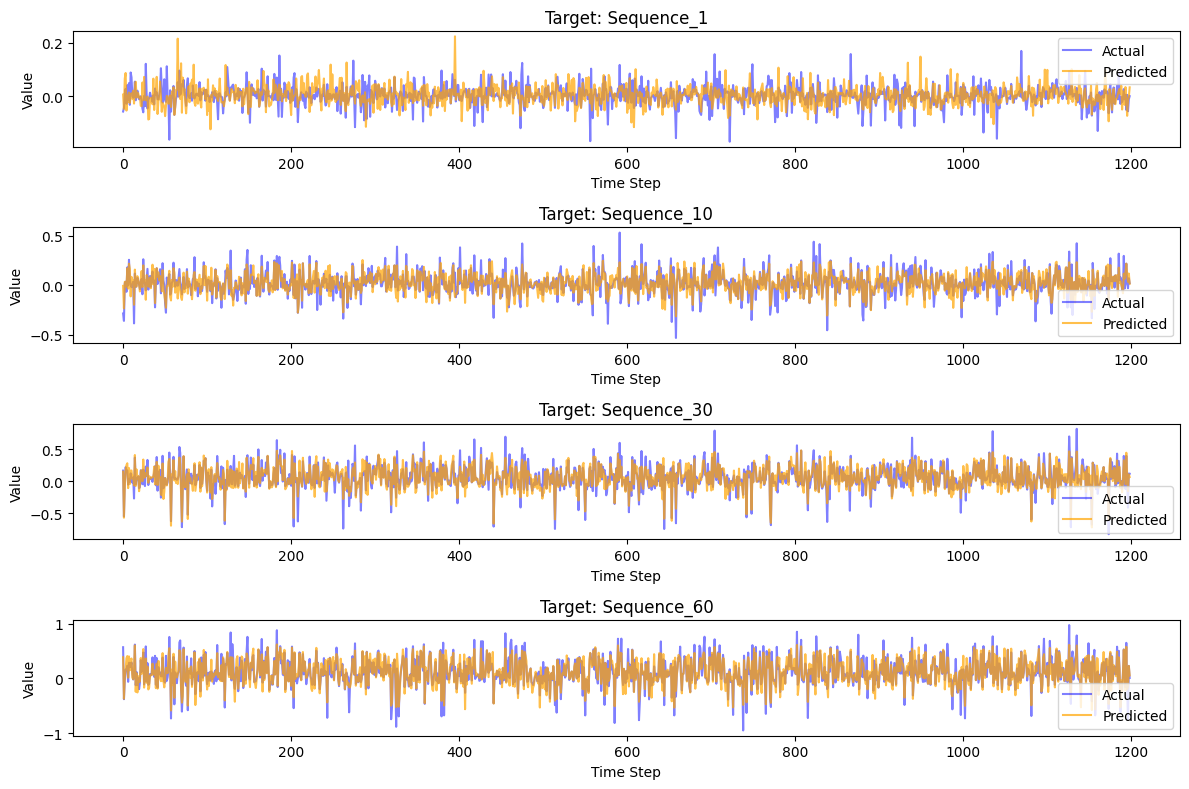

Mean Squared Error: 0.0074


In [ ]:
# Make predictions
predictions = predict(model, X_test_tensor)

# Visualize results
def visualize_results(predictions, y_test, target_labels):
    plt.figure(figsize=(12, 8))
    num_targets = predictions.shape[1]
    for i in range(num_targets):
        plt.subplot(num_targets, 1, i + 1)
        plt.plot(y_test[:, i], label='Actual', color='blue', alpha=0.5)
        plt.plot(predictions[:, i].numpy(), label='Predicted', color='orange', alpha=0.7)
        plt.title(f'Target: {target_labels[i]}')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Define target labels
target_labels = ['Sequence_1', 'Sequence_10', 'Sequence_30', 'Sequence_60']

# Visualize predictions vs actual
visualize_results(predictions, y_test_tensor, target_labels)

# Calculate Mean Squared Error
predictions_np = predictions.numpy()
y_test_np = y_test_tensor.numpy()
mse = mean_squared_error(y_test_np, predictions_np)
print(f"Mean Squared Error: {mse:.4f}")

Training data shape: torch.Size([12450, 18, 60])
Test data shape: torch.Size([60, 18, 60])
Training labels shape: torch.Size([12450, 4])
Test labels shape: torch.Size([60, 4])


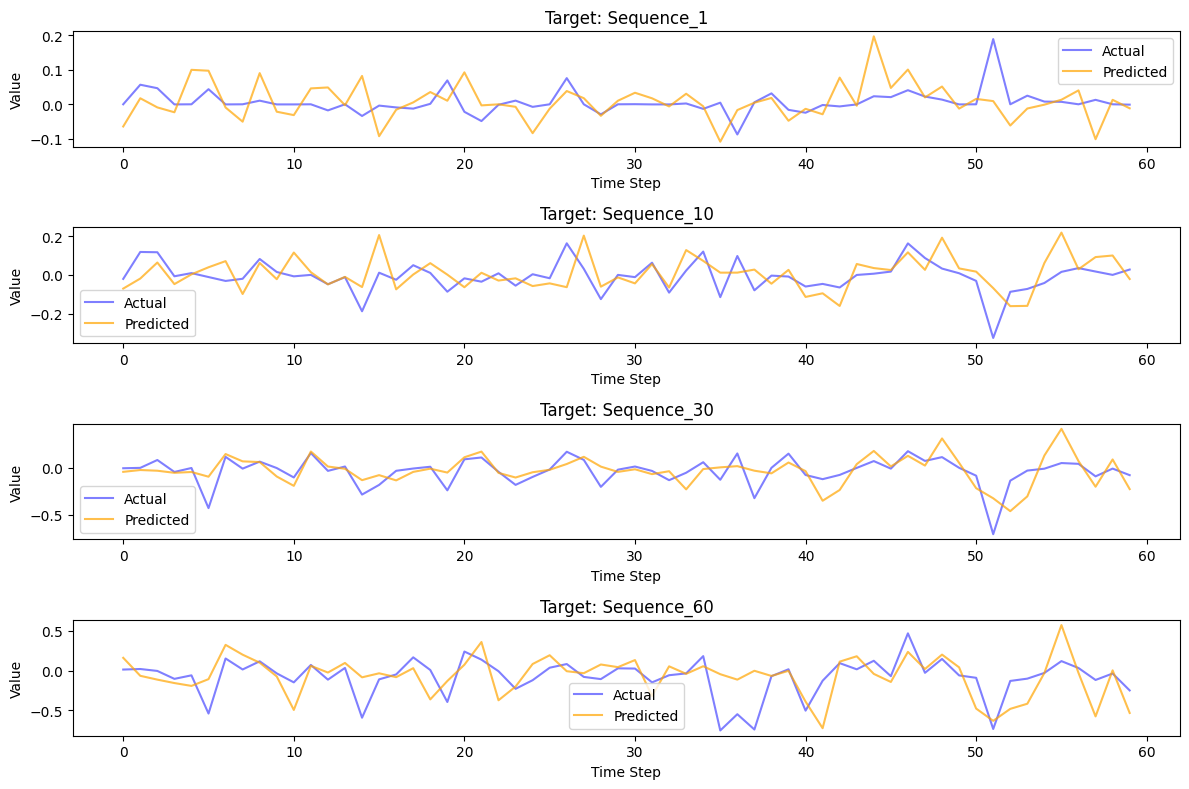

Mean Squared Error: 0.0243


In [ ]:
df = dff[1323:13833]

data = df.drop(columns=['Time of Day', 'Index', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                        'Sequence_40','p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240',
                        'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])


#window size map
window_size_map = {
    'Sequence_1': 1, 'Sequence_10': 10, 'Sequence_30': 30, 'Sequence_60': 60,
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60
}
features_window_size_map = {
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60
}

targets_window_size_map = {
    'Sequence_1': 1, 'Sequence_10': 10, 'Sequence_30': 30, 'Sequence_60': 60
}

# Separate features and targets
features = data.drop(columns=targets_window_size_map.keys())
targets = data[list(targets_window_size_map.keys())]

# Determine the maximum window size for padding
max_window_size = max(features_window_size_map.values())

# Prepare sequences for each feature based on window sizes with padding
sequences = []
labels = []

for idx in range(len(data)):
    feature_seq = []
    for feature, window_size in features_window_size_map.items():
        if idx >= window_size - 1:
            feature_values = features[feature].iloc[idx - window_size + 1: idx + 1].values
        else:
            # Padding for early indices
            feature_values = [0] * (window_size - idx - 1) + features[feature].iloc[:idx + 1].tolist()

        # Ensure feature_values is a 1D list and pad to max_window_size
        feature_values = feature_values if isinstance(feature_values, list) else feature_values.tolist()
        padded_feature_values = [0] * (max_window_size - len(feature_values)) + feature_values
        feature_seq.append(padded_feature_values)

    sequences.append(feature_seq)
    labels.append(targets.iloc[idx].values)  # Use target values at the current timestep


# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=60)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Final dataset shape for Transformer input
print(f"Training data shape: {X_train_tensor.shape}")
print(f"Test data shape: {X_test_tensor.shape}")
print(f"Training labels shape: {y_train_tensor.shape}")
print(f"Test labels shape: {y_test_tensor.shape}")

# Make predictions
predictions = predict(model, X_test_tensor)

# Visualize results
def visualize_results(predictions, y_test, target_labels):
    plt.figure(figsize=(12, 8))
    num_targets = predictions.shape[1]
    for i in range(num_targets):
        plt.subplot(num_targets, 1, i + 1)
        plt.plot(y_test[:, i], label='Actual', color='blue', alpha=0.5)
        plt.plot(predictions[:, i].numpy(), label='Predicted', color='orange', alpha=0.7)
        plt.title(f'Target: {target_labels[i]}')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Define target labels
target_labels = ['Sequence_1', 'Sequence_10', 'Sequence_30', 'Sequence_60']

# Visualize predictions vs actual
visualize_results(predictions, y_test_tensor, target_labels)

# Calculate Mean Squared Error
predictions_np = predictions.numpy()
y_test_np = y_test_tensor.numpy()
mse = mean_squared_error(y_test_np, predictions_np)
print(f"Mean Squared Error: {mse:.4f}")

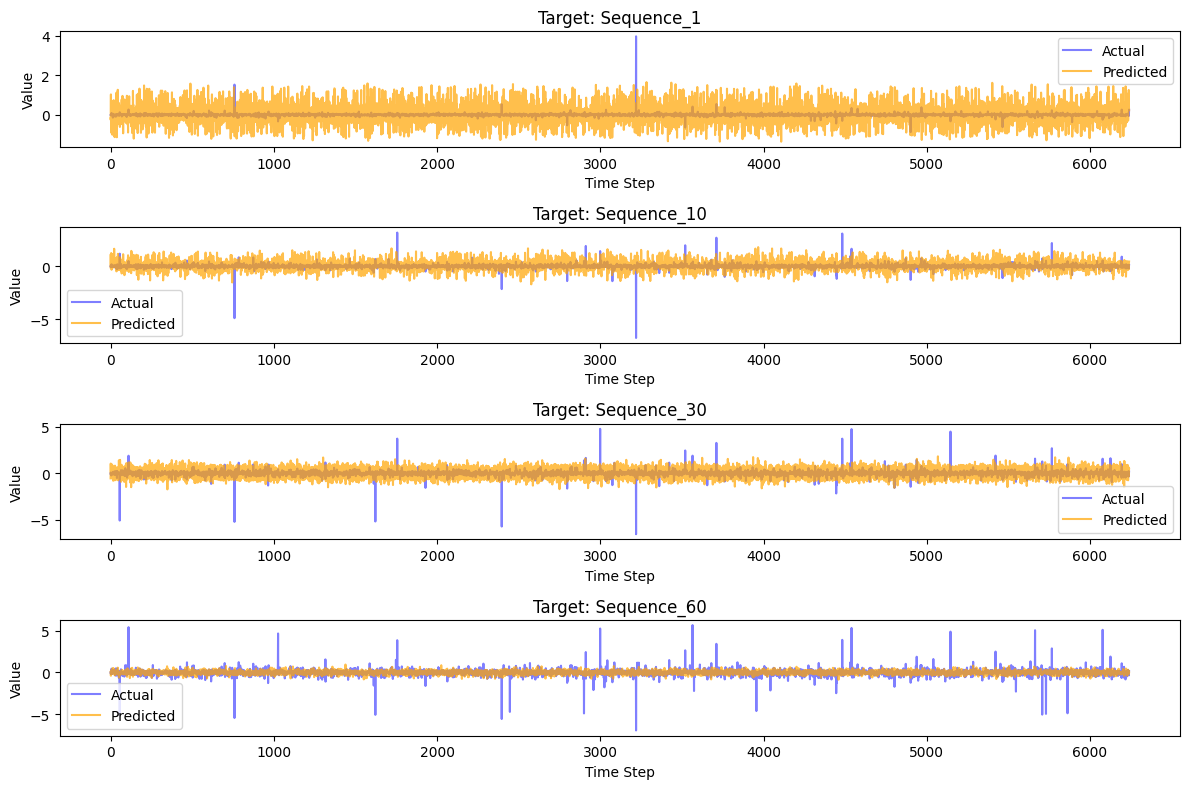

Mean Squared Error: 0.2956


In [ ]:
# Make predictions
predictions = predict(model, X_test_tensor)

# Visualize results
def visualize_results(predictions, y_test, target_labels):
    plt.figure(figsize=(12, 8))
    num_targets = predictions.shape[1]
    for i in range(num_targets):
        plt.subplot(num_targets, 1, i + 1)
        plt.plot(y_test[:, i], label='Actual', color='blue', alpha=0.5)
        plt.plot(predictions[:, i].numpy(), label='Predicted', color='orange', alpha=0.7)
        plt.title(f'Target: {target_labels[i]}')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Define target labels
target_labels = ['Sequence_1', 'Sequence_10', 'Sequence_30', 'Sequence_60']

# Visualize predictions vs actual
visualize_results(predictions, y_test_tensor, target_labels)

# Calculate Mean Squared Error
predictions_np = predictions.numpy()
y_test_np = y_test_tensor.numpy()
mse = mean_squared_error(y_test_np, predictions_np)
print(f"Mean Squared Error: {mse:.4f}")

Metrics for Target 1:
  MSE: 0.1538
  MAE: 0.3742

Metrics for Target 2:
  MSE: 0.0507
  MAE: 0.1513

Metrics for Target 3:
  MSE: 0.2559
  MAE: 0.4344

Metrics for Target 4:
  MSE: 0.4488
  MAE: 0.5226



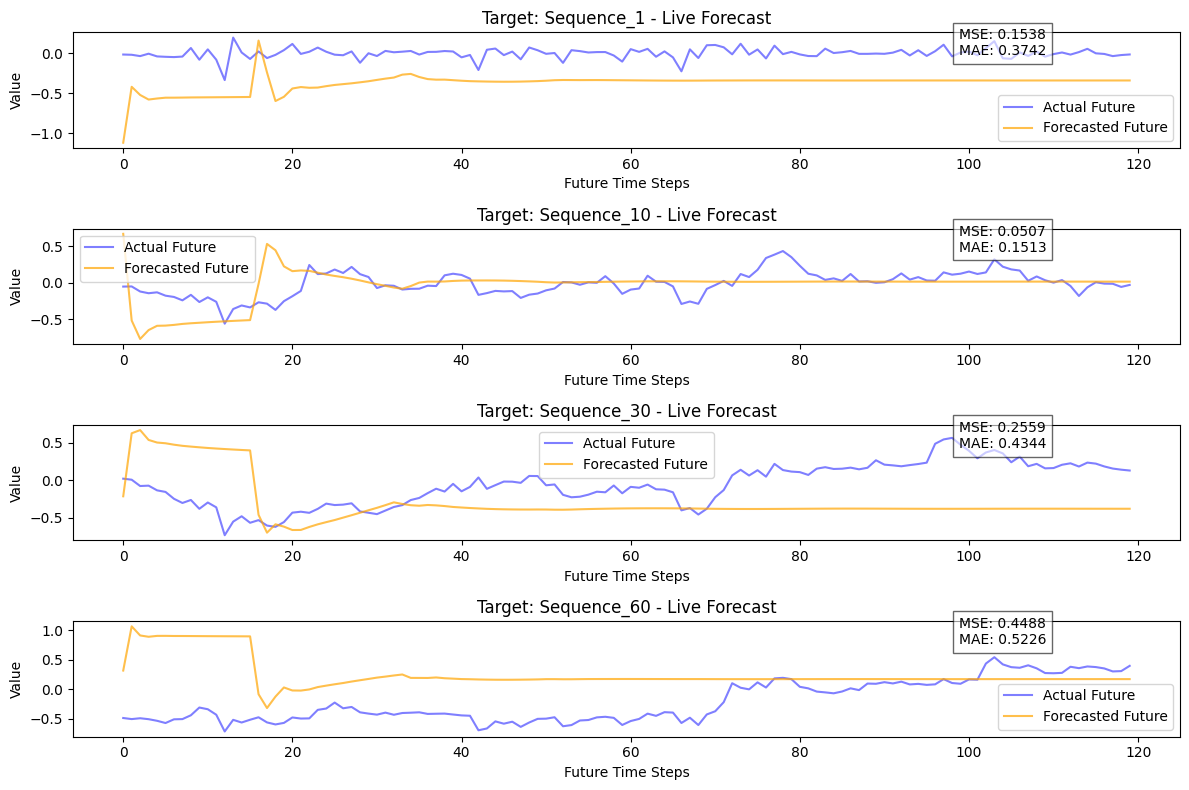

In [ ]:
# Assuming `dff` is the dataset and the model is trained
input_dff = dff[50000+1701+60:50000+1702+60]  # Selecting a sequence of 16 samples for input
input_df = input_dff.drop(columns=['Time of Day', 'Index', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                                   'Sequence_40', 'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240',
                                   'hl_240', 'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

future_dff = dff[50000+1718+60:50000+1718+120+60]  # Selecting 120 steps for future targets
future_df = future_dff.drop(columns=['Time of Day', 'Index', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                                     'Sequence_40', 'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240',
                                     'hl_240', 'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

# Convert `input_df` and `future_df` to NumPy arrays first, then to PyTorch tensors
input_array = input_df.to_numpy()  # Shape should be (16, feature_dim), e.g., (16, 22)
future_array = future_df.to_numpy()  # Shape should be (120, feature_dim), e.g., (120, 22)

# Convert to PyTorch tensors and add the batch dimension for the model input
input_tensor = torch.tensor(input_array, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 16, 22)
future_targets_tensor = torch.tensor(future_array, dtype=torch.float32)

# Padding function to match the feature dimension of `input_tensor`
def pad_prediction(prediction, target_dim):
    padding_size = target_dim - prediction.shape[-1]
    padding = torch.zeros(*prediction.shape[:-1], padding_size, dtype=prediction.dtype)
    padded_prediction = torch.cat((prediction, padding), dim=-1)
    return padded_prediction

# Forecast function with padded input and future steps
def forecast_future_steps(model, input_tensor, future_steps, target_dim=22):
    model.eval()
    predictions = []
    with torch.no_grad():
        for _ in range(future_steps):
            # Run prediction and store it
            input_tensor_padded = pad_input_tensor(input_tensor[:, -16:, :], 60)  # Adjust if model expects 60 features
            prediction = model(input_tensor_padded)
            predictions.append(prediction.squeeze(0).numpy())

            # Pad prediction to match input_tensor's feature dimension for concatenation
            next_input = pad_prediction(prediction.unsqueeze(1), target_dim)
            input_tensor = torch.cat((input_tensor, next_input), dim=1)

    return np.array(predictions)  # Shape: (120, 4)

# Compute and display metrics for each target
def compute_metrics(predictions, future_targets):
    mse_list = []
    mae_list = []

    for i in range(predictions.shape[1]):
        mse = mean_squared_error(future_targets[:, i], predictions[:, i])
        mae = mean_absolute_error(future_targets[:, i], predictions[:, i])

        mse_list.append(mse)
        mae_list.append(mae)

        print(f"Metrics for Target {i + 1}:")
        print(f"  MSE: {mse:.4f}")
        print(f"  MAE: {mae:.4f}\n")

    return mse_list, mae_list

# Visualization function with metrics display
def visualize_live_prediction(predictions, future_targets, target_labels):
    plt.figure(figsize=(12, 8))
    num_targets = predictions.shape[1]

    mse_list, mae_list = compute_metrics(predictions, future_targets)

    for i in range(num_targets):
        plt.subplot(num_targets, 1, i + 1)
        plt.plot(future_targets[:, i], label='Actual Future', color='blue', alpha=0.5)
        plt.plot(predictions[:, i], label='Forecasted Future', color='orange', alpha=0.7)
        plt.title(f'Target: {target_labels[i]} - Live Forecast')
        plt.xlabel('Future Time Steps')
        plt.ylabel('Value')
        plt.legend()

        # Display metrics on plot
        plt.text(0.8, 0.8, f"MSE: {mse_list[i]:.4f}\nMAE: {mae_list[i]:.4f}",
                 transform=plt.gca().transAxes, fontsize=10,
                 bbox=dict(facecolor='white', alpha=0.6))

    plt.tight_layout()
    plt.show()

# Define target labels for visualization
target_labels = ['Sequence_1', 'Sequence_10', 'Sequence_30', 'Sequence_60']

# Forecast the next 120 steps based on the last 16 samples
future_predictions = forecast_future_steps(model, input_tensor, future_steps=120)

# Visualize live predictions vs actual future values with metrics
visualize_live_prediction(future_predictions, future_targets_tensor, target_labels)


In [ ]:
# Assuming `dff` is the dataset and the model is trained
input_dff = dff[60000+1701+60:60000+1702+60]  # Selecting a sequence of 16 samples for input
input_df = input_dff.drop(columns=['Time of Day', 'Index', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                                   'Sequence_40', 'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240',
                                   'hl_240', 'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

future_dff = dff[60000+1703+60:60000+1703+60+260]  # Selecting 120 steps for future targets
future_df = future_dff.drop(columns=['Time of Day', 'Index', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                                     'Sequence_40', 'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240',
                                     'hl_240', 'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

# Convert `input_df` and `future_df` to NumPy arrays first, then to PyTorch tensors
input_array = input_df.to_numpy()  # Shape should be (16, feature_dim), e.g., (16, 22)
future_array = future_df.to_numpy()  # Shape should be (120, feature_dim), e.g., (120, 22)

In [ ]:
# Final dataset shape for Transformer input
print(f"Training data shape: {X_train_tensor.shape}")
print(f"Test data shape: {X_test_tensor.shape}")
print(f"Training labels shape: {y_train_tensor.shape}")
print(f"Test labels shape: {y_test_tensor.shape}")


Training data shape: torch.Size([960, 18, 60])
Test data shape: torch.Size([240, 18, 60])
Training labels shape: torch.Size([960, 4])
Test labels shape: torch.Size([240, 4])


In [ ]:
df = dff[1201:1262]

data = df.drop(columns=['Time of Day', 'Index', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                        'Sequence_40','p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240',
                        'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])


#window size map
window_size_map = {
    'Sequence_1': 1, 'Sequence_10': 10, 'Sequence_30': 30, 'Sequence_60': 60,
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60
}
features_window_size_map = {
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60
}

targets_window_size_map = {
    'Sequence_1': 1, 'Sequence_10': 10, 'Sequence_30': 30, 'Sequence_60': 60
}

# Separate features and targets
features = data.drop(columns=targets_window_size_map.keys())
targets = data[list(targets_window_size_map.keys())]

# Determine the maximum window size for padding
max_window_size = max(features_window_size_map.values())

# Prepare sequences for each feature based on window sizes with padding
sequences = []
labels = []

for idx in range(len(data)):
    feature_seq = []
    for feature, window_size in features_window_size_map.items():
        if idx >= window_size - 1:
            feature_values = features[feature].iloc[idx - window_size + 1: idx + 1].values
        else:
            # Padding for early indices
            feature_values = [0] * (window_size - idx - 1) + features[feature].iloc[:idx + 1].tolist()

        # Ensure feature_values is a 1D list and pad to max_window_size
        feature_values = feature_values if isinstance(feature_values, list) else feature_values.tolist()
        padded_feature_values = [0] * (max_window_size - len(feature_values)) + feature_values
        feature_seq.append(padded_feature_values)

    sequences.append(feature_seq)
    labels.append(targets.iloc[idx].values)  # Use target values at the current timestep


# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=60)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Final dataset shape for Transformer input
print(f"Training data shape: {X_train_tensor.shape}")
print(f"Test data shape: {X_test_tensor.shape}")
print(f"Training labels shape: {y_train_tensor.shape}")
print(f"Test labels shape: {y_test_tensor.shape}")

Training data shape: torch.Size([1, 18, 60])
Test data shape: torch.Size([60, 18, 60])
Training labels shape: torch.Size([1, 4])
Test labels shape: torch.Size([60, 4])


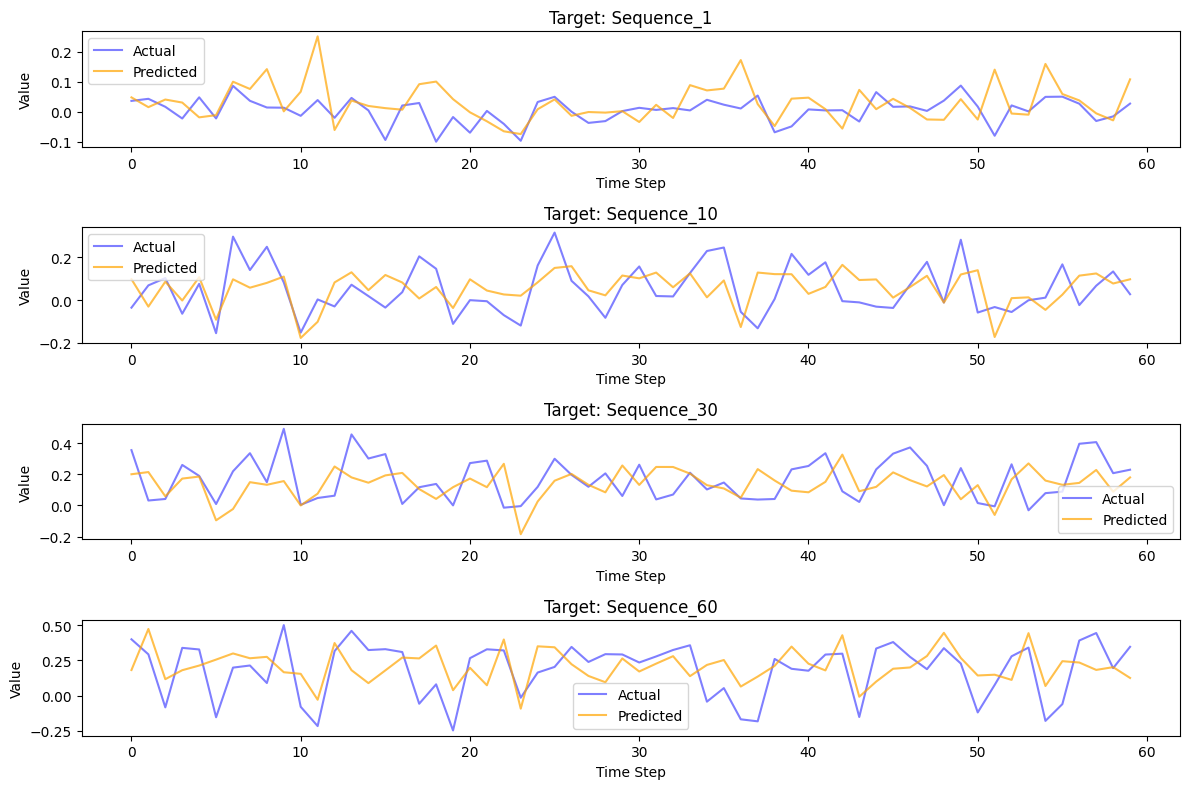

Mean Squared Error: 0.0191


In [ ]:
# Make predictions
predictions = predict(model, X_test_tensor)

# Visualize results
def visualize_results(predictions, y_test, target_labels):
    plt.figure(figsize=(12, 8))
    num_targets = predictions.shape[1]
    for i in range(num_targets):
        plt.subplot(num_targets, 1, i + 1)
        plt.plot(y_test[:, i], label='Actual', color='blue', alpha=0.5)
        plt.plot(predictions[:, i].numpy(), label='Predicted', color='orange', alpha=0.7)
        plt.title(f'Target: {target_labels[i]}')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Define target labels
target_labels = ['Sequence_1', 'Sequence_10', 'Sequence_30', 'Sequence_60']

# Visualize predictions vs actual
visualize_results(predictions, y_test_tensor, target_labels)

# Calculate Mean Squared Error
predictions_np = predictions.numpy()
y_test_np = y_test_tensor.numpy()
mse = mean_squared_error(y_test_np, predictions_np)
print(f"Mean Squared Error: {mse:.4f}")

Training data shape: torch.Size([1, 18, 60])
Test data shape: torch.Size([60, 18, 60])
Training labels shape: torch.Size([1, 4])
Test labels shape: torch.Size([60, 4])


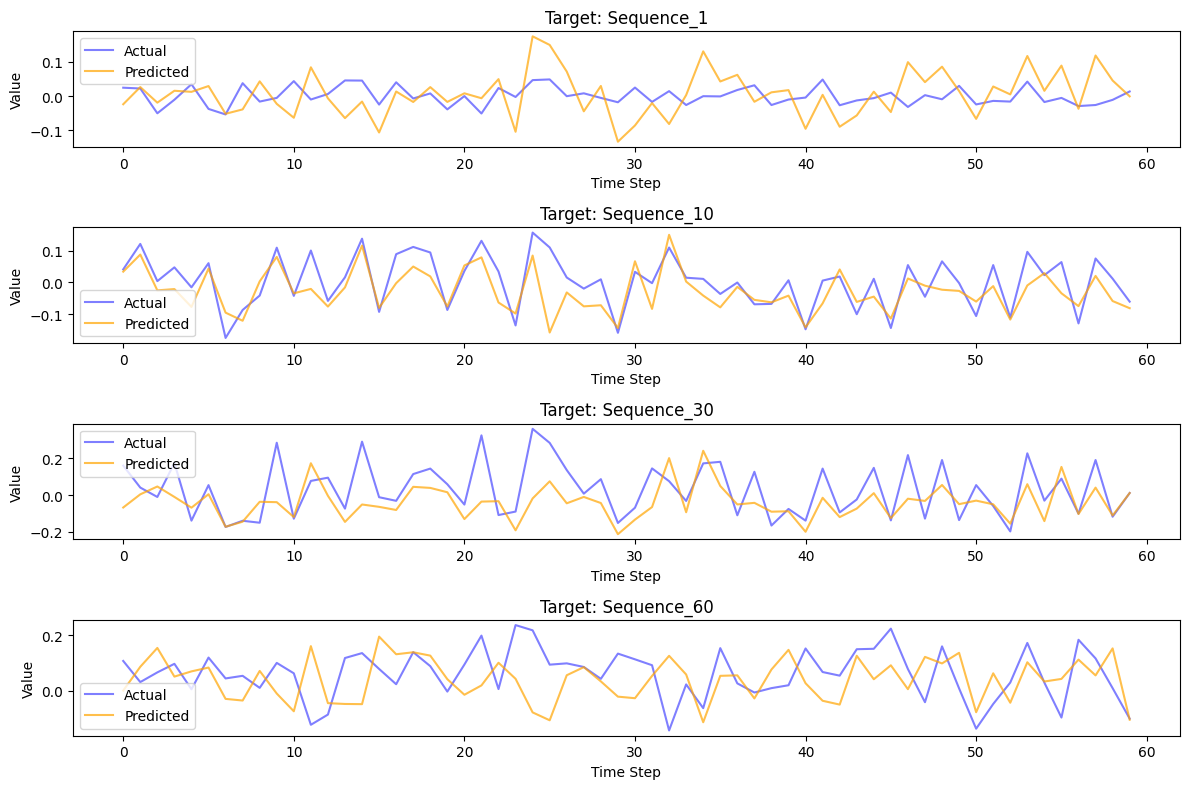

Mean Squared Error: 0.0102


In [ ]:
df = dff[1383:1444]

data = df.drop(columns=['Time of Day', 'Index', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                        'Sequence_40','p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240',
                        'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])


#window size map
window_size_map = {
    'Sequence_1': 1, 'Sequence_10': 10, 'Sequence_30': 30, 'Sequence_60': 60,
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60
}
features_window_size_map = {
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60
}

targets_window_size_map = {
    'Sequence_1': 1, 'Sequence_10': 10, 'Sequence_30': 30, 'Sequence_60': 60
}

# Separate features and targets
features = data.drop(columns=targets_window_size_map.keys())
targets = data[list(targets_window_size_map.keys())]

# Determine the maximum window size for padding
max_window_size = max(features_window_size_map.values())

# Prepare sequences for each feature based on window sizes with padding
sequences = []
labels = []

for idx in range(len(data)):
    feature_seq = []
    for feature, window_size in features_window_size_map.items():
        if idx >= window_size - 1:
            feature_values = features[feature].iloc[idx - window_size + 1: idx + 1].values
        else:
            # Padding for early indices
            feature_values = [0] * (window_size - idx - 1) + features[feature].iloc[:idx + 1].tolist()

        # Ensure feature_values is a 1D list and pad to max_window_size
        feature_values = feature_values if isinstance(feature_values, list) else feature_values.tolist()
        padded_feature_values = [0] * (max_window_size - len(feature_values)) + feature_values
        feature_seq.append(padded_feature_values)

    sequences.append(feature_seq)
    labels.append(targets.iloc[idx].values)  # Use target values at the current timestep


# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=60)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Final dataset shape for Transformer input
print(f"Training data shape: {X_train_tensor.shape}")
print(f"Test data shape: {X_test_tensor.shape}")
print(f"Training labels shape: {y_train_tensor.shape}")
print(f"Test labels shape: {y_test_tensor.shape}")

# Make predictions
predictions = predict(model, X_test_tensor)

# Visualize results
def visualize_results(predictions, y_test, target_labels):
    plt.figure(figsize=(12, 8))
    num_targets = predictions.shape[1]
    for i in range(num_targets):
        plt.subplot(num_targets, 1, i + 1)
        plt.plot(y_test[:, i], label='Actual', color='blue', alpha=0.5)
        plt.plot(predictions[:, i].numpy(), label='Predicted', color='orange', alpha=0.7)
        plt.title(f'Target: {target_labels[i]}')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Define target labels
target_labels = ['Sequence_1', 'Sequence_10', 'Sequence_30', 'Sequence_60']

# Visualize predictions vs actual
visualize_results(predictions, y_test_tensor, target_labels)

# Calculate Mean Squared Error
predictions_np = predictions.numpy()
y_test_np = y_test_tensor.numpy()
mse = mean_squared_error(y_test_np, predictions_np)
print(f"Mean Squared Error: {mse:.4f}")

Training data shape: torch.Size([1, 18, 60])
Test data shape: torch.Size([60, 18, 60])
Training labels shape: torch.Size([1, 4])
Test labels shape: torch.Size([60, 4])


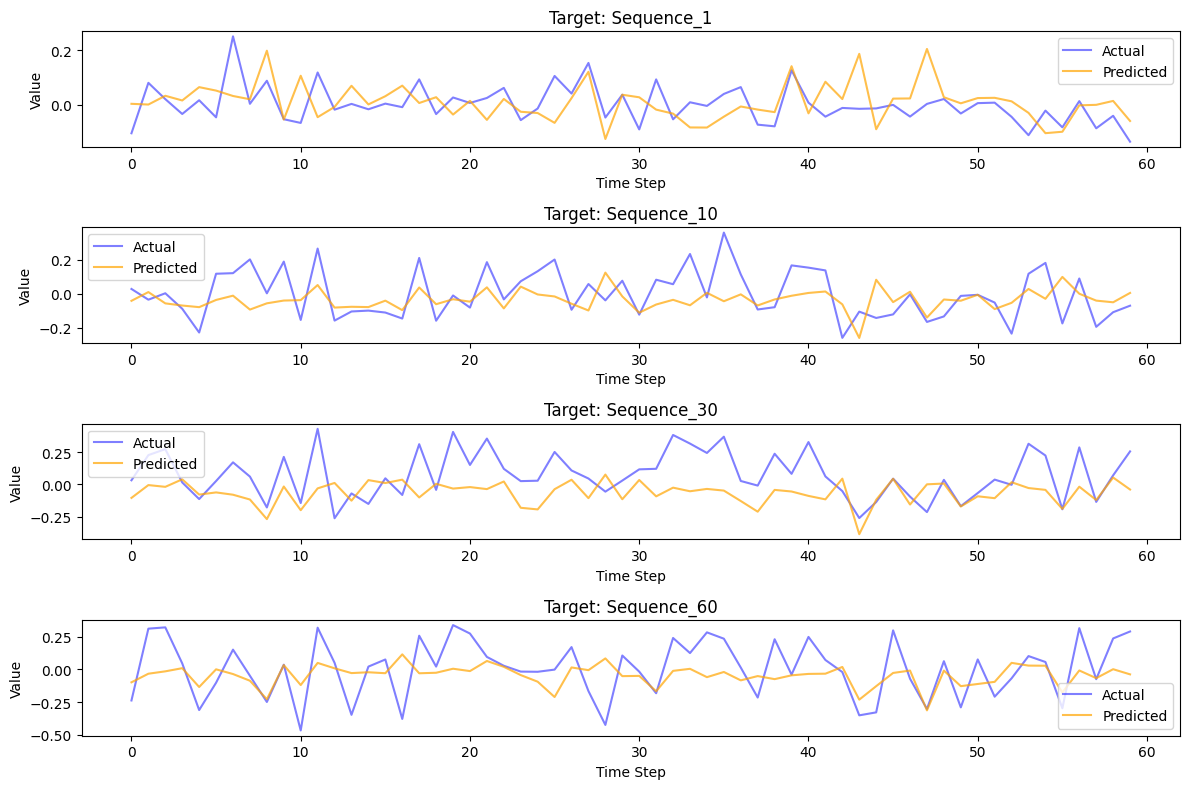

Mean Squared Error: 0.0295


In [ ]:
df = dff[13833:13894]

data = df.drop(columns=['Time of Day', 'Index', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                        'Sequence_40','p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240',
                        'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])


#window size map
window_size_map = {
    'Sequence_1': 1, 'Sequence_10': 10, 'Sequence_30': 30, 'Sequence_60': 60,
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60
}
features_window_size_map = {
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60
}

targets_window_size_map = {
    'Sequence_1': 1, 'Sequence_10': 10, 'Sequence_30': 30, 'Sequence_60': 60
}

# Separate features and targets
features = data.drop(columns=targets_window_size_map.keys())
targets = data[list(targets_window_size_map.keys())]

# Determine the maximum window size for padding
max_window_size = max(features_window_size_map.values())

# Prepare sequences for each feature based on window sizes with padding
sequences = []
labels = []

for idx in range(len(data)):
    feature_seq = []
    for feature, window_size in features_window_size_map.items():
        if idx >= window_size - 1:
            feature_values = features[feature].iloc[idx - window_size + 1: idx + 1].values
        else:
            # Padding for early indices
            feature_values = [0] * (window_size - idx - 1) + features[feature].iloc[:idx + 1].tolist()

        # Ensure feature_values is a 1D list and pad to max_window_size
        feature_values = feature_values if isinstance(feature_values, list) else feature_values.tolist()
        padded_feature_values = [0] * (max_window_size - len(feature_values)) + feature_values
        feature_seq.append(padded_feature_values)

    sequences.append(feature_seq)
    labels.append(targets.iloc[idx].values)  # Use target values at the current timestep


# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=60)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Final dataset shape for Transformer input
print(f"Training data shape: {X_train_tensor.shape}")
print(f"Test data shape: {X_test_tensor.shape}")
print(f"Training labels shape: {y_train_tensor.shape}")
print(f"Test labels shape: {y_test_tensor.shape}")

# Make predictions
predictions = predict(model, X_test_tensor)

# Visualize results
def visualize_results(predictions, y_test, target_labels):
    plt.figure(figsize=(12, 8))
    num_targets = predictions.shape[1]
    for i in range(num_targets):
        plt.subplot(num_targets, 1, i + 1)
        plt.plot(y_test[:, i], label='Actual', color='blue', alpha=0.5)
        plt.plot(predictions[:, i].numpy(), label='Predicted', color='orange', alpha=0.7)
        plt.title(f'Target: {target_labels[i]}')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Define target labels
target_labels = ['Sequence_1', 'Sequence_10', 'Sequence_30', 'Sequence_60']

# Visualize predictions vs actual
visualize_results(predictions, y_test_tensor, target_labels)

# Calculate Mean Squared Error
predictions_np = predictions.numpy()
y_test_np = y_test_tensor.numpy()
mse = mean_squared_error(y_test_np, predictions_np)
print(f"Mean Squared Error: {mse:.4f}")

Training data shape: torch.Size([1, 18, 60])
Test data shape: torch.Size([60, 18, 60])
Training labels shape: torch.Size([1, 4])
Test labels shape: torch.Size([60, 4])


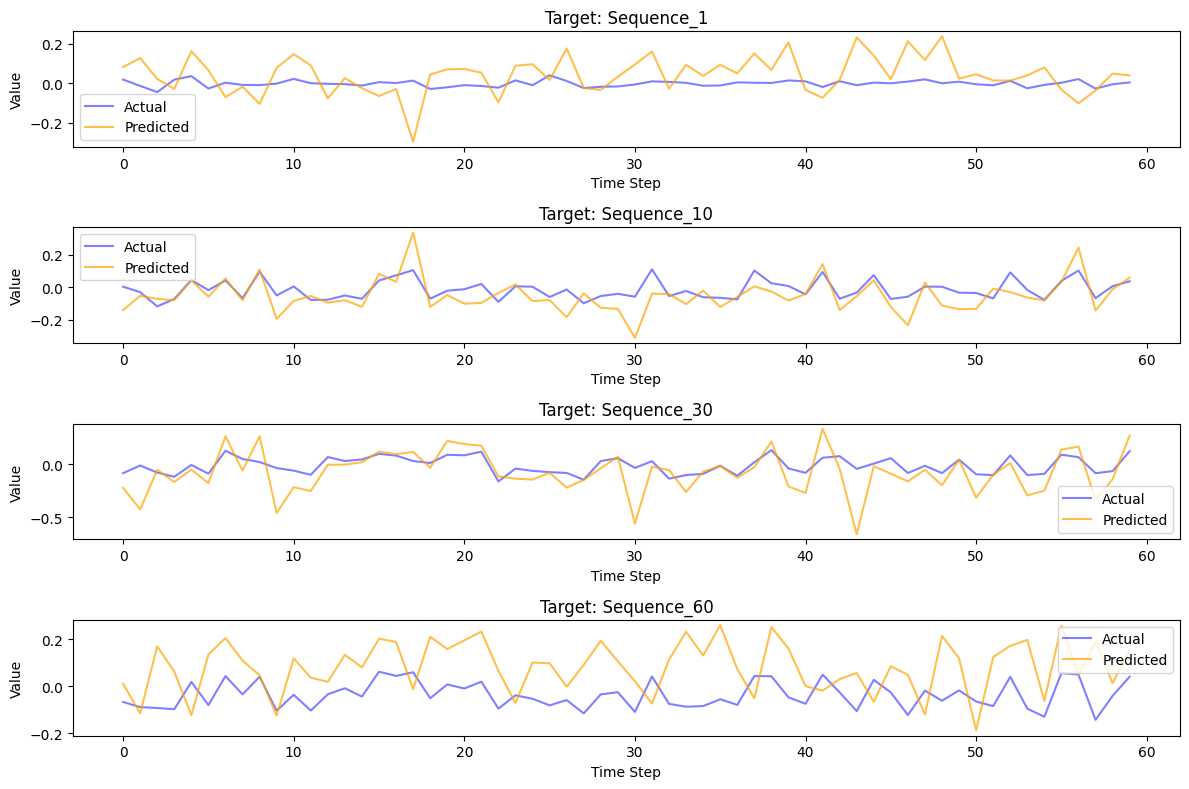

Mean Squared Error: 0.0186


In [ ]:
df = dff[43832:43893]

data = df.drop(columns=['Time of Day', 'Index', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                        'Sequence_40','p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240',
                        'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])


#window size map
window_size_map = {
    'Sequence_1': 1, 'Sequence_10': 10, 'Sequence_30': 30, 'Sequence_60': 60,
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60
}
features_window_size_map = {
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60
}

targets_window_size_map = {
    'Sequence_1': 1, 'Sequence_10': 10, 'Sequence_30': 30, 'Sequence_60': 60
}

# Separate features and targets
features = data.drop(columns=targets_window_size_map.keys())
targets = data[list(targets_window_size_map.keys())]

# Determine the maximum window size for padding
max_window_size = max(features_window_size_map.values())

# Prepare sequences for each feature based on window sizes with padding
sequences = []
labels = []

for idx in range(len(data)):
    feature_seq = []
    for feature, window_size in features_window_size_map.items():
        if idx >= window_size - 1:
            feature_values = features[feature].iloc[idx - window_size + 1: idx + 1].values
        else:
            # Padding for early indices
            feature_values = [0] * (window_size - idx - 1) + features[feature].iloc[:idx + 1].tolist()

        # Ensure feature_values is a 1D list and pad to max_window_size
        feature_values = feature_values if isinstance(feature_values, list) else feature_values.tolist()
        padded_feature_values = [0] * (max_window_size - len(feature_values)) + feature_values
        feature_seq.append(padded_feature_values)

    sequences.append(feature_seq)
    labels.append(targets.iloc[idx].values)  # Use target values at the current timestep


# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=60)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Final dataset shape for Transformer input
print(f"Training data shape: {X_train_tensor.shape}")
print(f"Test data shape: {X_test_tensor.shape}")
print(f"Training labels shape: {y_train_tensor.shape}")
print(f"Test labels shape: {y_test_tensor.shape}")

# Make predictions
predictions = predict(model, X_test_tensor)

# Visualize results
def visualize_results(predictions, y_test, target_labels):
    plt.figure(figsize=(12, 8))
    num_targets = predictions.shape[1]
    for i in range(num_targets):
        plt.subplot(num_targets, 1, i + 1)
        plt.plot(y_test[:, i], label='Actual', color='blue', alpha=0.5)
        plt.plot(predictions[:, i].numpy(), label='Predicted', color='orange', alpha=0.7)
        plt.title(f'Target: {target_labels[i]}')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Define target labels
target_labels = ['Sequence_1', 'Sequence_10', 'Sequence_30', 'Sequence_60']

# Visualize predictions vs actual
visualize_results(predictions, y_test_tensor, target_labels)

# Calculate Mean Squared Error
predictions_np = predictions.numpy()
y_test_np = y_test_tensor.numpy()
mse = mean_squared_error(y_test_np, predictions_np)
print(f"Mean Squared Error: {mse:.4f}")

In [58]:
print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==-=-=-=-=-=-==---===---==---==--FIN=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==-=-=-=-=-=-==---===---==---==--")

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==-=-=-=-=-=-==---===---==---==--FIN=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==-=-=-=-=-=-==---===---==---==--


In [ ]:
data = df.drop(columns=['Time of Day', 'Index', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                        'Sequence_40','p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240',
                        'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

# Scale the data
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_data = scaler.fit_transform(data)

# Define window sizes for each target
#window_sizes = {'Sequence_1': 1, 'Sequence_10': 10, 'Sequence_30': 30, 'Sequence_60': 60}
target_columns = ['Sequence_1', 'Sequence_10', 'Sequence_30', 'Sequence_60']

In [ ]:
#window size map
window_size_map = {'Sequence_1':1, 'Sequence_10':10, 'Sequence_30':30, 'Sequence_60':60,
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60
}
features_window_size_map = {
    'p_1': 1, 'hl_1': 1, 'p_2': 2, 'hl_2': 2, 'p_3': 3, 'hl_3': 3, 'p_5': 5,
    'hl_5': 5, 'p_10': 10, 'hl_10': 10, 'p_20': 20, 'hl_20': 20, 'p_30': 30,
    'hl_30': 30, 'p_40': 40, 'hl_40': 40, 'p_60': 60, 'hl_60': 60
}

targets_window_size_map = {'Sequence_1':1, 'Sequence_10':10, 'Sequence_30':30, 'Sequence_60':60}

# data contains features and targets
features = data.drop(columns=['Sequence_1', 'Sequence_10', 'Sequence_30', 'Sequence_60'])
targets = data[['Sequence_1', 'Sequence_10', 'Sequence_30', 'Sequence_60']]

# Prepare data for multi-target prediction with different window sizes
def prepare_data(window_size_map, features, targets):
    X, y1, y10, y30, y60 = [], [], [], [], []

    # Determine the maximum window size among all features
    max_window_size = max(window_size_map.values())

    # Iterate over the time series, creating windows for each data point
    for i in range(max_window_size, len(features)):
        # Stack and flatten features from their respective window sizes
        flattened_window = []
        for feature_name, window_size in window_size_map.items():
            # Slice the window using .iloc for Pandas DataFrame
            feature_window = features[feature_name].iloc[i - window_size:i].values
            flattened_window.append(feature_window)

        # Concatenate all windows for each feature into one long vector for the input
        X.append(np.concatenate(flattened_window))

        # Collect the target sequences for each window
        y1.append(targets['Sequence_1'].iloc[i])
        y10.append(targets['Sequence_10'].iloc[i])
        y30.append(targets['Sequence_30'].iloc[i])
        y60.append(targets['Sequence_60'].iloc[i])

    # Convert lists to numpy arrays
    X_np = np.array(X)
    y1_np = np.array(y1)
    y10_np = np.array(y10)
    y30_np = np.array(y30)
    y60_np = np.array(y60)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X_np, dtype=torch.float32)
    y1_tensor = torch.tensor(y1_np, dtype=torch.float32).unsqueeze(1)
    y10_tensor = torch.tensor(y10_np, dtype=torch.float32).unsqueeze(1)
    y30_tensor = torch.tensor(y30_np, dtype=torch.float32).unsqueeze(1)
    y60_tensor = torch.tensor(y60_np, dtype=torch.float32).unsqueeze(1)

    return X_tensor, [y1_tensor, y10_tensor, y30_tensor, y60_tensor]

# Prepare tensors
train_size = int(0.8 * len(data))
features_train = features[:train_size]
features_test = features[train_size:]
targets_train = {key: val[:train_size] for key, val in targets.items()}
targets_test = {key: val[train_size:] for key, val in targets.items()}
# Split the data into training and testing sets
X_train_tensor, y_train_tensors = prepare_data(window_size_map, features_train, targets_train)
X_test_tensor, y_test_tensors = prepare_data(window_size_map, features_test, targets_test)

# You can print the shapes to verify
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensors shapes: {[yt.shape for yt in y_train_tensors]}")

X_train_tensor shape: torch.Size([900, 342])
y_train_tensors shapes: [torch.Size([900, 1]), torch.Size([900, 1]), torch.Size([900, 1]), torch.Size([900, 1])]


In [ ]:
#X_train_tensor, y_train_tensors = prepare_data(window_size_map, features_train, targets_train)
#X_test_tensor, y_test_tensors = prepare_data(window_size_map, features_test, targets_test)

In [ ]:
 y1_test_tensor, y10_test_tensor, y30_test_tensor, y60_test_tensor = y_test_tensors
 y1_train_tensor, y10_train_tensor, y30_train_tensor, y60_train_tensor = y_train_tensors

In [ ]:
# Split the data into training and testing sets
train_size = int(0.8 * len(data))
features_train = features[:train_size]
features_test = features[train_size:]
targets_train = {key: val[:train_size] for key, val in targets.items()}
targets_test = {key: val[train_size:] for key, val in targets.items()}

In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)


In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import logging

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import optuna
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Pack the train and test tensors
y_train_tensors = [y1_train_tensor, y10_train_tensor, y30_train_tensor, y60_train_tensor]
y_test_tensors = [y1_test_tensor, y10_test_tensor, y30_test_tensor, y60_test_tensor]

batch_size = 32
epochs = 10  # Modify as needed

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

# Ensure input_dim is divisible by num_heads
def get_compatible_num_heads(input_dim):
    if input_dim % 4 == 0:
        return 4
    elif input_dim % 2 == 0:
        return 2
    else:
        return 1

# Multi-Target Transformer Model with Enhanced Layers
class MultiTargetTransformerModel(nn.Module):
    def __init__(self, input_dim, output_dims, embed_dim, nhead, num_encoder_layers, dim_feedforward, dropout):
        super(MultiTargetTransformerModel, self).__init__()
        self.embed_dim = embed_dim
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead,
                                                        dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.input_projection = nn.Linear(input_dim, embed_dim)
        self.fc_outs = nn.ModuleList([nn.Linear(embed_dim, output_dim) for output_dim in output_dims])

    def forward(self, src):
        src = self.input_projection(src)
        output = self.transformer_encoder(src)
        outs = [fc_out(output[-1]) for fc_out in self.fc_outs]
        return outs

# Evaluation function for multiple targets
def evaluate(model, X_test, y_test_tensors, criterion):
    model.eval()
    test_dataset = TensorDataset(X_test, *y_test_tensors)
    test_loader = DataLoader(test_dataset, batch_size=len(X_test), shuffle=False)
    total_loss = 0

    with torch.no_grad():
        for X_batch, *y_batches in test_loader:
            X_batch = X_batch.to(device)
            y_batches = [y.to(device) for y in y_batches]
            outputs = model(X_batch)
            total_loss += sum(criterion(out, y) for out, y in zip(outputs, y_batches)).item()
    return total_loss

def objective(trial):
    input_dim = X_train_tensor.shape[1]
    output_dims = [1, 1, 1, 1]  # Modify as needed

    # Define hyperparameters to tune
    embed_dim = trial.suggest_int("embed_dim", 64, 256)
    nhead = trial.suggest_categorical("nhead", [1, 2, 4, 8])

    if embed_dim % nhead != 0:
        raise optuna.exceptions.TrialPruned()

    num_encoder_layers = trial.suggest_int("num_encoder_layers", 1, 4)
    dim_feedforward = trial.suggest_int("dim_feedforward", 64, 512)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    # Initialize the model
    model = MultiTargetTransformerModel(
        input_dim=input_dim,
        output_dims=output_dims,
        embed_dim=embed_dim,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_dataset = TensorDataset(X_train_tensor, *y_train_tensors)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for X_batch, *y_batches in train_loader:
            X_batch = X_batch.to(device)
            y_batches = [y.to(device) for y in y_batches]
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = sum(criterion(out, y) for out, y in zip(outputs, y_batches))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        logging.info(f"Epoch {epoch + 1}/{epochs}, Avg Train Loss: {avg_train_loss:.4f}")

    # Evaluation on test set
    test_loss = evaluate(model, X_test_tensor, y_test_tensors, criterion)
    return test_loss

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Retrieve and print the best hyperparameters
best_params = study.best_params
logging.info(f"Best hyperparameters: {best_params}")

# Initialize the final model with optimized parameters
model = MultiTargetTransformerModel(
    input_dim=input_dim,
    output_dims=[1, 1, 1, 1],
    embed_dim=best_params["embed_dim"],
    nhead=best_params["nhead"],
    num_encoder_layers=best_params["num_encoder_layers"],
    dim_feedforward=best_params["dim_feedforward"],
    dropout=best_params["dropout"]
).to(device)

# Define criterion and optimizer for final training
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"])

# Final training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_dataset = TensorDataset(X_train_tensor, *y_train_tensors)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for X_batch, *y_batches in train_loader:
        X_batch = X_batch.to(device)
        y_batches = [y.to(device) for y in y_batches]
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = sum(criterion(out, y) for out, y in zip(outputs, y_batches))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    logging.info(f"Epoch {epoch + 1}/{epochs}, Avg Train Loss: {avg_train_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "best_multi_target_transformer_model.pth")
logging.info("Model saved as best_multi_target_transformer_model.pth")


<ipython-input-28-7c39a4d28d87>:77: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


<ipython-input-29-df4e92e8e2d1>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_multi_target_transformer_model.pth"))


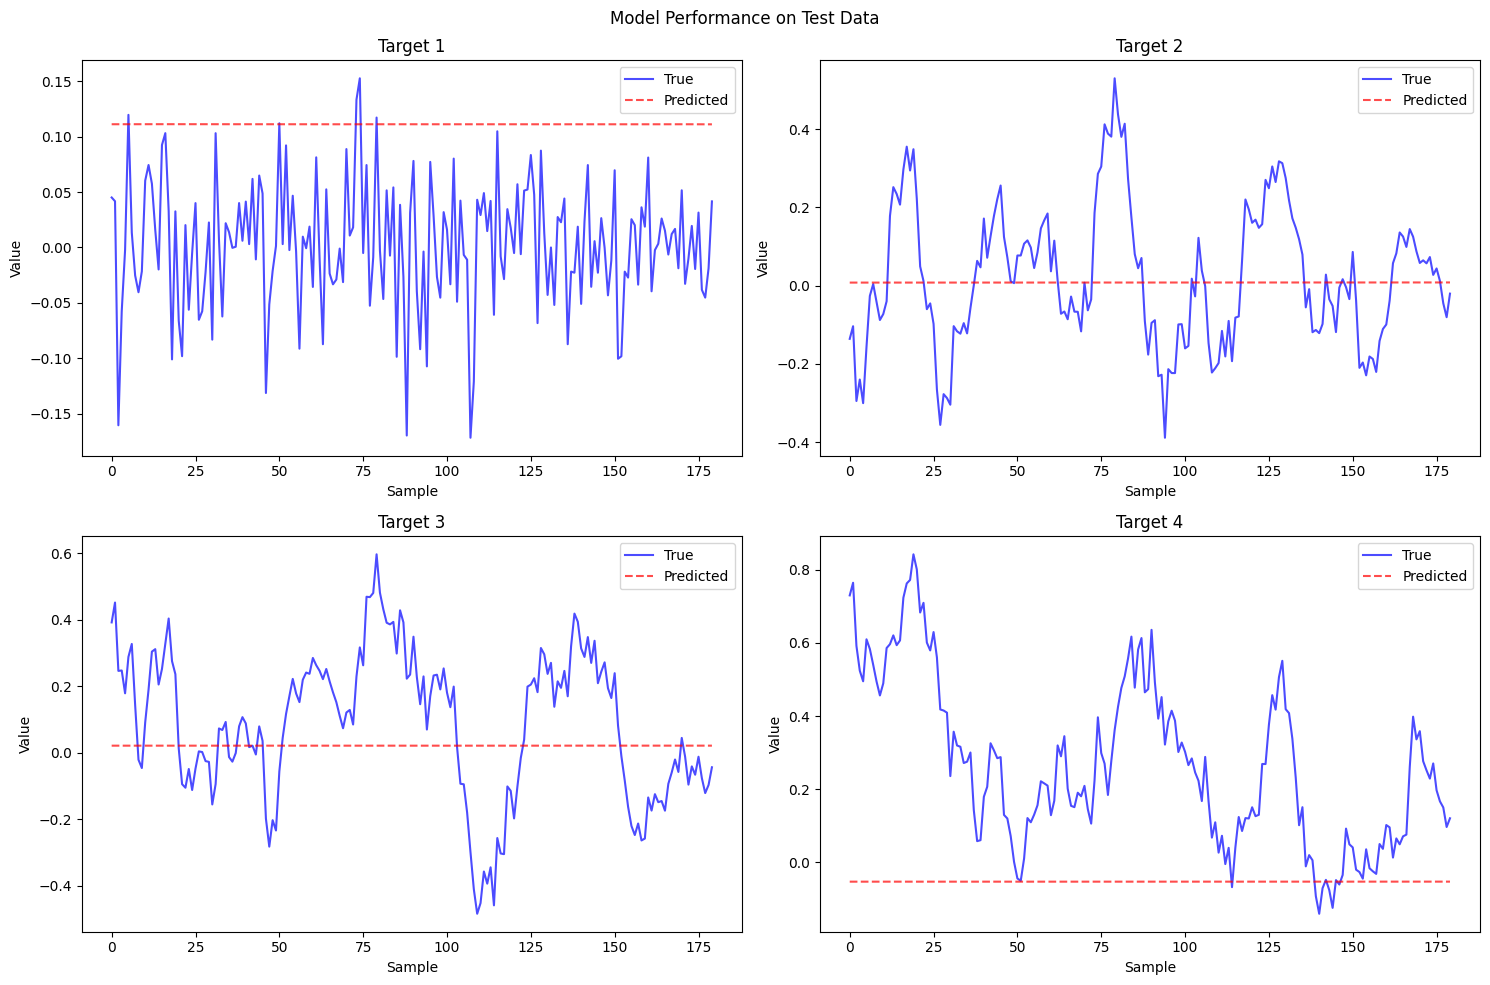

TypeError: len() of unsized object

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the best model
model = MultiTargetTransformerModel(
    input_dim=input_dim,
    output_dims=[1, 1, 1, 1],
    embed_dim=best_params["embed_dim"],
    nhead=best_params["nhead"],
    num_encoder_layers=best_params["num_encoder_layers"],
    dim_feedforward=best_params["dim_feedforward"],
    dropout=best_params["dropout"]
).to(device)
model.load_state_dict(torch.load("best_multi_target_transformer_model.pth"))
model.eval()

# Define criterion for evaluation
criterion = nn.MSELoss()

# Load the test dataset
test_dataset = TensorDataset(X_test_tensor, *y_test_tensors)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize lists to store true and predicted values for each target
y_true, y_pred = [[] for _ in range(4)], [[] for _ in range(4)]

# Evaluate the model and collect predictions
with torch.no_grad():
    for X_batch, *y_batches in test_loader:
        X_batch = X_batch.to(device)
        y_batches = [y.to(device) for y in y_batches]

        # Get model outputs
        outputs = model(X_batch)

        # Store true and predicted values for each target
        for i, (output, y) in enumerate(zip(outputs, y_batches)):
            y_true[i].append(y.cpu().numpy().squeeze())
            y_pred[i].append(output.cpu().numpy().squeeze())

# Visualization of true vs. predicted values for each target
plt.figure(figsize=(15, 10))

# Loop through each target to plot
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_true[i], label="True", color="blue", alpha=0.7)
    plt.plot(y_pred[i], label="Predicted", color="red", linestyle="--", alpha=0.7)
    plt.title(f"Target {i + 1}")
    plt.xlabel("Sample")
    plt.ylabel("Value")
    plt.legend()

plt.suptitle("Model Performance on Test Data")
plt.tight_layout()
plt.show()

# Calculate and log evaluation metrics for each target
total_mse = 0
for i in range(4):
    mse = criterion(torch.tensor(y_pred[i]), torch.tensor(y_true[i])).item()
    total_mse += mse
    logging.info(f"Mean Squared Error for Target {i + 1}: {mse:.4f}")

average_mse = total_mse / 4
logging.info(f"Average Mean Squared Error across all targets: {average_mse:.4f}")


In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Pack the train and test tensors
y_train_tensors = [y1_train_tensor, y10_train_tensor, y30_train_tensor, y60_train_tensor]
y_test_tensors = [y1_test_tensor, y10_test_tensor, y30_test_tensor, y60_test_tensor]

batch_size = 32

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure input_dim is divisible by num_heads
def get_compatible_num_heads(input_dim):
    if input_dim % 4 == 0:
        return 4
    elif input_dim % 2 == 0:
        return 2
    else:
        return 1

# Transformer Model (modified for multiple targets)
class MultiTargetTransformerModel(nn.Module):
    def __init__(self, input_dim, output_dims, embed_dim, nhead, num_encoder_layers, dim_feedforward, dropout):
        super(MultiTargetTransformerModel, self).__init__()
        self.embed_dim = embed_dim
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

        self.fc_out_1 = nn.Linear(input_dim, output_dims[0])
        self.fc_out_10 = nn.Linear(input_dim, output_dims[1])
        self.fc_out_30 = nn.Linear(input_dim, output_dims[2])
        self.fc_out_60 = nn.Linear(input_dim, output_dims[3])

    def forward(self, src):
        output = self.transformer_encoder(src)
        out_1 = self.fc_out_1(output[-1])
        out_10 = self.fc_out_10(output[-1])
        out_30 = self.fc_out_30(output[-1])
        out_60 = self.fc_out_60(output[-1])

        return out_1, out_10, out_30, out_60

# Evaluation function for multiple targets
def evaluate(model, X_test, y_test_tensors, criterion):  # Pass criterion as an argument
    model.eval()
    test_dataset = TensorDataset(X_test, *y_test_tensors)
    test_loader = DataLoader(test_dataset, batch_size=len(X_test), shuffle=False)

    with torch.no_grad():
        for X_batch, y1_batch, y10_batch, y30_batch, y60_batch in test_loader:
            X_batch = X_batch.to(device)
            y1_batch, y10_batch, y30_batch, y60_batch = y1_batch.to(device), y10_batch.to(device), y30_batch.to(device), y60_batch.to(device)
            out_1, out_10, out_30, out_60 = model(X_batch)

    # Return predictions and test loss
    test_loss = criterion(out_1, y1_batch) + criterion(out_10, y10_batch) + criterion(out_30, y30_batch) + criterion(out_60, y60_batch)
    return (out_1.cpu(), out_10.cpu(), out_30.cpu(), out_60.cpu()), test_loss

def objective(trial):
    # Define hyperparameters
    input_dim = X_train_tensor.shape[1]
    output_dims = [1, 1, 1, 1]

    nhead = trial.suggest_categorical("nhead", [1, 2, 4, 8])
    embed_dim = trial.suggest_int("embed_dim", 64, 256)  # Define embed_dim as a hyperparameter

    # Ensure embed_dim is divisible by nhead
    if embed_dim % nhead != 0:
        raise optuna.TrialPruned()  # Skip this trial if not divisible

    num_encoder_layers = trial.suggest_int("num_encoder_layers", 1, 4)
    dim_feedforward = trial.suggest_int("dim_feedforward", 64, 256)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    # Initialize model
    model = MultiTargetTransformerModel(
        input_dim=X_train_tensor.shape[1],
        output_dims=output_dims,
        embed_dim=embed_dim,  # Pass embed_dim here
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout
    ).to(device)

    # Define criterion and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True))

    # Training
    train(model, X_train_tensor, y_train_tensors, criterion, optimizer, epochs, batch_size)

    # Evaluation
    _, test_loss = evaluate(model, X_test_tensor, y_test_tensors, criterion)
    return test_loss

# Optuna hyperparameter tuning
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)



# Retrieve and print the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Initialize model with best parameters
# Initialize model with best parameters
nhead = get_compatible_num_heads(input_dim)  # Now input_dim is defined
model = MultiTargetTransformerModel(
    input_dim=input_dim,
    output_dims=[1, 1, 1, 1],
    embed_dim=best_params["embed_dim"],  # Define embed_dim from best_params
    nhead=nhead,
    num_encoder_layers=best_params["num_encoder_layers"],
    dim_feedforward=best_params["dim_feedforward"],
    dropout=best_params["dropout"]
).to(device)

# Train final model with best parameters
epochs, batch_size = 10, 32  # Modify as needed
train(model, X_train_tensor, y_train_tensors, criterion, optimizer, epochs, batch_size)

# Save model
torch.save(model.state_dict(), "best_multi_target_transformer_model.pth")
print("Model saved as best_multi_target_transformer_model.pth")


[I 2024-10-26 19:15:45,760] A new study created in memory with name: no-name-b2776a99-8e9c-4693-9c1b-8f9805a7f8bf
[I 2024-10-26 19:15:45,770] Trial 0 pruned. 


Using device: cuda
Epoch [1/20], Loss: 1.7405
Epoch [2/20], Loss: 1.5448
Epoch [3/20], Loss: 0.9693
Epoch [4/20], Loss: 0.8798
Epoch [5/20], Loss: 0.9092
Epoch [6/20], Loss: 0.5930
Epoch [7/20], Loss: 0.5003
Epoch [8/20], Loss: 0.8567
Epoch [9/20], Loss: 0.7363
Epoch [10/20], Loss: 0.3713
Epoch [11/20], Loss: 0.5810
Epoch [12/20], Loss: 0.4059
Epoch [13/20], Loss: 0.3386
Epoch [14/20], Loss: 0.2349
Epoch [15/20], Loss: 0.2976
Epoch [16/20], Loss: 0.2618
Epoch [17/20], Loss: 0.2675
Epoch [18/20], Loss: 0.2796
Epoch [19/20], Loss: 0.2416


[I 2024-10-26 19:15:54,469] Trial 1 finished with value: 0.14757058024406433 and parameters: {'nhead': 2, 'embed_dim': 250, 'num_encoder_layers': 4, 'dim_feedforward': 127, 'dropout': 0.4852158979641542, 'learning_rate': 0.0014842879104421537}. Best is trial 1 with value: 0.14757058024406433.
[I 2024-10-26 19:15:54,473] Trial 2 pruned. 
[I 2024-10-26 19:15:54,477] Trial 3 pruned. 


Epoch [20/20], Loss: 0.2551
Epoch [1/20], Loss: 1.1955
Epoch [2/20], Loss: 0.7006
Epoch [3/20], Loss: 0.5640
Epoch [4/20], Loss: 0.6030
Epoch [5/20], Loss: 0.5279
Epoch [6/20], Loss: 0.3468
Epoch [7/20], Loss: 0.2770
Epoch [8/20], Loss: 0.3610
Epoch [9/20], Loss: 0.2843
Epoch [10/20], Loss: 0.3064
Epoch [11/20], Loss: 0.3446
Epoch [12/20], Loss: 0.3148
Epoch [13/20], Loss: 0.3069
Epoch [14/20], Loss: 0.2449
Epoch [15/20], Loss: 0.2402
Epoch [16/20], Loss: 0.2824
Epoch [17/20], Loss: 0.2421
Epoch [18/20], Loss: 0.2367
Epoch [19/20], Loss: 0.2286


[I 2024-10-26 19:16:03,594] Trial 4 finished with value: 0.12557461857795715 and parameters: {'nhead': 2, 'embed_dim': 148, 'num_encoder_layers': 4, 'dim_feedforward': 83, 'dropout': 0.24056629289843037, 'learning_rate': 0.00014929892924114287}. Best is trial 4 with value: 0.12557461857795715.


Epoch [20/20], Loss: 0.2528
Epoch [1/20], Loss: 1.0298
Epoch [2/20], Loss: 0.9186
Epoch [3/20], Loss: 0.8168
Epoch [4/20], Loss: 0.8419
Epoch [5/20], Loss: 0.4399
Epoch [6/20], Loss: 0.3668
Epoch [7/20], Loss: 0.3344
Epoch [8/20], Loss: 0.2526
Epoch [9/20], Loss: 0.2509
Epoch [10/20], Loss: 0.2529
Epoch [11/20], Loss: 0.2230
Epoch [12/20], Loss: 0.2532
Epoch [13/20], Loss: 0.2517
Epoch [14/20], Loss: 0.2269
Epoch [15/20], Loss: 0.2451
Epoch [16/20], Loss: 0.2421
Epoch [17/20], Loss: 0.2201
Epoch [18/20], Loss: 0.2178
Epoch [19/20], Loss: 0.2236


[I 2024-10-26 19:16:09,582] Trial 5 finished with value: 0.19439774751663208 and parameters: {'nhead': 1, 'embed_dim': 176, 'num_encoder_layers': 4, 'dim_feedforward': 75, 'dropout': 0.18425230180776742, 'learning_rate': 0.00012183892152761737}. Best is trial 4 with value: 0.12557461857795715.
[I 2024-10-26 19:16:09,584] Trial 6 pruned. 


Epoch [20/20], Loss: 0.2035
Epoch [1/20], Loss: 4.9189
Epoch [2/20], Loss: 0.9767
Epoch [3/20], Loss: 0.8751
Epoch [4/20], Loss: 0.5755
Epoch [5/20], Loss: 0.4898
Epoch [6/20], Loss: 0.3735
Epoch [7/20], Loss: 0.2967
Epoch [8/20], Loss: 0.2693
Epoch [9/20], Loss: 0.2131
Epoch [10/20], Loss: 0.1866
Epoch [11/20], Loss: 0.2382
Epoch [12/20], Loss: 0.2135
Epoch [13/20], Loss: 0.1915
Epoch [14/20], Loss: 0.2405
Epoch [15/20], Loss: 0.2026
Epoch [16/20], Loss: 0.1924
Epoch [17/20], Loss: 0.1619
Epoch [18/20], Loss: 0.1184
Epoch [19/20], Loss: 0.1299


[I 2024-10-26 19:16:14,173] Trial 7 finished with value: 0.20464152097702026 and parameters: {'nhead': 1, 'embed_dim': 76, 'num_encoder_layers': 3, 'dim_feedforward': 237, 'dropout': 0.23895207227313076, 'learning_rate': 0.006279265750717926}. Best is trial 4 with value: 0.12557461857795715.
[W 2024-10-26 19:16:14,179] Trial 8 failed with parameters: {'nhead': 4, 'embed_dim': 128, 'num_encoder_layers': 4, 'dim_feedforward': 106, 'dropout': 0.16451334324896422} because of the following error: AssertionError('embed_dim must be divisible by num_heads').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-82-db8b524eaf80>", line 84, in objective
    model = MultiTargetTransformerModel(
  File "<ipython-input-82-db8b524eaf80>", line 34, in __init__
    self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_fe

Epoch [20/20], Loss: 0.1252


AssertionError: embed_dim must be divisible by num_heads

Using device: cuda
Adjusting nhead from 4 to 1 since input_dim (11) is not divisible by nhead.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Loss: 0.2738
Epoch [2/20], Loss: 0.2301
Epoch [3/20], Loss: 0.2109
Epoch [4/20], Loss: 0.2337
Epoch [5/20], Loss: 0.2067
Epoch [6/20], Loss: 0.1998
Epoch [7/20], Loss: 0.2163
Epoch [8/20], Loss: 0.2191
Epoch [9/20], Loss: 0.1947
Epoch [10/20], Loss: 0.1936
Epoch [11/20], Loss: 0.1776
Epoch [12/20], Loss: 0.1976
Epoch [13/20], Loss: 0.1677
Epoch [14/20], Loss: 0.1623
Epoch [15/20], Loss: 0.1551
Epoch [16/20], Loss: 0.1456
Epoch [17/20], Loss: 0.1436
Epoch [18/20], Loss: 0.1388
Epoch [19/20], Loss: 0.1312
Epoch [20/20], Loss: 0.1407
Test Loss (MSE): 0.1582


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([398])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


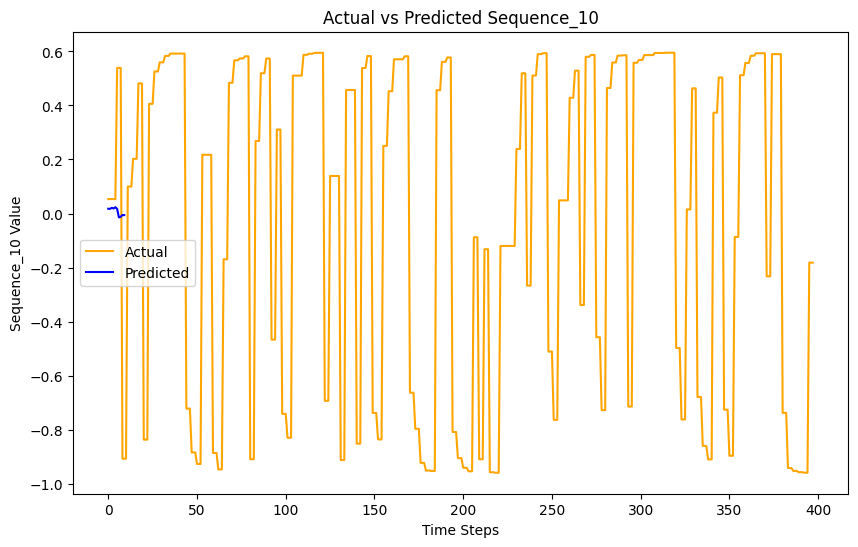

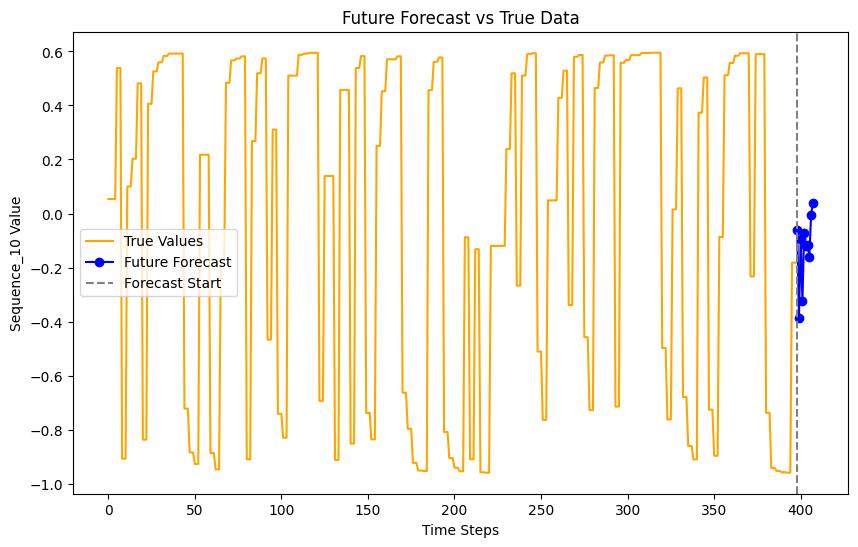

In [ ]:
# Per GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data preparation
data = df.drop(columns=['Time of Day', 'Index', 'Sequence_1', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                        'Sequence_30', 'Sequence_40', 'Sequence_60', 'p_20', 'hl_20', 'p_30', 'hl_30', 'p_40', 'hl_40',
                        'p_60', 'hl_60', 'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240',
                        'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Scale only 'Sequence_10'
sequence_10_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sequence_10 = sequence_10_scaler.fit_transform(data[['Sequence_10']])

# Prepare sequences
def create_sequences(data, window_size, target_column):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :])
        y.append(data[i + window_size, target_column])
    return np.array(X), np.array(y)

# Create sequences
sequence_10_index = df.columns.get_loc('Sequence_10')
window_size = 10  # 10 minutes window size
X, y = create_sequences(scaled_data, window_size, sequence_10_index)

# Split into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors and move to GPU
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, nhead=4, num_encoder_layers=3, dim_feedforward=128, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.fc_out = nn.Linear(input_dim, output_dim)

    def forward(self, src):
        # Pass input through transformer encoder
        output = self.transformer_encoder(src)
        output = self.fc_out(output[-1])  # Take the last output (corresponding to the forecast)
        return output

# Hyperparameters
input_dim = X_train.shape[2]  # Number of features
output_dim = 1  # We are predicting 'Sequence_10'
nhead = 4  # Number of attention heads

# Ensure input_dim is divisible by nhead
if input_dim % nhead != 0:
    print(f"Adjusting nhead from {nhead} to 1 since input_dim ({input_dim}) is not divisible by nhead.")
    nhead = 1  # Set nhead to 1 if input_dim is not divisible by nhead

learning_rate = 0.001
epochs = 20
batch_size = 64

# Initialize the model, loss function, and optimizer
model = TransformerModel(input_dim=input_dim, output_dim=output_dim, nhead=nhead).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train(model, X_train, y_train, criterion, optimizer, epochs, batch_size):
    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Train the model
train(model, X_train_tensor, y_train_tensor, criterion, optimizer, epochs, batch_size)

# Evaluation
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        loss = criterion(predictions, y_test)
        return predictions.cpu().numpy(), loss.item()

# Evaluate the model
predictions, test_loss = evaluate(model, X_test_tensor, y_test_tensor)
print(f"Test Loss (MSE): {test_loss:.4f}")

# Inverse scale the predictions
scaled_predictions = sequence_10_scaler.inverse_transform(predictions)

# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(sequence_10_scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual", color='orange' )
plt.plot(scaled_predictions, label="Predicted", color='blue')
plt.title('Actual vs Predicted Sequence_10')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.legend()
plt.show()

# Forecast the next 10 minutes
def forecast_future(data, model, window_size, future_steps, target_index):
    future_forecast = []
    current_sequence = torch.tensor(data[-window_size:], dtype=torch.float32).to(device)  # Start with the last available window

    for _ in range(future_steps):
        # Make prediction
        next_step = model(current_sequence.unsqueeze(0))  # Add batch dimension if needed

        # Extract only the prediction for 'Sequence_10' (assuming it is a scalar output)
        sequence_10_prediction = next_step[0].cpu().item()  # No need for target_index since the output is a scalar
        future_forecast.append(sequence_10_prediction)  # Append the prediction for 'Sequence_10'

        # Update the sequence for the next prediction
        next_sequence = current_sequence.clone()
        next_sequence = torch.roll(next_sequence, shifts=-1, dims=0)  # Shift the sequence by 1
        next_sequence[-1, target_index] = next_step[0].cpu().item()  # Update 'Sequence_10' with the predicted value

        current_sequence = next_sequence  # Set current sequence for the next iteration

    return np.array(future_forecast)




# Forecast future steps
future_steps = 10
future_forecast = forecast_future(scaled_data, model, window_size, future_steps, sequence_10_index)
scaled_future_forecast = sequence_10_scaler.inverse_transform(future_forecast.reshape(-1, 1))

# Combine the last true values and the forecast for plotting
last_true_values = sequence_10_scaler.inverse_transform(y_test[-window_size:].reshape(-1, 1))
combined_forecast = np.concatenate((last_true_values, scaled_future_forecast))

# Plot true data and future forecast
plt.figure(figsize=(10, 6))
plt.plot(sequence_10_scaler.inverse_transform(y_test.reshape(-1, 1)), label='True Values', color='orange')
plt.plot(range(len(y_test), len(y_test) + future_steps), scaled_future_forecast, label='Future Forecast', color='blue', marker='o')
plt.axvline(x=len(y_test), color='gray', linestyle='--', label='Forecast Start')
plt.title('Future Forecast vs True Data')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.legend()
plt.show()


[I 2024-10-26 09:12:42,110] A new study created in memory with name: no-name-94387c64-3c13-4ba3-b86b-72ec3dfd60e0


Using device: cuda
Epoch [1/20], Loss: 0.1564
Epoch [2/20], Loss: 0.1624
Epoch [3/20], Loss: 0.1892
Epoch [4/20], Loss: 0.1828
Epoch [5/20], Loss: 0.2234
Epoch [6/20], Loss: 0.2236
Epoch [7/20], Loss: 0.2239
Epoch [8/20], Loss: 0.2283
Epoch [9/20], Loss: 0.2228
Epoch [10/20], Loss: 0.2154
Epoch [11/20], Loss: 0.2039
Epoch [12/20], Loss: 0.2095
Epoch [13/20], Loss: 0.2153
Epoch [14/20], Loss: 0.2100
Epoch [15/20], Loss: 0.2162
Epoch [16/20], Loss: 0.2075
Epoch [17/20], Loss: 0.2062
Epoch [18/20], Loss: 0.2186
Epoch [19/20], Loss: 0.2128


[I 2024-10-26 09:12:46,909] Trial 0 finished with value: 0.16060389578342438 and parameters: {'num_encoder_layers': 3, 'dim_feedforward': 152, 'dropout': 0.22509355076278825, 'learning_rate': 0.008408159386775017}. Best is trial 0 with value: 0.16060389578342438.


Epoch [20/20], Loss: 0.2135
Epoch [1/20], Loss: 0.2036
Epoch [2/20], Loss: 0.2249
Epoch [3/20], Loss: 0.2297
Epoch [4/20], Loss: 0.2160
Epoch [5/20], Loss: 0.2037
Epoch [6/20], Loss: 0.2211
Epoch [7/20], Loss: 0.2183
Epoch [8/20], Loss: 0.2261
Epoch [9/20], Loss: 0.2047
Epoch [10/20], Loss: 0.2041
Epoch [11/20], Loss: 0.2086
Epoch [12/20], Loss: 0.2109
Epoch [13/20], Loss: 0.2213
Epoch [14/20], Loss: 0.1973
Epoch [15/20], Loss: 0.1970
Epoch [16/20], Loss: 0.2079
Epoch [17/20], Loss: 0.2011
Epoch [18/20], Loss: 0.1996
Epoch [19/20], Loss: 0.2071


[I 2024-10-26 09:12:51,700] Trial 1 finished with value: 0.1637340486049652 and parameters: {'num_encoder_layers': 4, 'dim_feedforward': 147, 'dropout': 0.47862983755391453, 'learning_rate': 0.005405603326743362}. Best is trial 0 with value: 0.16060389578342438.


Epoch [20/20], Loss: 0.1997
Epoch [1/20], Loss: 0.1515
Epoch [2/20], Loss: 0.1987
Epoch [3/20], Loss: 0.1976
Epoch [4/20], Loss: 0.1867
Epoch [5/20], Loss: 0.1852
Epoch [6/20], Loss: 0.1787
Epoch [7/20], Loss: 0.1799
Epoch [8/20], Loss: 0.1737
Epoch [9/20], Loss: 0.1509
Epoch [10/20], Loss: 0.1688
Epoch [11/20], Loss: 0.1774
Epoch [12/20], Loss: 0.1754
Epoch [13/20], Loss: 0.1488
Epoch [14/20], Loss: 0.1443
Epoch [15/20], Loss: 0.1568
Epoch [16/20], Loss: 0.1360
Epoch [17/20], Loss: 0.1357
Epoch [18/20], Loss: 0.1398
Epoch [19/20], Loss: 0.1324


[I 2024-10-26 09:12:54,237] Trial 2 finished with value: 0.16115522384643555 and parameters: {'num_encoder_layers': 2, 'dim_feedforward': 115, 'dropout': 0.343568160187675, 'learning_rate': 0.0017272814981301797}. Best is trial 0 with value: 0.16060389578342438.


Epoch [20/20], Loss: 0.1355
Epoch [1/20], Loss: 0.3939
Epoch [2/20], Loss: 0.2790
Epoch [3/20], Loss: 0.3126
Epoch [4/20], Loss: 0.2665
Epoch [5/20], Loss: 0.2632
Epoch [6/20], Loss: 0.2651
Epoch [7/20], Loss: 0.2148
Epoch [8/20], Loss: 0.2032
Epoch [9/20], Loss: 0.2272
Epoch [10/20], Loss: 0.1978
Epoch [11/20], Loss: 0.2190
Epoch [12/20], Loss: 0.1954
Epoch [13/20], Loss: 0.2213
Epoch [14/20], Loss: 0.2287
Epoch [15/20], Loss: 0.2024
Epoch [16/20], Loss: 0.2342
Epoch [17/20], Loss: 0.1741
Epoch [18/20], Loss: 0.2071
Epoch [19/20], Loss: 0.2026


[I 2024-10-26 09:12:59,068] Trial 3 finished with value: 0.16022519767284393 and parameters: {'num_encoder_layers': 4, 'dim_feedforward': 228, 'dropout': 0.380756980863144, 'learning_rate': 0.001587699082487389}. Best is trial 3 with value: 0.16022519767284393.


Epoch [20/20], Loss: 0.1878
Epoch [1/20], Loss: 0.2422
Epoch [2/20], Loss: 0.2245
Epoch [3/20], Loss: 0.2533
Epoch [4/20], Loss: 0.2443
Epoch [5/20], Loss: 0.1566
Epoch [6/20], Loss: 0.1896
Epoch [7/20], Loss: 0.2075
Epoch [8/20], Loss: 0.1446
Epoch [9/20], Loss: 0.1809
Epoch [10/20], Loss: 0.1816
Epoch [11/20], Loss: 0.1752
Epoch [12/20], Loss: 0.1699
Epoch [13/20], Loss: 0.1927
Epoch [14/20], Loss: 0.1935
Epoch [15/20], Loss: 0.1831
Epoch [16/20], Loss: 0.2036
Epoch [17/20], Loss: 0.1852
Epoch [18/20], Loss: 0.1812
Epoch [19/20], Loss: 0.1873


[I 2024-10-26 09:13:03,318] Trial 4 finished with value: 0.1647055745124817 and parameters: {'num_encoder_layers': 3, 'dim_feedforward': 240, 'dropout': 0.3980962699696323, 'learning_rate': 0.0002912920643619923}. Best is trial 3 with value: 0.16022519767284393.


Epoch [20/20], Loss: 0.1867
Epoch [1/20], Loss: 0.2832
Epoch [2/20], Loss: 0.1693
Epoch [3/20], Loss: 0.1501
Epoch [4/20], Loss: 0.1758
Epoch [5/20], Loss: 0.1720
Epoch [6/20], Loss: 0.1652
Epoch [7/20], Loss: 0.1489
Epoch [8/20], Loss: 0.1546
Epoch [9/20], Loss: 0.1793
Epoch [10/20], Loss: 0.1580
Epoch [11/20], Loss: 0.1805
Epoch [12/20], Loss: 0.1703
Epoch [13/20], Loss: 0.1469
Epoch [14/20], Loss: 0.1575
Epoch [15/20], Loss: 0.1615
Epoch [16/20], Loss: 0.1453
Epoch [17/20], Loss: 0.1549


[I 2024-10-26 09:13:04,883] Trial 5 finished with value: 0.1584487110376358 and parameters: {'num_encoder_layers': 1, 'dim_feedforward': 78, 'dropout': 0.32228796687873107, 'learning_rate': 0.0011323123380803932}. Best is trial 5 with value: 0.1584487110376358.


Epoch [18/20], Loss: 0.1454
Epoch [19/20], Loss: 0.1517
Epoch [20/20], Loss: 0.1527
Epoch [1/20], Loss: 0.1733
Epoch [2/20], Loss: 0.2077
Epoch [3/20], Loss: 0.1915
Epoch [4/20], Loss: 0.1527
Epoch [5/20], Loss: 0.1547
Epoch [6/20], Loss: 0.1616
Epoch [7/20], Loss: 0.1406
Epoch [8/20], Loss: 0.1512
Epoch [9/20], Loss: 0.1325
Epoch [10/20], Loss: 0.1425
Epoch [11/20], Loss: 0.1333
Epoch [12/20], Loss: 0.1441
Epoch [13/20], Loss: 0.1381
Epoch [14/20], Loss: 0.1347
Epoch [15/20], Loss: 0.1304
Epoch [16/20], Loss: 0.1275
Epoch [17/20], Loss: 0.1279
Epoch [18/20], Loss: 0.1312


[I 2024-10-26 09:13:08,339] Trial 6 finished with value: 0.1586226224899292 and parameters: {'num_encoder_layers': 3, 'dim_feedforward': 74, 'dropout': 0.41980318497112556, 'learning_rate': 0.002052789765419956}. Best is trial 5 with value: 0.1584487110376358.


Epoch [19/20], Loss: 0.1340
Epoch [20/20], Loss: 0.1338
Epoch [1/20], Loss: 0.1361
Epoch [2/20], Loss: 0.2391
Epoch [3/20], Loss: 0.1907
Epoch [4/20], Loss: 0.2164
Epoch [5/20], Loss: 0.2110
Epoch [6/20], Loss: 0.2129
Epoch [7/20], Loss: 0.2319
Epoch [8/20], Loss: 0.2096
Epoch [9/20], Loss: 0.2177
Epoch [10/20], Loss: 0.2004
Epoch [11/20], Loss: 0.1891
Epoch [12/20], Loss: 0.2120
Epoch [13/20], Loss: 0.1802
Epoch [14/20], Loss: 0.1889
Epoch [15/20], Loss: 0.1812
Epoch [16/20], Loss: 0.1664
Epoch [17/20], Loss: 0.2043
Epoch [18/20], Loss: 0.1526
Epoch [19/20], Loss: 0.1614


[I 2024-10-26 09:13:13,539] Trial 7 finished with value: 0.1602470576763153 and parameters: {'num_encoder_layers': 3, 'dim_feedforward': 185, 'dropout': 0.2688928860040936, 'learning_rate': 0.0014695974538535689}. Best is trial 5 with value: 0.1584487110376358.


Epoch [20/20], Loss: 0.1499
Epoch [1/20], Loss: 0.3159
Epoch [2/20], Loss: 0.3112
Epoch [3/20], Loss: 0.2171
Epoch [4/20], Loss: 0.2052
Epoch [5/20], Loss: 0.2084
Epoch [6/20], Loss: 0.1651
Epoch [7/20], Loss: 0.1684
Epoch [8/20], Loss: 0.1907
Epoch [9/20], Loss: 0.1864
Epoch [10/20], Loss: 0.1940
Epoch [11/20], Loss: 0.2010
Epoch [12/20], Loss: 0.1672
Epoch [13/20], Loss: 0.1868
Epoch [14/20], Loss: 0.1561
Epoch [15/20], Loss: 0.1605
Epoch [16/20], Loss: 0.1729
Epoch [17/20], Loss: 0.1771
Epoch [18/20], Loss: 0.1652
Epoch [19/20], Loss: 0.1672


[I 2024-10-26 09:13:20,265] Trial 8 finished with value: 0.15851563215255737 and parameters: {'num_encoder_layers': 3, 'dim_feedforward': 166, 'dropout': 0.11826566541688709, 'learning_rate': 0.00029171212265627556}. Best is trial 5 with value: 0.1584487110376358.


Epoch [20/20], Loss: 0.1641
Epoch [1/20], Loss: 0.2981
Epoch [2/20], Loss: 0.2366
Epoch [3/20], Loss: 0.2223
Epoch [4/20], Loss: 0.1927
Epoch [5/20], Loss: 0.1995
Epoch [6/20], Loss: 0.2197
Epoch [7/20], Loss: 0.1867
Epoch [8/20], Loss: 0.2088
Epoch [9/20], Loss: 0.1852
Epoch [10/20], Loss: 0.1799
Epoch [11/20], Loss: 0.1812
Epoch [12/20], Loss: 0.2082
Epoch [13/20], Loss: 0.1836
Epoch [14/20], Loss: 0.2107
Epoch [15/20], Loss: 0.1973
Epoch [16/20], Loss: 0.1991
Epoch [17/20], Loss: 0.1697
Epoch [18/20], Loss: 0.1674
Epoch [19/20], Loss: 0.1936


[I 2024-10-26 09:13:29,548] Trial 9 finished with value: 0.1593160778284073 and parameters: {'num_encoder_layers': 4, 'dim_feedforward': 178, 'dropout': 0.2907407397404281, 'learning_rate': 0.00011406879079451522}. Best is trial 5 with value: 0.1584487110376358.


Epoch [20/20], Loss: 0.2016
Epoch [1/20], Loss: 0.3283
Epoch [2/20], Loss: 0.3216
Epoch [3/20], Loss: 0.2231
Epoch [4/20], Loss: 0.2377
Epoch [5/20], Loss: 0.1812
Epoch [6/20], Loss: 0.1964
Epoch [7/20], Loss: 0.1691
Epoch [8/20], Loss: 0.1714
Epoch [9/20], Loss: 0.1764
Epoch [10/20], Loss: 0.1570
Epoch [11/20], Loss: 0.1492
Epoch [12/20], Loss: 0.1600
Epoch [13/20], Loss: 0.1490
Epoch [14/20], Loss: 0.1699
Epoch [15/20], Loss: 0.1493
Epoch [16/20], Loss: 0.1462
Epoch [17/20], Loss: 0.1561
Epoch [18/20], Loss: 0.1439


[I 2024-10-26 09:13:33,573] Trial 10 finished with value: 0.16383926570415497 and parameters: {'num_encoder_layers': 1, 'dim_feedforward': 73, 'dropout': 0.17771299188701958, 'learning_rate': 0.0005674956226355593}. Best is trial 5 with value: 0.1584487110376358.


Epoch [19/20], Loss: 0.1459
Epoch [20/20], Loss: 0.1433
Epoch [1/20], Loss: 0.3293
Epoch [2/20], Loss: 0.2577
Epoch [3/20], Loss: 0.2345
Epoch [4/20], Loss: 0.1831
Epoch [5/20], Loss: 0.1854
Epoch [6/20], Loss: 0.1714
Epoch [7/20], Loss: 0.1702
Epoch [8/20], Loss: 0.1670
Epoch [9/20], Loss: 0.1708
Epoch [10/20], Loss: 0.1567
Epoch [11/20], Loss: 0.1799
Epoch [12/20], Loss: 0.1515
Epoch [13/20], Loss: 0.1476
Epoch [14/20], Loss: 0.1545
Epoch [15/20], Loss: 0.1662
Epoch [16/20], Loss: 0.1458
Epoch [17/20], Loss: 0.1466
Epoch [18/20], Loss: 0.1506


[I 2024-10-26 09:13:36,078] Trial 11 finished with value: 0.1644381880760193 and parameters: {'num_encoder_layers': 1, 'dim_feedforward': 117, 'dropout': 0.10712798609795787, 'learning_rate': 0.00044251846683207775}. Best is trial 5 with value: 0.1584487110376358.


Epoch [19/20], Loss: 0.1622
Epoch [20/20], Loss: 0.1630
Epoch [1/20], Loss: 0.3626
Epoch [2/20], Loss: 0.2687
Epoch [3/20], Loss: 0.2510
Epoch [4/20], Loss: 0.2231
Epoch [5/20], Loss: 0.2476
Epoch [6/20], Loss: 0.1953
Epoch [7/20], Loss: 0.2078
Epoch [8/20], Loss: 0.1912
Epoch [9/20], Loss: 0.1838
Epoch [10/20], Loss: 0.1904
Epoch [11/20], Loss: 0.1938
Epoch [12/20], Loss: 0.1668
Epoch [13/20], Loss: 0.1538
Epoch [14/20], Loss: 0.1589
Epoch [15/20], Loss: 0.1598
Epoch [16/20], Loss: 0.1664
Epoch [17/20], Loss: 0.1609
Epoch [18/20], Loss: 0.1548


[I 2024-10-26 09:13:39,570] Trial 12 finished with value: 0.15906041860580444 and parameters: {'num_encoder_layers': 2, 'dim_feedforward': 202, 'dropout': 0.10422455404358279, 'learning_rate': 0.00017621117889967877}. Best is trial 5 with value: 0.1584487110376358.


Epoch [19/20], Loss: 0.1634
Epoch [20/20], Loss: 0.1615
Epoch [1/20], Loss: 0.5403
Epoch [2/20], Loss: 0.2357
Epoch [3/20], Loss: 0.2685
Epoch [4/20], Loss: 0.2043
Epoch [5/20], Loss: 0.1889
Epoch [6/20], Loss: 0.2269
Epoch [7/20], Loss: 0.1712
Epoch [8/20], Loss: 0.2058
Epoch [9/20], Loss: 0.1859
Epoch [10/20], Loss: 0.1749
Epoch [11/20], Loss: 0.1734
Epoch [12/20], Loss: 0.1737
Epoch [13/20], Loss: 0.1901
Epoch [14/20], Loss: 0.1583
Epoch [15/20], Loss: 0.1648
Epoch [16/20], Loss: 0.1532
Epoch [17/20], Loss: 0.1494
Epoch [18/20], Loss: 0.1480


[I 2024-10-26 09:13:42,252] Trial 13 finished with value: 0.15977279841899872 and parameters: {'num_encoder_layers': 2, 'dim_feedforward': 123, 'dropout': 0.19577034711892075, 'learning_rate': 0.0007242082190169462}. Best is trial 5 with value: 0.1584487110376358.


Epoch [19/20], Loss: 0.1443
Epoch [20/20], Loss: 0.1469
Epoch [1/20], Loss: 0.7063
Epoch [2/20], Loss: 0.3376
Epoch [3/20], Loss: 0.2660
Epoch [4/20], Loss: 0.2037
Epoch [5/20], Loss: 0.3040
Epoch [6/20], Loss: 0.1800
Epoch [7/20], Loss: 0.3063
Epoch [8/20], Loss: 0.2501
Epoch [9/20], Loss: 0.1718
Epoch [10/20], Loss: 0.2076
Epoch [11/20], Loss: 0.2234
Epoch [12/20], Loss: 0.2402
Epoch [13/20], Loss: 0.2248
Epoch [14/20], Loss: 0.2573
Epoch [15/20], Loss: 0.2188
Epoch [16/20], Loss: 0.1997
Epoch [17/20], Loss: 0.1970
Epoch [18/20], Loss: 0.1969


[I 2024-10-26 09:13:44,349] Trial 14 finished with value: 0.16378208994865417 and parameters: {'num_encoder_layers': 1, 'dim_feedforward': 95, 'dropout': 0.34511210073702564, 'learning_rate': 0.00029965332193263673}. Best is trial 5 with value: 0.1584487110376358.


Epoch [19/20], Loss: 0.1853
Epoch [20/20], Loss: 0.2885
Epoch [1/20], Loss: 0.2617
Epoch [2/20], Loss: 0.2102
Epoch [3/20], Loss: 0.2083
Epoch [4/20], Loss: 0.2185
Epoch [5/20], Loss: 0.2014
Epoch [6/20], Loss: 0.2009
Epoch [7/20], Loss: 0.1943
Epoch [8/20], Loss: 0.2006
Epoch [9/20], Loss: 0.1756
Epoch [10/20], Loss: 0.1889
Epoch [11/20], Loss: 0.1964
Epoch [12/20], Loss: 0.1590
Epoch [13/20], Loss: 0.1543
Epoch [14/20], Loss: 0.1321
Epoch [15/20], Loss: 0.1341
Epoch [16/20], Loss: 0.1282
Epoch [17/20], Loss: 0.1278
Epoch [18/20], Loss: 0.1336


[I 2024-10-26 09:13:47,374] Trial 15 finished with value: 0.15907718241214752 and parameters: {'num_encoder_layers': 2, 'dim_feedforward': 202, 'dropout': 0.26117316008894753, 'learning_rate': 0.0040948573682173415}. Best is trial 5 with value: 0.1584487110376358.


Epoch [19/20], Loss: 0.1294
Epoch [20/20], Loss: 0.1261
Epoch [1/20], Loss: 0.2141
Epoch [2/20], Loss: 0.1424
Epoch [3/20], Loss: 0.1765
Epoch [4/20], Loss: 0.1621
Epoch [5/20], Loss: 0.1898
Epoch [6/20], Loss: 0.1699
Epoch [7/20], Loss: 0.1712
Epoch [8/20], Loss: 0.1758
Epoch [9/20], Loss: 0.1690
Epoch [10/20], Loss: 0.1890
Epoch [11/20], Loss: 0.1794
Epoch [12/20], Loss: 0.1754
Epoch [13/20], Loss: 0.1771
Epoch [14/20], Loss: 0.1510
Epoch [15/20], Loss: 0.1631
Epoch [16/20], Loss: 0.1686
Epoch [17/20], Loss: 0.1621
Epoch [18/20], Loss: 0.1590


[I 2024-10-26 09:13:48,972] Trial 16 finished with value: 0.1593097597360611 and parameters: {'num_encoder_layers': 1, 'dim_feedforward': 138, 'dropout': 0.15688489591887478, 'learning_rate': 0.0008991874065194511}. Best is trial 5 with value: 0.1584487110376358.


Epoch [19/20], Loss: 0.1551
Epoch [20/20], Loss: 0.1582
Epoch [1/20], Loss: 0.2247
Epoch [2/20], Loss: 0.1534
Epoch [3/20], Loss: 0.1735
Epoch [4/20], Loss: 0.1649
Epoch [5/20], Loss: 0.1685
Epoch [6/20], Loss: 0.1605
Epoch [7/20], Loss: 0.1806
Epoch [8/20], Loss: 0.1536
Epoch [9/20], Loss: 0.1972
Epoch [10/20], Loss: 0.1529
Epoch [11/20], Loss: 0.1867
Epoch [12/20], Loss: 0.1707
Epoch [13/20], Loss: 0.1561
Epoch [14/20], Loss: 0.1728
Epoch [15/20], Loss: 0.1740
Epoch [16/20], Loss: 0.1617
Epoch [17/20], Loss: 0.1575
Epoch [18/20], Loss: 0.1695
Epoch [19/20], Loss: 0.1622


[I 2024-10-26 09:13:52,734] Trial 17 finished with value: 0.15907606482505798 and parameters: {'num_encoder_layers': 2, 'dim_feedforward': 169, 'dropout': 0.32326399663730476, 'learning_rate': 0.00030939789179878016}. Best is trial 5 with value: 0.1584487110376358.


Epoch [20/20], Loss: 0.1589
Epoch [1/20], Loss: 0.1758
Epoch [2/20], Loss: 0.2287
Epoch [3/20], Loss: 0.1797
Epoch [4/20], Loss: 0.1799
Epoch [5/20], Loss: 0.2201
Epoch [6/20], Loss: 0.1935
Epoch [7/20], Loss: 0.1833
Epoch [8/20], Loss: 0.1728
Epoch [9/20], Loss: 0.1800
Epoch [10/20], Loss: 0.2084
Epoch [11/20], Loss: 0.1371
Epoch [12/20], Loss: 0.1526
Epoch [13/20], Loss: 0.1372
Epoch [14/20], Loss: 0.1533
Epoch [15/20], Loss: 0.1434
Epoch [16/20], Loss: 0.1299
Epoch [17/20], Loss: 0.1302
Epoch [18/20], Loss: 0.1288
Epoch [19/20], Loss: 0.1280


[I 2024-10-26 09:13:58,941] Trial 18 finished with value: 0.15964746475219727 and parameters: {'num_encoder_layers': 3, 'dim_feedforward': 93, 'dropout': 0.4579155944155108, 'learning_rate': 0.0028060574122147487}. Best is trial 5 with value: 0.1584487110376358.


Epoch [20/20], Loss: 0.1323
Epoch [1/20], Loss: 0.5469
Epoch [2/20], Loss: 0.3210
Epoch [3/20], Loss: 0.2302
Epoch [4/20], Loss: 0.2516
Epoch [5/20], Loss: 0.1844
Epoch [6/20], Loss: 0.1709
Epoch [7/20], Loss: 0.1769
Epoch [8/20], Loss: 0.1873
Epoch [9/20], Loss: 0.1673
Epoch [10/20], Loss: 0.1499
Epoch [11/20], Loss: 0.1840
Epoch [12/20], Loss: 0.1612
Epoch [13/20], Loss: 0.1693
Epoch [14/20], Loss: 0.1568
Epoch [15/20], Loss: 0.1741
Epoch [16/20], Loss: 0.1844
Epoch [17/20], Loss: 0.1516
Epoch [18/20], Loss: 0.1572
Epoch [19/20], Loss: 0.1674


[I 2024-10-26 09:14:06,645] Trial 19 finished with value: 0.15981189906597137 and parameters: {'num_encoder_layers': 4, 'dim_feedforward': 202, 'dropout': 0.23663622209419444, 'learning_rate': 0.00012149109950767843}. Best is trial 5 with value: 0.1584487110376358.


Epoch [20/20], Loss: 0.1535
Best hyperparameters: {'num_encoder_layers': 1, 'dim_feedforward': 78, 'dropout': 0.32228796687873107, 'learning_rate': 0.0011323123380803932}
Epoch [1/20], Loss: 0.4908
Epoch [2/20], Loss: 0.2884
Epoch [3/20], Loss: 0.1930
Epoch [4/20], Loss: 0.2101
Epoch [5/20], Loss: 0.2292
Epoch [6/20], Loss: 0.1791
Epoch [7/20], Loss: 0.1754
Epoch [8/20], Loss: 0.2277
Epoch [9/20], Loss: 0.2091
Epoch [10/20], Loss: 0.1956
Epoch [11/20], Loss: 0.2038
Epoch [12/20], Loss: 0.1772
Epoch [13/20], Loss: 0.1953
Epoch [14/20], Loss: 0.1797
Epoch [15/20], Loss: 0.1700
Epoch [16/20], Loss: 0.1729
Epoch [17/20], Loss: 0.1866
Epoch [18/20], Loss: 0.1659
Epoch [19/20], Loss: 0.1830
Epoch [20/20], Loss: 0.1485
Best model saved as best_transformer_model.pth
Test Loss (MSE) on best model: 0.1583


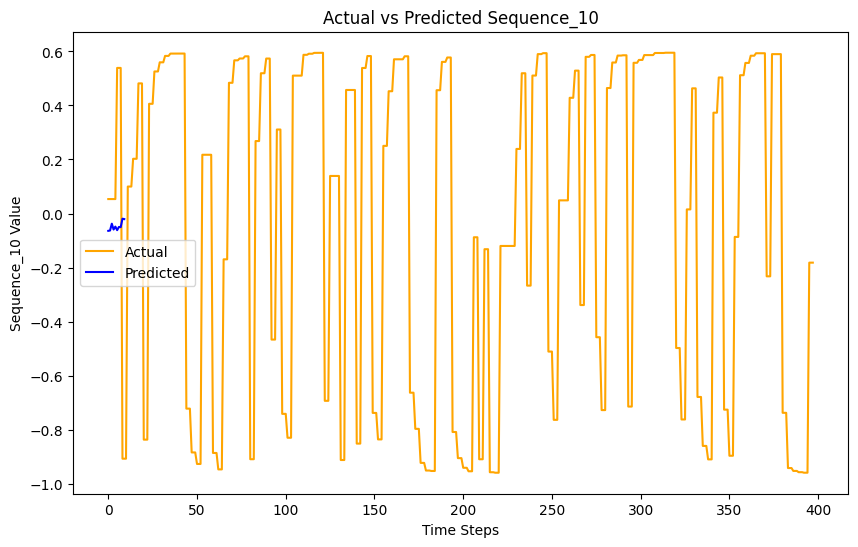

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Per GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Ensure input_dim is divisible by num_heads
def get_compatible_num_heads(input_dim):
    if input_dim % 4 == 0:
        return 4
    elif input_dim % 2 == 0:
        return 2
    else:
        return 1
nhead = get_compatible_num_heads(input_dim)
# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, nhead, num_encoder_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.fc_out = nn.Linear(input_dim, output_dim)

    def forward(self, src):
        output = self.transformer_encoder(src)
        output = self.fc_out(output[-1])
        return output

# Hyperparameter tuning with Optuna
def objective(trial):
    # Define hyperparameters
    input_dim = X_train.shape[2]
    nhead = get_compatible_num_heads(input_dim)  # Ensures nhead is compatible
    num_encoder_layers = trial.suggest_int("num_encoder_layers", 1, 4)
    dim_feedforward = trial.suggest_int("dim_feedforward", 64, 256)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    # Initialize model
    model = TransformerModel(
        input_dim=input_dim,
        output_dim=output_dim,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout
    ).to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True))

    # Training function
    train(model, X_train_tensor, y_train_tensor, criterion, optimizer, epochs, batch_size)

    # Evaluation
    _, test_loss = evaluate(model, X_test_tensor, y_test_tensor)
    return test_loss


# Run Optuna to find the best hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Retrieve and print the best parameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Initialize model with the best hyperparameters
model = TransformerModel(
    input_dim=input_dim,
    output_dim=output_dim,
    nhead=get_compatible_num_heads(input_dim),  # Ensure nhead is compatible
    num_encoder_layers=best_params["num_encoder_layers"],
    dim_feedforward=best_params["dim_feedforward"],
    dropout=best_params["dropout"]
).to(device)


# Training the final model
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"])

train(model, X_train_tensor, y_train_tensor, criterion, optimizer, epochs, batch_size)

# Save the best model
torch.save(model.state_dict(), "best_transformer_model.pth")
print("Best model saved as best_transformer_model.pth")

# Evaluation and visualization
predictions, test_loss = evaluate(model, X_test_tensor, y_test_tensor)
print(f"Test Loss (MSE) on best model: {test_loss:.4f}")
scaled_predictions = sequence_10_scaler.inverse_transform(predictions)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(sequence_10_scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual", color='orange')
plt.plot(scaled_predictions, label="Predicted", color='blue')
plt.title('Actual vs Predicted Sequence_10')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.legend()
plt.show()


In [ ]:
test_dff = dff[2000:2300]
test_df = test_dff.drop(columns=['Time of Day', 'Index', 'Sequence_1', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                        'Sequence_30', 'Sequence_40', 'Sequence_60', 'p_20', 'hl_20', 'p_30', 'hl_30', 'p_40', 'hl_40',
                        'p_60', 'hl_60', 'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240',
                        'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

In [ ]:
test_df.head()

Sequence_10        p_1       hl_1        p_2       hl_2        p_3  \
2000    -0.051026 -62.040273 -99.991096 -99.898486 -99.999716 -69.167191   
2001    -0.034915  69.168832  48.878499  30.593644   4.194670 -69.167191   
2002    -0.021487  83.988837  90.530697  30.593644   4.194670 -69.167191   
2003     0.004365  96.127786  98.890742  90.924018  92.813628  76.097049   
2004     0.053749 -30.550134  99.522753  90.924018  92.813628  76.097049   

           hl_3        p_5       hl_5       p_10      hl_10  
2000   0.050316  30.666617   0.864058 -84.794197 -96.006222  
2001   0.050316  30.666617   0.864058 -84.794197 -96.006222  
2002   0.050316  30.666617   0.864058 -84.794197 -96.006222  
2003  90.662560  30.666617   0.864058 -84.794197 -96.006222  
2004  90.662560  59.066051  67.749581 -84.794197 -96.006222

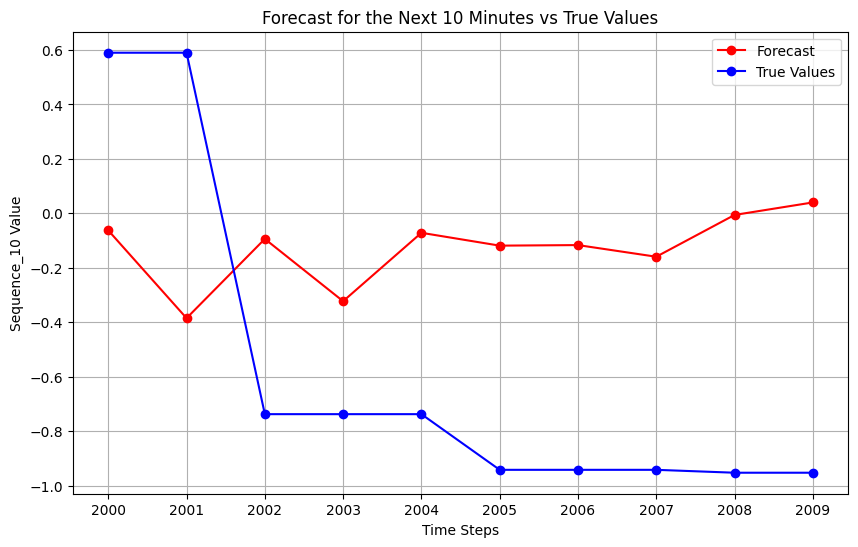

In [ ]:
# Get true future values from the dataset
true_future_values = sequence_10_scaler.inverse_transform(scaled_data[-(future_steps + window_size):-window_size, sequence_10_index].reshape(-1, 1))

# Prepare to plot the forecast and true future values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), scaled_future_forecast, marker='o', label='Forecast', color='red')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), true_future_values, marker='o', label='True Values', color='blue')
plt.title('Forecast for the Next 10 Minutes vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.xticks(np.arange(len(scaled_data), len(scaled_data) + future_steps))
plt.legend()
plt.grid()
plt.show()

In [ ]:
scaled_future_forecast

array([[-0.06262387],
       [-0.38492777],
       [-0.09387472],
       [-0.32264356],
       [-0.07143246],
       [-0.11857754],
       [-0.11653565],
       [-0.1593147 ],
       [-0.00585016],
       [ 0.04004973]])

In [ ]:
ttue20 = test_df['Sequence_10']

In [ ]:
gg

array([-0.05102555, -0.03491491, -0.02148733,  0.00436464,  0.05374863,
        0.03358252,  0.03156693,  0.03761406,  0.04668769,  0.04533944])

In [ ]:
gg = ttue20[0:10].values

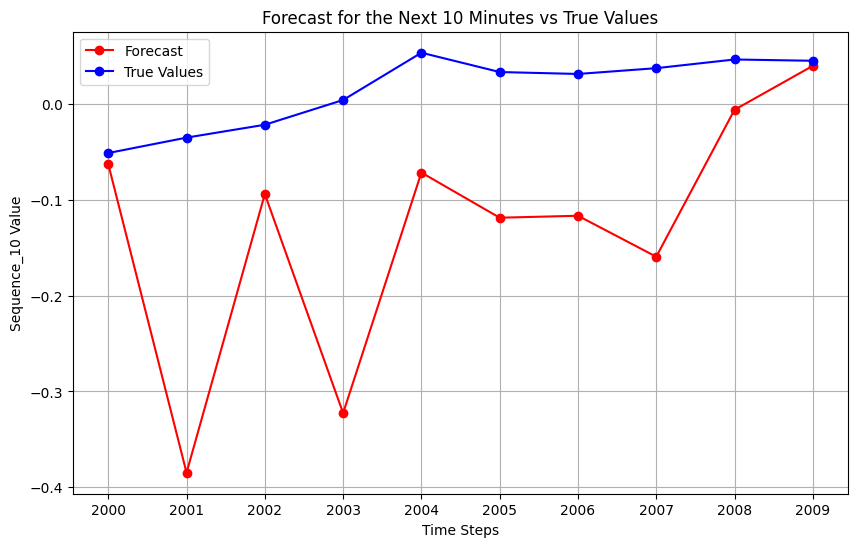

In [ ]:
# Prepare to plot the forecast and true future values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), scaled_future_forecast, marker='o', label='Forecast', color='red')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), gg, marker='o', label='True Values', color='blue')
plt.title('Forecast for the Next 10 Minutes vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.xticks(np.arange(len(scaled_data), len(scaled_data) + future_steps))
plt.legend()
plt.grid()
plt.show()

In [ ]:
test_dff = dff[5000:5200]
test_df = test_dff.drop(columns=['Time of Day', 'Index', 'Sequence_1', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                        'Sequence_30', 'Sequence_40', 'Sequence_60', 'p_20', 'hl_20', 'p_30', 'hl_30', 'p_40', 'hl_40',
                        'p_60', 'hl_60', 'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240',
                        'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

In [ ]:
test_dff = dff[5000:5200]
test_df = test_dff.drop(columns=['Sequence_1', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_10', , 'Sequence_20',
                        'Sequence_30', 'Sequence_40', 'Sequence_60', 'p_20', 'hl_20', 'p_30', 'hl_30', 'p_40', 'hl_40',
                        'p_60', 'hl_60', 'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240',
                        'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

SyntaxError: invalid syntax (<ipython-input-50-8b217cfa6fa3>, line 2)

In [ ]:
print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==-=-=-=-=-=-==---===---==---==--")
# Load the CSV file into a pandas DataFrame
dff = pd.read_csv("EEG_df.csv")

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-==-=-=-=-=-=-==---===---==---==--


In [ ]:
# Per GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Ensure input_dim is divisible by num_heads
def get_compatible_num_heads(input_dim):
    if input_dim % 4 == 0:
        return 4
    elif input_dim % 2 == 0:
        return 2
    else:
        return 1

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, nhead, num_encoder_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.fc_out = nn.Linear(input_dim, output_dim)

    def forward(self, src):
        output = self.transformer_encoder(src)
        output = self.fc_out(output[-1])
        return output

# Hyperparameter tuning with Optuna
def objective(trial):
    # Define hyperparameters
    input_dim = X_train.shape[2]
    num_heads = get_compatible_num_heads(input_dim)
    num_encoder_layers = trial.suggest_int("num_encoder_layers", 1, 4)
    dim_feedforward = trial.suggest_int("dim_feedforward", 64, 256)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    # Initialize model with compatible num_heads
    model = TransformerModel(
        input_dim=input_dim,
        output_dim=output_dim,
        nhead=num_heads,
        num_encoder_layers=num_encoder_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout
    ).to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True))

    # Training function
    train(model, X_train_tensor, y_train_tensor, criterion, optimizer, epochs, batch_size)

    # Evaluation
    _, test_loss = evaluate(model, X_test_tensor, y_test_tensor)
    return test_loss

# Run Optuna to find the best hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Retrieve and print the best parameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Initialize model with the best hyperparameters
model = TransformerModel(
    input_dim=input_dim,
    output_dim=output_dim,
    nhead=best_params["nhead"],
    num_encoder_layers=best_params["num_encoder_layers"],
    dim_feedforward=best_params["dim_feedforward"],
    dropout=best_params["dropout"]
).to(device)

# Training the final model
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"])

train(model, X_train_tensor, y_train_tensor, criterion, optimizer, epochs, batch_size)

# Save the best model
torch.save(model.state_dict(), "best_transformer_model.pth")
print("Best model saved as best_transformer_model.pth")

# Evaluation and visualization
predictions, test_loss = evaluate(model, X_test_tensor, y_test_tensor)
print(f"Test Loss (MSE) on best model: {test_loss:.4f}")
scaled_predictions = sequence_10_scaler.inverse_transform(predictions)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(sequence_10_scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual", color='orange')
plt.plot(scaled_predictions, label="Predicted", color='blue')
plt.title('Actual vs Predicted Sequence_10')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.legend()
plt.show()


[I 2024-10-26 08:54:26,845] A new study created in memory with name: no-name-c72608b1-d080-444c-8b3c-37268d15e480


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Loss: 0.1752
Epoch [2/20], Loss: 0.1922
Epoch [3/20], Loss: 0.2130
Epoch [4/20], Loss: 0.1792
Epoch [5/20], Loss: 0.2115
Epoch [6/20], Loss: 0.1781
Epoch [7/20], Loss: 0.1821
Epoch [8/20], Loss: 0.1750
Epoch [9/20], Loss: 0.1823
Epoch [10/20], Loss: 0.1805
Epoch [11/20], Loss: 0.1738
Epoch [12/20], Loss: 0.1685
Epoch [13/20], Loss: 0.1663
Epoch [14/20], Loss: 0.1540
Epoch [15/20], Loss: 0.1656
Epoch [16/20], Loss: 0.1624
Epoch [17/20], Loss: 0.1518
Epoch [18/20], Loss: 0.1506
Epoch [19/20], Loss: 0.1579


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([398])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2024-10-26 08:54:31,667] Trial 0 finished with value: 0.15983925759792328 and parameters: {'num_encoder_layers': 1, 'dim_feedforward': 72, 'dropout': 0.1954882600528873, 'learning_rate': 0.0031587931747857866}. Best is trial 0 with value: 0.15983925759792328.


Epoch [20/20], Loss: 0.1454
Epoch [1/20], Loss: 0.3382
Epoch [2/20], Loss: 0.2075
Epoch [3/20], Loss: 0.2380
Epoch [4/20], Loss: 0.1929
Epoch [5/20], Loss: 0.1726
Epoch [6/20], Loss: 0.2047
Epoch [7/20], Loss: 0.2091
Epoch [8/20], Loss: 0.1942
Epoch [9/20], Loss: 0.2175
Epoch [10/20], Loss: 0.1804
Epoch [11/20], Loss: 0.1894
Epoch [12/20], Loss: 0.1861
Epoch [13/20], Loss: 0.1882
Epoch [14/20], Loss: 0.1780
Epoch [15/20], Loss: 0.1829
Epoch [16/20], Loss: 0.1931
Epoch [17/20], Loss: 0.1600
Epoch [18/20], Loss: 0.1633
Epoch [19/20], Loss: 0.1700


[I 2024-10-26 08:54:41,068] Trial 1 finished with value: 0.16372257471084595 and parameters: {'num_encoder_layers': 4, 'dim_feedforward': 172, 'dropout': 0.47238376315148345, 'learning_rate': 0.00048062934088943836}. Best is trial 0 with value: 0.15983925759792328.


Epoch [20/20], Loss: 0.1936
Epoch [1/20], Loss: 0.4818
Epoch [2/20], Loss: 0.2458
Epoch [3/20], Loss: 0.2028
Epoch [4/20], Loss: 0.2582
Epoch [5/20], Loss: 0.2447
Epoch [6/20], Loss: 0.1811
Epoch [7/20], Loss: 0.1915
Epoch [8/20], Loss: 0.1515
Epoch [9/20], Loss: 0.1868
Epoch [10/20], Loss: 0.1800
Epoch [11/20], Loss: 0.1524
Epoch [12/20], Loss: 0.1612
Epoch [13/20], Loss: 0.2078
Epoch [14/20], Loss: 0.2037
Epoch [15/20], Loss: 0.1756
Epoch [16/20], Loss: 0.2001
Epoch [17/20], Loss: 0.1803
Epoch [18/20], Loss: 0.1533
Epoch [19/20], Loss: 0.1639


[I 2024-10-26 08:54:50,496] Trial 2 finished with value: 0.15843415260314941 and parameters: {'num_encoder_layers': 4, 'dim_feedforward': 83, 'dropout': 0.27848963162561946, 'learning_rate': 0.00019878147404507458}. Best is trial 2 with value: 0.15843415260314941.


Epoch [20/20], Loss: 0.1563
Epoch [1/20], Loss: 0.2984
Epoch [2/20], Loss: 0.1645
Epoch [3/20], Loss: 0.1795
Epoch [4/20], Loss: 0.1757
Epoch [5/20], Loss: 0.1782
Epoch [6/20], Loss: 0.1598
Epoch [7/20], Loss: 0.1617
Epoch [8/20], Loss: 0.1825
Epoch [9/20], Loss: 0.1645
Epoch [10/20], Loss: 0.1927
Epoch [11/20], Loss: 0.1968
Epoch [12/20], Loss: 0.1589
Epoch [13/20], Loss: 0.1553
Epoch [14/20], Loss: 0.1851
Epoch [15/20], Loss: 0.1667
Epoch [16/20], Loss: 0.1470
Epoch [17/20], Loss: 0.1474
Epoch [18/20], Loss: 0.1747
Epoch [19/20], Loss: 0.1672


[I 2024-10-26 08:54:52,841] Trial 3 finished with value: 0.16100837290287018 and parameters: {'num_encoder_layers': 1, 'dim_feedforward': 242, 'dropout': 0.30053488286401764, 'learning_rate': 0.0004395677285999096}. Best is trial 2 with value: 0.15843415260314941.


Epoch [20/20], Loss: 0.1650
Epoch [1/20], Loss: 0.2566
Epoch [2/20], Loss: 0.2277
Epoch [3/20], Loss: 0.2032
Epoch [4/20], Loss: 0.2114
Epoch [5/20], Loss: 0.2237
Epoch [6/20], Loss: 0.2021
Epoch [7/20], Loss: 0.2100
Epoch [8/20], Loss: 0.2206
Epoch [9/20], Loss: 0.2137
Epoch [10/20], Loss: 0.1999
Epoch [11/20], Loss: 0.2190
Epoch [12/20], Loss: 0.2127
Epoch [13/20], Loss: 0.2123
Epoch [14/20], Loss: 0.2100
Epoch [15/20], Loss: 0.1989
Epoch [16/20], Loss: 0.2036
Epoch [17/20], Loss: 0.2107
Epoch [18/20], Loss: 0.2059
Epoch [19/20], Loss: 0.2067


[I 2024-10-26 08:55:01,337] Trial 4 finished with value: 0.16205333173274994 and parameters: {'num_encoder_layers': 4, 'dim_feedforward': 193, 'dropout': 0.31832391498249246, 'learning_rate': 0.006846710786234199}. Best is trial 2 with value: 0.15843415260314941.


Epoch [20/20], Loss: 0.2103
Epoch [1/20], Loss: 0.1720
Epoch [2/20], Loss: 0.1736
Epoch [3/20], Loss: 0.2076
Epoch [4/20], Loss: 0.2166
Epoch [5/20], Loss: 0.2242
Epoch [6/20], Loss: 0.1962
Epoch [7/20], Loss: 0.1577
Epoch [8/20], Loss: 0.1429
Epoch [9/20], Loss: 0.1328
Epoch [10/20], Loss: 0.1315
Epoch [11/20], Loss: 0.1380
Epoch [12/20], Loss: 0.1292
Epoch [13/20], Loss: 0.1283
Epoch [14/20], Loss: 0.1353
Epoch [15/20], Loss: 0.1471
Epoch [16/20], Loss: 0.1290
Epoch [17/20], Loss: 0.1327
Epoch [18/20], Loss: 0.1272


[I 2024-10-26 08:55:04,790] Trial 5 finished with value: 0.15983664989471436 and parameters: {'num_encoder_layers': 3, 'dim_feedforward': 221, 'dropout': 0.39644254157038095, 'learning_rate': 0.006012938916927874}. Best is trial 2 with value: 0.15843415260314941.


Epoch [19/20], Loss: 0.1295
Epoch [20/20], Loss: 0.1282
Epoch [1/20], Loss: 0.2243
Epoch [2/20], Loss: 0.3010
Epoch [3/20], Loss: 0.2883
Epoch [4/20], Loss: 0.2201
Epoch [5/20], Loss: 0.2083
Epoch [6/20], Loss: 0.2353
Epoch [7/20], Loss: 0.2244
Epoch [8/20], Loss: 0.1795
Epoch [9/20], Loss: 0.1821
Epoch [10/20], Loss: 0.1765
Epoch [11/20], Loss: 0.2072
Epoch [12/20], Loss: 0.1713
Epoch [13/20], Loss: 0.1931
Epoch [14/20], Loss: 0.1744
Epoch [15/20], Loss: 0.1795
Epoch [16/20], Loss: 0.1748
Epoch [17/20], Loss: 0.1742
Epoch [18/20], Loss: 0.1859
Epoch [19/20], Loss: 0.1682


[I 2024-10-26 08:55:09,163] Trial 6 finished with value: 0.15899886190891266 and parameters: {'num_encoder_layers': 4, 'dim_feedforward': 109, 'dropout': 0.23203668969394103, 'learning_rate': 0.0001548777617543497}. Best is trial 2 with value: 0.15843415260314941.


Epoch [20/20], Loss: 0.1705
Epoch [1/20], Loss: 0.3298
Epoch [2/20], Loss: 0.2815
Epoch [3/20], Loss: 0.2292
Epoch [4/20], Loss: 0.3197
Epoch [5/20], Loss: 0.2869
Epoch [6/20], Loss: 0.2369
Epoch [7/20], Loss: 0.2628
Epoch [8/20], Loss: 0.2363
Epoch [9/20], Loss: 0.2061
Epoch [10/20], Loss: 0.2435
Epoch [11/20], Loss: 0.2047
Epoch [12/20], Loss: 0.1935
Epoch [13/20], Loss: 0.2325
Epoch [14/20], Loss: 0.2095
Epoch [15/20], Loss: 0.1714
Epoch [16/20], Loss: 0.1684
Epoch [17/20], Loss: 0.1945
Epoch [18/20], Loss: 0.2003
Epoch [19/20], Loss: 0.1782


[I 2024-10-26 08:55:13,377] Trial 7 finished with value: 0.16244494915008545 and parameters: {'num_encoder_layers': 3, 'dim_feedforward': 73, 'dropout': 0.2801490907242512, 'learning_rate': 0.00017474171138215453}. Best is trial 2 with value: 0.15843415260314941.


Epoch [20/20], Loss: 0.2302
Epoch [1/20], Loss: 0.2160
Epoch [2/20], Loss: 0.2369
Epoch [3/20], Loss: 0.1602
Epoch [4/20], Loss: 0.1891
Epoch [5/20], Loss: 0.2670
Epoch [6/20], Loss: 0.1718
Epoch [7/20], Loss: 0.1733
Epoch [8/20], Loss: 0.1654
Epoch [9/20], Loss: 0.1510
Epoch [10/20], Loss: 0.1601
Epoch [11/20], Loss: 0.1709
Epoch [12/20], Loss: 0.1955
Epoch [13/20], Loss: 0.1717
Epoch [14/20], Loss: 0.1647
Epoch [15/20], Loss: 0.1690
Epoch [16/20], Loss: 0.1550
Epoch [17/20], Loss: 0.1620
Epoch [18/20], Loss: 0.1529


[I 2024-10-26 08:55:15,073] Trial 8 finished with value: 0.15948019921779633 and parameters: {'num_encoder_layers': 1, 'dim_feedforward': 157, 'dropout': 0.35447394232593077, 'learning_rate': 0.0014391508864991884}. Best is trial 2 with value: 0.15843415260314941.


Epoch [19/20], Loss: 0.1588
Epoch [20/20], Loss: 0.1483
Epoch [1/20], Loss: 0.4414
Epoch [2/20], Loss: 0.2856
Epoch [3/20], Loss: 0.2325
Epoch [4/20], Loss: 0.2151
Epoch [5/20], Loss: 0.2055
Epoch [6/20], Loss: 0.1861
Epoch [7/20], Loss: 0.2111
Epoch [8/20], Loss: 0.1550
Epoch [9/20], Loss: 0.1616
Epoch [10/20], Loss: 0.1689
Epoch [11/20], Loss: 0.1629
Epoch [12/20], Loss: 0.1426
Epoch [13/20], Loss: 0.1665
Epoch [14/20], Loss: 0.1526
Epoch [15/20], Loss: 0.1593
Epoch [16/20], Loss: 0.1462
Epoch [17/20], Loss: 0.1367
Epoch [18/20], Loss: 0.1447


[I 2024-10-26 08:55:18,505] Trial 9 finished with value: 0.16236872971057892 and parameters: {'num_encoder_layers': 3, 'dim_feedforward': 163, 'dropout': 0.1741199861876348, 'learning_rate': 0.0002820797069823927}. Best is trial 2 with value: 0.15843415260314941.


Epoch [19/20], Loss: 0.1515
Epoch [20/20], Loss: 0.1415
Epoch [1/20], Loss: 0.4793
Epoch [2/20], Loss: 0.5081
Epoch [3/20], Loss: 0.4227
Epoch [4/20], Loss: 0.3714
Epoch [5/20], Loss: 0.3058
Epoch [6/20], Loss: 0.2781
Epoch [7/20], Loss: 0.3325
Epoch [8/20], Loss: 0.2844
Epoch [9/20], Loss: 0.2271
Epoch [10/20], Loss: 0.2317
Epoch [11/20], Loss: 0.2230
Epoch [12/20], Loss: 0.2790
Epoch [13/20], Loss: 0.2296
Epoch [14/20], Loss: 0.2339
Epoch [15/20], Loss: 0.2273
Epoch [16/20], Loss: 0.2144
Epoch [17/20], Loss: 0.2095
Epoch [18/20], Loss: 0.1788


[I 2024-10-26 08:55:21,032] Trial 10 finished with value: 0.16668690741062164 and parameters: {'num_encoder_layers': 2, 'dim_feedforward': 112, 'dropout': 0.14296742486313702, 'learning_rate': 0.00010037563451767625}. Best is trial 2 with value: 0.15843415260314941.


Epoch [19/20], Loss: 0.2126
Epoch [20/20], Loss: 0.1925
Epoch [1/20], Loss: 0.2425
Epoch [2/20], Loss: 0.1961
Epoch [3/20], Loss: 0.2020
Epoch [4/20], Loss: 0.2336
Epoch [5/20], Loss: 0.1794
Epoch [6/20], Loss: 0.1905
Epoch [7/20], Loss: 0.1653
Epoch [8/20], Loss: 0.2171
Epoch [9/20], Loss: 0.1570
Epoch [10/20], Loss: 0.1805
Epoch [11/20], Loss: 0.1804
Epoch [12/20], Loss: 0.1594
Epoch [13/20], Loss: 0.2032
Epoch [14/20], Loss: 0.1818
Epoch [15/20], Loss: 0.1758
Epoch [16/20], Loss: 0.2014
Epoch [17/20], Loss: 0.1931
Epoch [18/20], Loss: 0.1632
Epoch [19/20], Loss: 0.1624


[I 2024-10-26 08:55:26,010] Trial 11 finished with value: 0.16209465265274048 and parameters: {'num_encoder_layers': 4, 'dim_feedforward': 116, 'dropout': 0.2343885272265297, 'learning_rate': 0.00012504205897877853}. Best is trial 2 with value: 0.15843415260314941.


Epoch [20/20], Loss: 0.1479
Epoch [1/20], Loss: 0.1795
Epoch [2/20], Loss: 0.2295
Epoch [3/20], Loss: 0.1615
Epoch [4/20], Loss: 0.1746
Epoch [5/20], Loss: 0.1586
Epoch [6/20], Loss: 0.1412
Epoch [7/20], Loss: 0.1425
Epoch [8/20], Loss: 0.1518
Epoch [9/20], Loss: 0.1491
Epoch [10/20], Loss: 0.1404
Epoch [11/20], Loss: 0.1391
Epoch [12/20], Loss: 0.1397
Epoch [13/20], Loss: 0.1344
Epoch [14/20], Loss: 0.1338
Epoch [15/20], Loss: 0.1294
Epoch [16/20], Loss: 0.1280
Epoch [17/20], Loss: 0.1353
Epoch [18/20], Loss: 0.1310
Epoch [19/20], Loss: 0.1312


[I 2024-10-26 08:55:31,004] Trial 12 finished with value: 0.15895989537239075 and parameters: {'num_encoder_layers': 4, 'dim_feedforward': 110, 'dropout': 0.10878017954218838, 'learning_rate': 0.0008481784914585068}. Best is trial 2 with value: 0.15843415260314941.


Epoch [20/20], Loss: 0.1272
Epoch [1/20], Loss: 0.2422
Epoch [2/20], Loss: 0.1675
Epoch [3/20], Loss: 0.1626
Epoch [4/20], Loss: 0.1529
Epoch [5/20], Loss: 0.1401
Epoch [6/20], Loss: 0.1414
Epoch [7/20], Loss: 0.1438
Epoch [8/20], Loss: 0.1478
Epoch [9/20], Loss: 0.1532
Epoch [10/20], Loss: 0.1397
Epoch [11/20], Loss: 0.1401
Epoch [12/20], Loss: 0.1408
Epoch [13/20], Loss: 0.1435
Epoch [14/20], Loss: 0.1350
Epoch [15/20], Loss: 0.1355
Epoch [16/20], Loss: 0.1345
Epoch [17/20], Loss: 0.1315
Epoch [18/20], Loss: 0.1320
Epoch [19/20], Loss: 0.1308


[I 2024-10-26 08:55:33,532] Trial 13 finished with value: 0.16784213483333588 and parameters: {'num_encoder_layers': 2, 'dim_feedforward': 94, 'dropout': 0.11257215053700925, 'learning_rate': 0.0009672184301945132}. Best is trial 2 with value: 0.15843415260314941.


Epoch [20/20], Loss: 0.1298
Epoch [1/20], Loss: 0.3590
Epoch [2/20], Loss: 0.2692
Epoch [3/20], Loss: 0.2032
Epoch [4/20], Loss: 0.1546
Epoch [5/20], Loss: 0.1737
Epoch [6/20], Loss: 0.2004
Epoch [7/20], Loss: 0.1937
Epoch [8/20], Loss: 0.1792
Epoch [9/20], Loss: 0.2092
Epoch [10/20], Loss: 0.1969
Epoch [11/20], Loss: 0.1612
Epoch [12/20], Loss: 0.1956
Epoch [13/20], Loss: 0.1705
Epoch [14/20], Loss: 0.1897
Epoch [15/20], Loss: 0.1606
Epoch [16/20], Loss: 0.1840
Epoch [17/20], Loss: 0.1740
Epoch [18/20], Loss: 0.1731


[I 2024-10-26 08:55:36,954] Trial 14 finished with value: 0.160450279712677 and parameters: {'num_encoder_layers': 3, 'dim_feedforward': 135, 'dropout': 0.4245502801428574, 'learning_rate': 0.0011609722142672922}. Best is trial 2 with value: 0.15843415260314941.


Epoch [19/20], Loss: 0.1864
Epoch [20/20], Loss: 0.1987
Epoch [1/20], Loss: 0.1906
Epoch [2/20], Loss: 0.2116
Epoch [3/20], Loss: 0.2178
Epoch [4/20], Loss: 0.1805
Epoch [5/20], Loss: 0.2015
Epoch [6/20], Loss: 0.1893
Epoch [7/20], Loss: 0.1799
Epoch [8/20], Loss: 0.1694
Epoch [9/20], Loss: 0.1542
Epoch [10/20], Loss: 0.1537
Epoch [11/20], Loss: 0.1396
Epoch [12/20], Loss: 0.1354
Epoch [13/20], Loss: 0.1330
Epoch [14/20], Loss: 0.1301
Epoch [15/20], Loss: 0.1320
Epoch [16/20], Loss: 0.1305
Epoch [17/20], Loss: 0.1301
Epoch [18/20], Loss: 0.1291
Epoch [19/20], Loss: 0.1327


[I 2024-10-26 08:55:42,436] Trial 15 finished with value: 0.1655925214290619 and parameters: {'num_encoder_layers': 4, 'dim_feedforward': 137, 'dropout': 0.10426652552334287, 'learning_rate': 0.0005981080077302203}. Best is trial 2 with value: 0.15843415260314941.


Epoch [20/20], Loss: 0.1287
Epoch [1/20], Loss: 0.2478
Epoch [2/20], Loss: 0.1987
Epoch [3/20], Loss: 0.1956
Epoch [4/20], Loss: 0.2127
Epoch [5/20], Loss: 0.2546
Epoch [6/20], Loss: 0.2259
Epoch [7/20], Loss: 0.2181
Epoch [8/20], Loss: 0.2018
Epoch [9/20], Loss: 0.2050
Epoch [10/20], Loss: 0.1996
Epoch [11/20], Loss: 0.1951
Epoch [12/20], Loss: 0.1893
Epoch [13/20], Loss: 0.1638
Epoch [14/20], Loss: 0.1522
Epoch [15/20], Loss: 0.1359
Epoch [16/20], Loss: 0.1295
Epoch [17/20], Loss: 0.1315
Epoch [18/20], Loss: 0.1300
Epoch [19/20], Loss: 0.1298


[I 2024-10-26 08:55:46,808] Trial 16 finished with value: 0.15861472487449646 and parameters: {'num_encoder_layers': 4, 'dim_feedforward': 91, 'dropout': 0.24483890330256458, 'learning_rate': 0.003150992728762745}. Best is trial 2 with value: 0.15843415260314941.


Epoch [20/20], Loss: 0.1283
Epoch [1/20], Loss: 0.1621
Epoch [2/20], Loss: 0.2352
Epoch [3/20], Loss: 0.1966
Epoch [4/20], Loss: 0.1856
Epoch [5/20], Loss: 0.1760
Epoch [6/20], Loss: 0.1880
Epoch [7/20], Loss: 0.1949
Epoch [8/20], Loss: 0.1680
Epoch [9/20], Loss: 0.1647
Epoch [10/20], Loss: 0.1848
Epoch [11/20], Loss: 0.1819
Epoch [12/20], Loss: 0.1785
Epoch [13/20], Loss: 0.1525
Epoch [14/20], Loss: 0.1541
Epoch [15/20], Loss: 0.1511
Epoch [16/20], Loss: 0.1510
Epoch [17/20], Loss: 0.1462
Epoch [18/20], Loss: 0.1417
Epoch [19/20], Loss: 0.1427


[I 2024-10-26 08:55:49,393] Trial 17 finished with value: 0.16061976552009583 and parameters: {'num_encoder_layers': 2, 'dim_feedforward': 66, 'dropout': 0.24768976260888337, 'learning_rate': 0.0020336103541520197}. Best is trial 2 with value: 0.15843415260314941.


Epoch [20/20], Loss: 0.1452
Epoch [1/20], Loss: 0.1743
Epoch [2/20], Loss: 0.2122
Epoch [3/20], Loss: 0.2184
Epoch [4/20], Loss: 0.2127
Epoch [5/20], Loss: 0.1840
Epoch [6/20], Loss: 0.1917
Epoch [7/20], Loss: 0.1861
Epoch [8/20], Loss: 0.1627
Epoch [9/20], Loss: 0.1684
Epoch [10/20], Loss: 0.1428
Epoch [11/20], Loss: 0.1472
Epoch [12/20], Loss: 0.1455
Epoch [13/20], Loss: 0.1335
Epoch [14/20], Loss: 0.1341
Epoch [15/20], Loss: 0.1303
Epoch [16/20], Loss: 0.1281
Epoch [17/20], Loss: 0.1307
Epoch [18/20], Loss: 0.1309
Epoch [19/20], Loss: 0.1290


[I 2024-10-26 08:55:53,396] Trial 18 finished with value: 0.1590096354484558 and parameters: {'num_encoder_layers': 3, 'dim_feedforward': 93, 'dropout': 0.35504172508565884, 'learning_rate': 0.0034620067511262976}. Best is trial 2 with value: 0.15843415260314941.


Epoch [20/20], Loss: 0.1306
Epoch [1/20], Loss: 0.1967
Epoch [2/20], Loss: 0.2036
Epoch [3/20], Loss: 0.2265
Epoch [4/20], Loss: 0.1999
Epoch [5/20], Loss: 0.1993
Epoch [6/20], Loss: 0.1810
Epoch [7/20], Loss: 0.1675
Epoch [8/20], Loss: 0.1482
Epoch [9/20], Loss: 0.1406
Epoch [10/20], Loss: 0.1345
Epoch [11/20], Loss: 0.1355
Epoch [12/20], Loss: 0.1273
Epoch [13/20], Loss: 0.1300
Epoch [14/20], Loss: 0.1284
Epoch [15/20], Loss: 0.1272
Epoch [16/20], Loss: 0.1261
Epoch [17/20], Loss: 0.1276
Epoch [18/20], Loss: 0.1278
Epoch [19/20], Loss: 0.1303


[I 2024-10-26 08:55:58,422] Trial 19 finished with value: 0.16114141047000885 and parameters: {'num_encoder_layers': 4, 'dim_feedforward': 89, 'dropout': 0.27040318173974165, 'learning_rate': 0.002554353207088675}. Best is trial 2 with value: 0.15843415260314941.


Epoch [20/20], Loss: 0.1269
Best hyperparameters: {'num_encoder_layers': 4, 'dim_feedforward': 83, 'dropout': 0.27848963162561946, 'learning_rate': 0.00019878147404507458}


KeyError: 'nhead'

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, nhead=4, num_encoder_layers=3, dim_feedforward=128, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.fc_out = nn.Linear(input_dim, output_dim)

    def forward(self, src):
        # Pass input through transformer encoder
        output = self.transformer_encoder(src)
        output = self.fc_out(output[-1])  # Take the last output (corresponding to the forecast)
        return output

# Define objective function for Optuna
def objective(trial):
    # Hyperparameter search space
    nhead = trial.suggest_categorical('nhead', [2, 4, 8])

    # Set the embedding dimension
    embed_dim = trial.suggest_int('embed_dim', 16, 128)

    # Ensure embed_dim is divisible by nhead
    if embed_dim % nhead != 0:
        embed_dim += nhead - (embed_dim % nhead)  # Adjust embed_dim to the next multiple of nhead

    num_encoder_layers = trial.suggest_int('num_encoder_layers', 1, 4)
    dim_feedforward = trial.suggest_int('dim_feedforward', 64, 256)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    # Initialize the model
    model = TransformerModel(input_dim=embed_dim, output_dim=1,  # Change output_dim to 1 for regression
                             nhead=nhead, num_encoder_layers=num_encoder_layers,
                             dim_feedforward=dim_feedforward, dropout=dropout).to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    epochs = 20
    batch_size = 64

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for i in range(0, len(X_train_tensor), batch_size):
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]

            # Ensure input is of shape (sequence_length, batch_size, input_dim)
            if len(X_batch.shape) != 3:
                X_batch = X_batch.unsqueeze(1)  # Adjust if necessary

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation (test) loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs, y_test_tensor).item()

    return val_loss  # Objective to minimize validation loss

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_trial = study.best_trial
print("Best hyperparameters:", best_trial.params)

# Train the model with best hyperparameters
best_model = TransformerModel(input_dim=best_trial.params['embed_dim'], output_dim=1,
                              nhead=best_trial.params['nhead'],
                              num_encoder_layers=best_trial.params['num_encoder_layers'],
                              dim_feedforward=best_trial.params['dim_feedforward'],
                              dropout=best_trial.params['dropout']).to(device)

# Best model optimizer and criterion
best_optimizer = optim.Adam(best_model.parameters(), lr=best_trial.params['learning_rate'])
criterion = nn.MSELoss()

# Training the best model
def train_best_model(model, optimizer, criterion, epochs, batch_size):
    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train_tensor), batch_size):
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]

            # Ensure input is of shape (sequence_length, batch_size, input_dim)
            if len(X_batch.shape) != 3:
                X_batch = X_batch.unsqueeze(1)  # Adjust if necessary

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Train and save the best model
epochs = 30  # Adjust as necessary
train_best_model(best_model, best_optimizer, criterion, epochs, batch_size)

# Save the best model and the scaler for predictions
torch.save(best_model.state_dict(), 'best_transformer_model.pth')

# Save the scaler (for inverse transformation later)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the Optuna study results for later reference
with open('optuna_study.pkl', 'wb') as f:
    pickle.dump(study, f)

print("Best model and scalers saved.")


[I 2024-10-25 15:33:19,719] A new study created in memory with name: no-name-ffc1406d-617a-4080-b610-388edc634caf
<ipython-input-100-fc4e4d8838b7>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
<ipython-input-100-fc4e4d8838b7>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[W 2024-10-25

AssertionError: was expecting embedding dimension of 32, but got 11

In [ ]:
# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, nhead=4, num_encoder_layers=3, dim_feedforward=128, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.fc_out = nn.Linear(input_dim, output_dim)

    def forward(self, src):
        # Pass input through transformer encoder
        output = self.transformer_encoder(src)
        output = self.fc_out(output[-1])  # Take the last output (corresponding to the forecast)
        return output

# Define objective function for Optuna
# Define objective function for Optuna
def objective(trial):
    # Hyperparameter search space
    nhead = trial.suggest_categorical('nhead', [2, 4, 8])

    # Calculate embed_dim based on nhead to ensure divisibility
    base_dim = trial.suggest_int('base_dim', 8, 16)  # Choose a base dimension
    embed_dim = nhead * base_dim  # embed_dim is now guaranteed to be divisible by nhead

    num_encoder_layers = trial.suggest_int('num_encoder_layers', 1, 4)
    dim_feedforward = trial.suggest_int('dim_feedforward', 64, 256)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    # Initialize the model
    model = TransformerModel(input_dim=input_dim, output_dim=output_dim,
                             nhead=nhead, num_encoder_layers=num_encoder_layers,
                             dim_feedforward=dim_feedforward, dropout=dropout).to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    epochs = 20
    batch_size = 64

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for i in range(0, len(X_train_tensor), batch_size):
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation (test) loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs, y_test_tensor).item()

    return val_loss  # Objective to minimize validation loss

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_trial = study.best_trial
print("Best hyperparameters:", best_trial.params)

# Train the model with best hyperparameters
best_model = TransformerModel(input_dim=input_dim, output_dim=output_dim,
                              nhead=best_trial.params['nhead'],
                              num_encoder_layers=best_trial.params['num_encoder_layers'],
                              dim_feedforward=best_trial.params['dim_feedforward'],
                              dropout=best_trial.params['dropout']).to(device)

# Best model optimizer and criterion
best_optimizer = optim.Adam(best_model.parameters(), lr=best_trial.params['learning_rate'])
criterion = nn.MSELoss()

# Training the best model
def train_best_model(model, optimizer, criterion, epochs, batch_size):
    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train_tensor), batch_size):
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Train and save the best model
epochs = 30  # Adjust as necessary
train_best_model(best_model, best_optimizer, criterion, epochs, batch_size)

# Save the best model and the scaler for predictions
torch.save(best_model.state_dict(), 'best_transformer_model.pth')

# Save the scaler (for inverse transformation later)
with open('sequence_10_scaler.pkl', 'wb') as f:
    pickle.dump(sequence_10_scaler, f)

# Save the Optuna study results for later reference
with open('optuna_study.pkl', 'wb') as f:
    pickle.dump(study, f)

print("Best model and scalers saved.")



[I 2024-10-25 15:21:05,736] A new study created in memory with name: no-name-69056585-b231-4c10-9a0a-32377ef01948
<ipython-input-84-b7d9bb233b31>:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
<ipython-input-84-b7d9bb233b31>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[W 2024-10-25 15:21:05,742] Trial 0 failed with parameters: {'nhead': 4, 'base_dim': 11, 'num_encoder_layers': 3, 'dim_feedforward': 209, 'dropout': 0.3914729409153985, 'learning_rate': 0.00013452904854774087} because of the following error: AssertionError('embed_dim must be divisible by num_he

AssertionError: embed_dim must be divisible by num_heads

In [ ]:
# Extract the CSV file assuming there's only one file in the zip
with zipfile.ZipFile(f"{folder_path}/{zip_file}", 'r') as zip_ref:
    zip_ref.extractall(folder_path)
    csv_file = zip_ref.namelist()[0]

# Specify the desired columns to read from the CSV
desired_columns = ['Time of Day', 'Index', 'Sequence_1', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_10', 'Sequence_20', 'Sequence_30',
                   'Sequence_40', 'Sequence_60', 'p_1', 'hl_1', 'p_2', 'hl_2', 'p_3',
                   'hl_3', 'p_5', 'hl_5', 'p_10', 'hl_10', 'p_20', 'hl_20', 'p_30',
                   'hl_30', 'p_40', 'hl_40', 'p_60', 'hl_60', 'p_90', 'hl_90', 'p_120',
                   'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240', 'p_360', 'hl_360',
                   'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440']

# Read the CSV file into a pandas DataFrame
dff = pd.read_csv(f"{folder_path}/{csv_file}", usecols=desired_columns)

In [ ]:
df = dff
print(df.head())

  Time of Day    Index  Sequence_1  Sequence_2  Sequence_3  Sequence_5  \
0    00:00:00  3896410    0.007191    0.006506    0.000342   -0.002054   
1    00:01:00  3896411   -0.006163    0.001027    0.000342   -0.007191   
2    00:02:00  3896412    0.003767   -0.002397    0.004794   -0.002054   
3    00:03:00  3896413    0.015751    0.019519    0.013354    0.019861   
4    00:04:00  3896414   -0.018488   -0.002739    0.001027    0.002055   

   Sequence_10  Sequence_20  Sequence_30  Sequence_40  ...      p_240  \
0     0.008903     0.017808     0.110721     0.124793  ...  76.791578   
1     0.025346    -0.003767     0.109698     0.147462  ...  76.791578   
2     0.024318     0.002739     0.130975     0.148830  ...  76.791578   
3     0.039045     0.008560     0.154645     0.178003  ...  76.791578   
4     0.020550    -0.021911     0.135785     0.168758  ...  76.791578   

     hl_240      p_360     hl_360      p_480     hl_480      p_720     hl_720  \
0  64.64856  78.042513  52.359906  

In [ ]:
df = dff[0:20600]

In [ ]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Extract 'Sequence_10' as a 1D array (unscaled or scaled as needed)
sequence_10 = df['Sequence_10'].values  # Use df['Sequence_10'] directly if it's not scaled

# If you're applying the test on scaled data, use this line instead:
# sequence_10 = scaled_sequence_10.flatten()

# Check stationarity with Augmented Dickey-Fuller test
result = adfuller(sequence_10)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -20.99443677670771
p-value: 0.0


In [ ]:
with tf.device('/GPU:0'):
  sequence_10 = df['Sequence_10'].values
  result = adfuller(sequence_10)
  print(f'ADF Statistic: {result[0]}')
  print(f'p-value: {result[1]}')

ADF Statistic: -20.99443677670771
p-value: 0.0


ADF Statistic: -20.99443677670771
p-value: 0.0
ADF Statistic: -20.99443677670771
p-value: 0.0


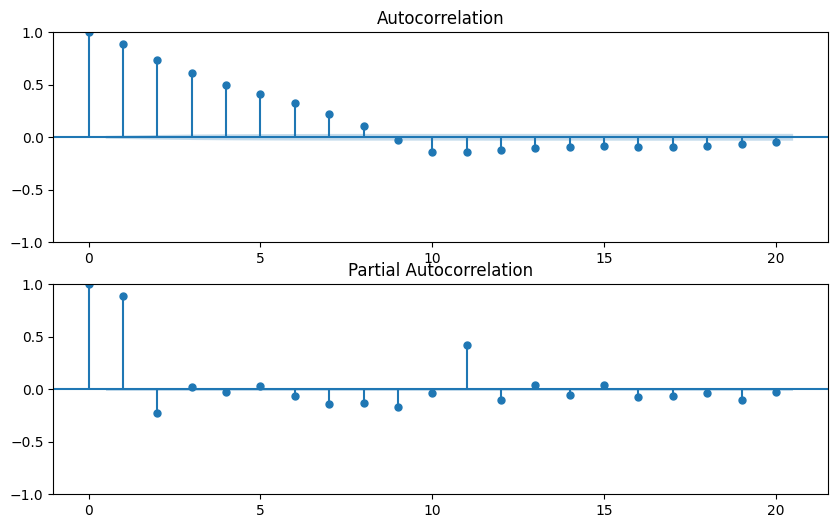

In [ ]:
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
#result = adfuller(X)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Plot ACF and PACF to identify p and q
plt.figure(figsize=(10, 6))
plt.subplot(211)
plot_acf(sequence_10, lags=20, ax=plt.gca())
plt.subplot(212)
plot_pacf(sequence_10, lags=20, ax=plt.gca())
plt.show()

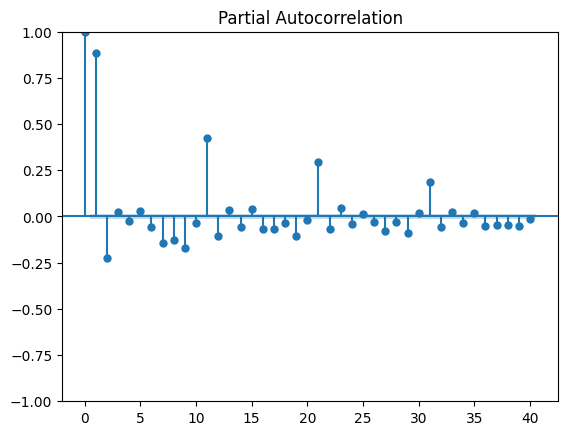

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Plot PACF to determine p
plot_pacf(sequence_10, lags=40)
plt.show()

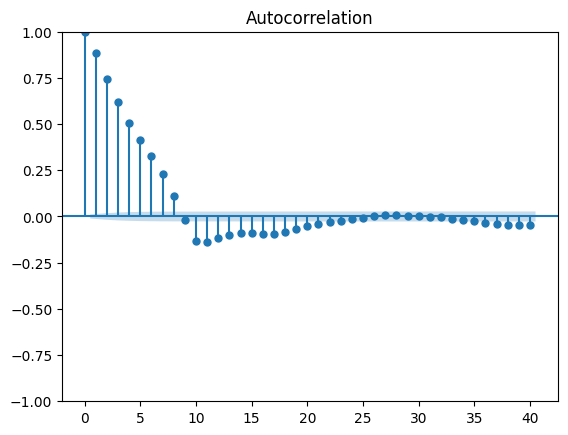

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF to determine q
plot_acf(sequence_10, lags=40)
plt.show()

ADF Statistic: -22.70711501409145
p-value: 0.0
ADF Statistic: -22.70711501409145
p-value: 0.0


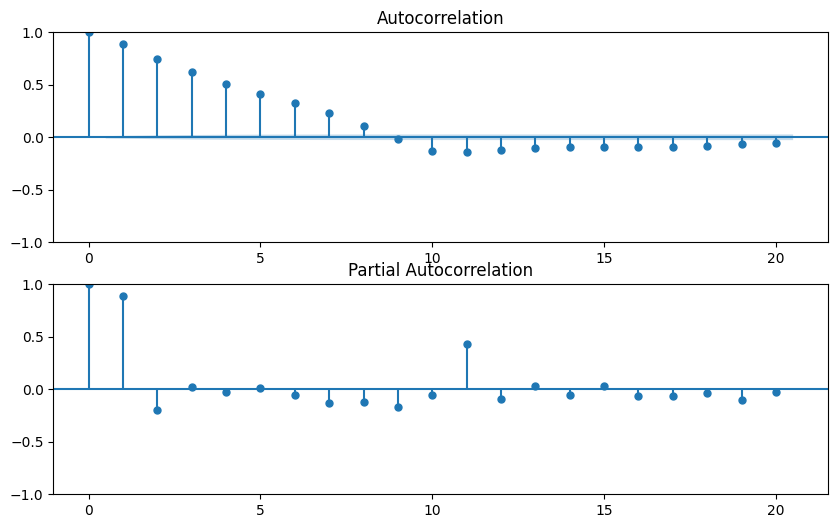

In [ ]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

result = adfuller(sequence_10)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
#result = adfuller(X)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Plot ACF and PACF to identify p and q
plt.figure(figsize=(10, 6))
plt.subplot(211)
plot_acf(sequence_10, lags=20, ax=plt.gca())
plt.subplot(212)
plot_pacf(sequence_10, lags=20, ax=plt.gca())
plt.show()

ADF Statistic: -22.70711501409145
p-value: 0.0
The time series is stationary.


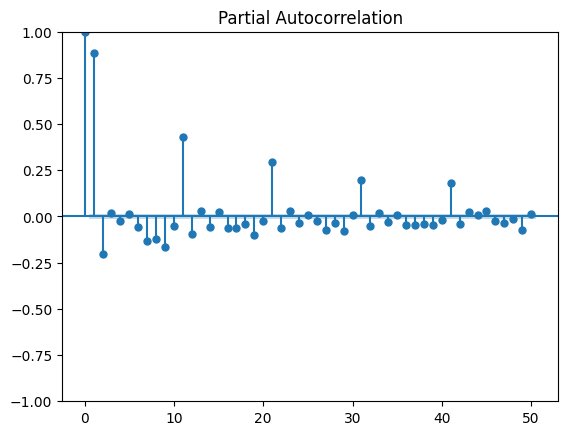

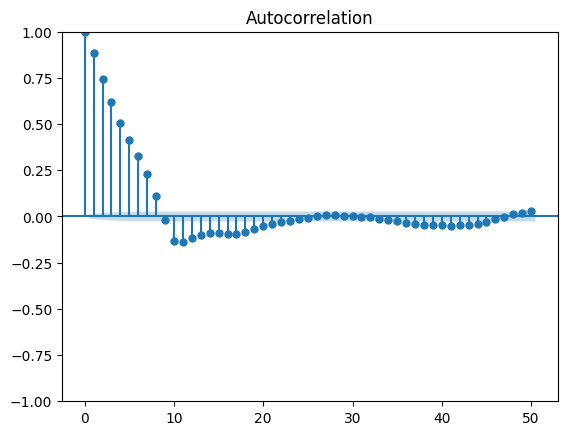

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Select a specific time series column, e.g., 'Sequence_10'
sequence_10 = df['Sequence_10']

# Check stationarity with Augmented Dickey-Fuller test
result = adfuller(sequence_10)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")



from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# PACF plot to determine p
plot_pacf(sequence_10, lags=50)
plt.show()


from statsmodels.graphics.tsaplots import plot_acf

# ACF plot to determine q
plot_acf(sequence_10, lags=50)
plt.show()

In [ ]:
#features = ['Sequence_10', 'p_1', 'p_2', 'p_3', 'p_5', 'hl_5', 'p_10', 'p_20']
#target = 'Sequence_10'

In [56]:
df.columns

Index(['p_1', 'p_2', 'hl_1', 'hl_2', 'p_5', 'hl_5', 'p_10', 'hl_10', 'p_20',
       'hl_20', 'p_30', 'hl_30', 'p_40', 'hl_40', 'p_60', 'hl_60', 'p_90',
       'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240',
       'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440',
       'hl_1440', 'Time of Day', 'Sequence_1', 'Sequence_2', 'Sequence_3',
       'Sequence_5', 'Sequence_10', 'Sequence_20', 'Sequence_30',
       'Sequence_40', 'Sequence_60'],
      dtype='object')

In [ ]:
# Data preparation with GPU context
with tf.device('/GPU:0'):
    # Drop unnecessary columns like 'Time of Day' and 'Index'
    data = df.drop(columns=['Time of Day', 'Index', 'Sequence_1', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                            'Sequence_30', 'Sequence_40', 'Sequence_60', 'p_20', 'hl_20', 'p_30', 'hl_30', 'p_40', 'hl_40',
                            'p_60', 'hl_60', 'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240', 'p_360',
                            'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Prepare the input sequences and labels for LSTM
    # Create a scaler for 'Sequence_10' only
    sequence_10_scaler = MinMaxScaler(feature_range=(0, 1))


    # Fit the scaler on 'Sequence_10'
    scaled_sequence_10 = sequence_10_scaler.fit_transform(data[['Sequence_10']])

    # Prepare the input sequences and labels for LSTM
    # Update the create_sequences function to only consider the target variable for 'y'
    def create_sequences(data, window_size, target_column):
        X = []
        y = []
        for i in range(len(data) - window_size):
           X.append(data[i:i + window_size, :])  # All features for X
           y.append(data[i + window_size, target_column])  # Only the target feature for y
        return np.array(X), np.array(y)

    # Prepare sequences with the correct column index for 'Sequence_10'
    sequence_10_index = df.columns.get_loc('Sequence_10')
    window_size = 10  # 10 minutes window size
    X, y = create_sequences(scaled_data, window_size, sequence_10_index)

    # Split into train and test sets
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.02))
    model.add(LSTM(16, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(16))
    model.add(Dense(1))

    #model = Sequential()
    #model.add(LSTM(100, return_sequences=True, input_shape=(window_size, X.shape[2])))
    #model.add(LSTM(50, return_sequences=False))
    #model.add(Dense(25))
    #model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test))

    # Make predictions
    predictions = model.predict(X_test)

    # Inverse transform the predictions using the 'Sequence_10' scaler
    scaled_predictions = sequence_10_scaler.inverse_transform(predictions)

    # Evaluate model performance
    mse = model.evaluate(X_test, y_test)
    print(f"Mean Squared Error: {mse}")

    # Forecast the next 10 minutes
    def forecast_future(data, model, window_size, future_steps, target_index):
      future_forecast = []
      current_sequence = data[-window_size:]  # Start with the last available window

      for _ in range(future_steps):
        # Predict the next step
        next_step = model.predict(current_sequence[np.newaxis, :, :])

        # Append the forecast to the future forecast list
        future_forecast.append(next_step[0, 0])  # Predict only 'Sequence_10'

        # Create a new sequence with predicted value
        # Use the predicted value for 'Sequence_10' and keep other features as they were
        next_sequence = np.copy(current_sequence)  # Copy the current sequence
        next_sequence = np.roll(next_sequence, -1, axis=0)  # Shift the sequence by 1
        next_sequence[-1, target_index] = next_step  # Update only 'Sequence_10'

        # Replace current_sequence with the updated sequence for next prediction
        current_sequence = next_sequence

      return np.array(future_forecast)

    future_steps = 10  # Forecasting the next 10 minutes
    #future_forecast = forecast_future(scaled_data, model, window_size, future_steps)
    future_forecast = forecast_future(scaled_data, model, window_size, future_steps, sequence_10_index)

    # Inverse scale the future forecast
    #future_forecast_scaled = scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1))

    scaled_future_forecast = sequence_10_scaler.inverse_transform(future_forecast.reshape(-1, 1))

    print("Forecast for the next 10 minutes:", scaled_future_forecast)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
13140/13140 ━━━━━━━━━━━━━━━━━━━━ 101s 7ms/step - loss: 0.0412 - val_loss: 0.0196
Epoch 2/30
13140/13140 ━━━━━━━━━━━━━━━━━━━━ 138s 7ms/step - loss: 0.0187 - val_loss: 0.0159
Epoch 3/30
13140/13140 ━━━━━━━━━━━━━━━━━━━━ 93s 7ms/step - loss: 0.0168 - val_loss: 0.0160
Epoch 4/30
13140/13140 ━━━━━━━━━━━━━━━━━━━━ 173s 9ms/step - loss: 0.0163 - val_loss: 0.0152
Epoch 5/30
13140/13140 ━━━━━━━━━━━━━━━━━━━━ 120s 8ms/step - loss: 0.0158 - val_loss: 0.0151
Epoch 6/30
13140/13140 ━━━━━━━━━━━━━━━━━━━━ 154s 9ms/step - loss: 0.0153 - val_loss: 0.0143
Epoch 7/30
13140/13140 ━━━━━━━━━━━━━━━━━━━━ 99s 7ms/step - loss: 0.0151 - val_loss: 0.0143
Epoch 8/30
13140/13140 ━━━━━━━━━━━━━━━━━━━━ 138s 7ms/step - loss: 0.0148 - val_loss: 0.0138
Epoch 9/30
13140/13140 ━━━━━━━━━━━━━━━━━━━━ 141s 7ms/step - loss: 0.0144 - val_loss: 0.0135
Epoch 10/30
13140/13140 ━━━━━━━━━━━━━━━━━━━━ 147s 8ms/step - loss: 0.0141 - val_loss: 0.0134
Epoch 11/30
13140/13140 ━━━━━━━━━━━━━━━━━━━━ 169s 10ms/step - loss: 0.0140 - val_

<ipython-input-23-eea91459cae9>:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_sequence[-1, target_index] = next_step  # Update only 'Sequence_10'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Forecast for the next 10 minutes: [[ 5.886554 ]
 [ 5.8759246]
 [-3.7233465]
 [-4.932879 ]
 [-4.7249994]
 [-7.6275344]
 [-7.425669 ]
 [-6.8449645]
 [ 2.3538966]
 [ 2.3714256]]


In [ ]:
# Visualize the predictions
predictions = model.predict(X_test)
scaled_predictions = sequence_10_scaler.inverse_transform(predictions)

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(sequence_10_scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual")
plt.plot(scaled_predictions, label="Predicted")
plt.title('Actual vs Predicted Sequence_10')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.legend()
#plt.show()
plt.savefig('fig4_.pdf', format='pdf')
plt.close()

# Forecast the next 10 minutes
def forecast_future(data, model, window_size, future_steps, target_index):
    future_forecast = []
    current_sequence = data[-window_size:]  # Start with the last available window

    for _ in range(future_steps):
        next_step = model.predict(current_sequence[np.newaxis, :, :])
        future_forecast.append(next_step[0, 0])  # Predict only 'Sequence_10'

        next_sequence = np.copy(current_sequence)
        next_sequence = np.roll(next_sequence, -1, axis=0)  # Shift the sequence by 1
        next_sequence[-1, target_index] = next_step  # Update 'Sequence_10'

        current_sequence = next_sequence

    return np.array(future_forecast)

# Forecast future steps
future_steps = 2
future_forecast = forecast_future(scaled_data, model, window_size, future_steps, sequence_10_index)
scaled_future_forecast = sequence_10_scaler.inverse_transform(future_forecast.reshape(-1, 1))

# Plot future forecast
plt.figure(figsize=(10, 6))
plt.plot(scaled_future_forecast, label='Future Forecast')
plt.title('Forecast for the next 10 minutes')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Forecast Value')
plt.legend()
#plt.show()
plt.savefig('fig5.pdf', format='pdf')
plt.close()

AttributeError: 'TransformerModel' object has no attribute 'predict'

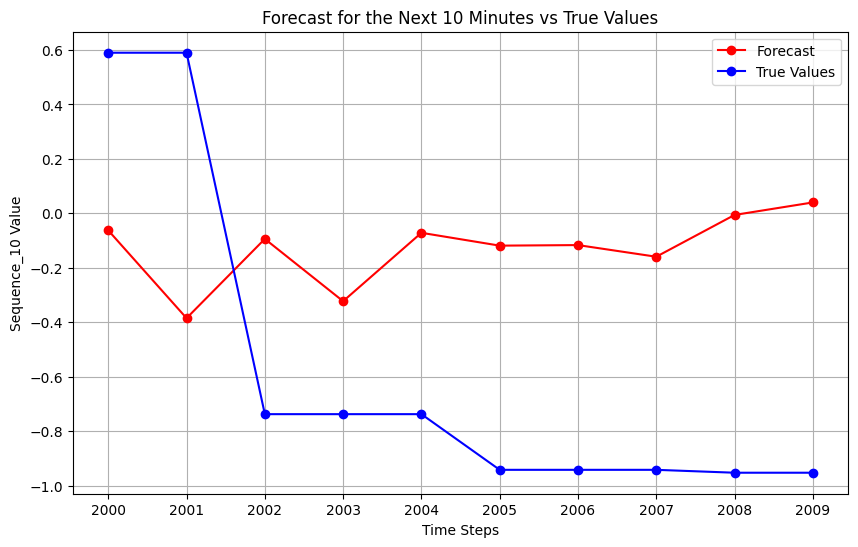

In [ ]:
# Get true future values from the dataset
true_future_values = sequence_10_scaler.inverse_transform(scaled_data[-(future_steps + window_size):-window_size, sequence_10_index].reshape(-1, 1))

# Prepare to plot the forecast and true future values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), scaled_future_forecast, marker='o', label='Forecast', color='red')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), true_future_values, marker='o', label='True Values', color='blue')
plt.title('Forecast for the Next 10 Minutes vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.xticks(np.arange(len(scaled_data), len(scaled_data) + future_steps))
plt.legend()
plt.grid()
plt.show()

3285/3285 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step


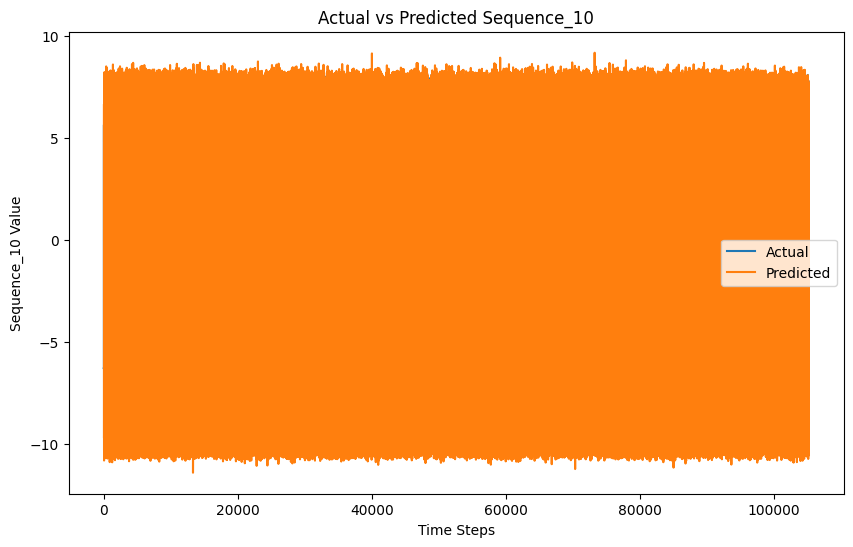

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-25-22439487ae6e>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_sequence[-1, target_index] = next_step  # Update 'Sequence_10'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


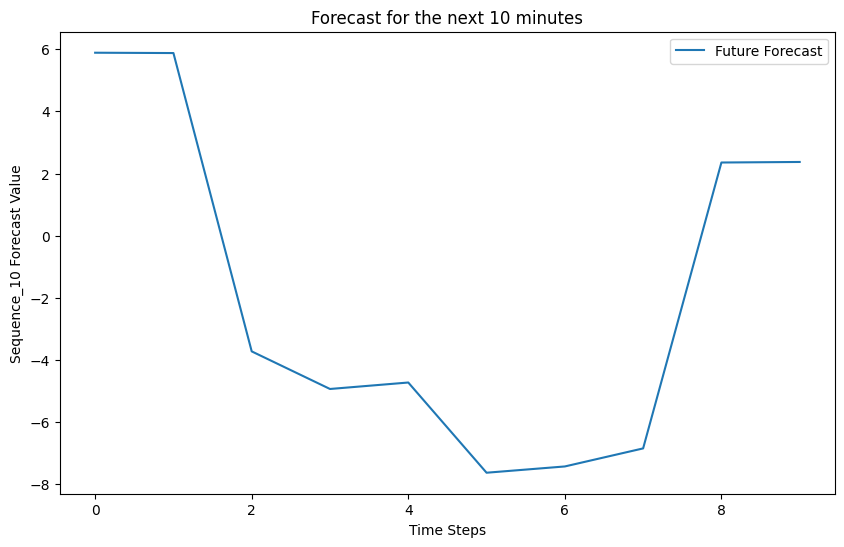

In [ ]:
# Visualize the predictions
predictions = model.predict(X_test)
scaled_predictions = sequence_10_scaler.inverse_transform(predictions)

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(sequence_10_scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual")
plt.plot(scaled_predictions, label="Predicted")
plt.title('Actual vs Predicted Sequence_10')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.legend()
#plt.show()
plt.savefig('Actual--vs--Predicted--Sequence_10__.pdf', format='pdf')
plt.close()

# Forecast the next 10 minutes
def forecast_future(data, model, window_size, future_steps, target_index):
    future_forecast = []
    current_sequence = data[-window_size:]  # Start with the last available window

    for _ in range(future_steps):
        next_step = model.predict(current_sequence[np.newaxis, :, :])
        future_forecast.append(next_step[0, 0])  # Predict only 'Sequence_10'

        next_sequence = np.copy(current_sequence)
        next_sequence = np.roll(next_sequence, -1, axis=0)  # Shift the sequence by 1
        next_sequence[-1, target_index] = next_step  # Update 'Sequence_10'

        current_sequence = next_sequence

    return np.array(future_forecast)

# Forecast future steps
future_steps = 10
future_forecast = forecast_future(scaled_data, model, window_size, future_steps, sequence_10_index)
scaled_future_forecast = sequence_10_scaler.inverse_transform(future_forecast.reshape(-1, 1))

# Plot future forecast
plt.figure(figsize=(10, 6))
plt.plot(scaled_future_forecast, label='Future Forecast')
plt.title('Forecast for the next 10 minutes')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Forecast Value')
plt.legend()
#plt.show()
plt.savefig('Forecast-for-the-next-10-minutes2.pdf', format='pdf')
plt.close()

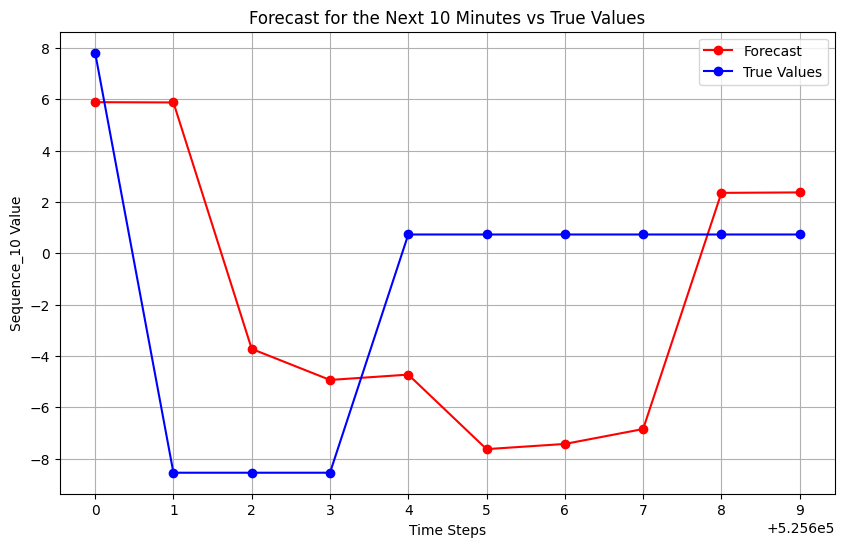

In [ ]:
# Get true future values from the dataset
true_future_values = sequence_10_scaler.inverse_transform(scaled_data[-(future_steps + window_size):-window_size, sequence_10_index].reshape(-1, 1))

# Prepare to plot the forecast and true future values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), scaled_future_forecast, marker='o', label='Forecast', color='red')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), true_future_values, marker='o', label='True Values', color='blue')
plt.title('Forecast for the Next 10 Minutes vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.xticks(np.arange(len(scaled_data), len(scaled_data) + future_steps))
plt.legend()
plt.grid()
#plt.show()
plt.savefig('Forecast_for_the_Next_10_Minutes_vs_True_Values_fig6.pdf', format='pdf')
plt.close()

In [ ]:
# Transformer model-building function for KerasTuner
def build_transformer_model(hp):
    input_layer = tf.keras.layers.Input(shape=(window_size, X.shape[2]))

    # Transformer encoder block
    attention = MultiHeadAttention(
        num_heads=hp.Int('num_heads', min_value=2, max_value=8, step=2),
        key_dim=hp.Int('key_dim', min_value=32, max_value=128, step=32))(input_layer, input_layer)

    # Add layer normalization
    attention = LayerNormalization(epsilon=1e-6)(attention)

    # Add feedforward network
    ff_network = tf.keras.layers.Dense(units=hp.Int('ff_units', min_value=32, max_value=128, step=32), activation='relu')(attention)
    ff_network = Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1))(ff_network)

    # Output layer
    output = Dense(1)(ff_network)

    # Build model
    model = tf.keras.Model(inputs=input_layer, outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),
                  loss='mean_squared_error')

    return model

# Search for the best transformer model
tuner = RandomSearch(
    build_transformer_model,  # Updated to transformer
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='Transformer_tuning',
    project_name='Sequence_10_forecast')

# Data preparation with GPU context
with tf.device('/GPU:0'):
    # Drop unnecessary columns like 'Time of Day' and 'Index'
    data = df.drop(columns=['Time of Day', 'Index', 'Sequence_1', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                            'Sequence_30', 'Sequence_40', 'Sequence_60', 'hl_20', 'p_30', 'hl_30', 'p_40', 'hl_40',
                            'p_60', 'hl_60', 'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240', 'p_360',
                            'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Scale only 'Sequence_10'
    sequence_10_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_sequence_10 = sequence_10_scaler.fit_transform(data[['Sequence_10']])

    # Prepare sequences
    def create_sequences(data, window_size, target_column):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i + window_size, :])
            y.append(data[i + window_size, target_column])
        return np.array(X), np.array(y)

    # Create sequences
    sequence_10_index = df.columns.get_loc('Sequence_10')
    window_size = 10  # 10 minutes window size
    X, y = create_sequences(scaled_data, window_size, sequence_10_index)

    # Split into train and test sets
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

# Search for the best model
tuner.search(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model
best_model.save('best_lstm_model.h5')

# Evaluate the best model
mse = best_model.evaluate(X_test, y_test)
print(f"Mean Squared Error: {mse}")

# Visualize the predictions
predictions = best_model.predict(X_test)
scaled_predictions = sequence_10_scaler.inverse_transform(predictions)

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(sequence_10_scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual")
plt.plot(scaled_predictions, label="Predicted")
plt.title('Actual vs Predicted Sequence_10')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.legend()
#plt.show()
plt.savefig('Actual_vs_Predicted_Sequence_10_fig8.pdf', format='pdf')
plt.close()

# Forecast the next 10 minutes
def forecast_future(data, model, window_size, future_steps, target_index):
    future_forecast = []
    current_sequence = data[-window_size:]  # Start with the last available window

    for _ in range(future_steps):
        next_step = model.predict(current_sequence[np.newaxis, :, :])
        future_forecast.append(next_step[0, 0])  # Predict only 'Sequence_10'

        next_sequence = np.copy(current_sequence)
        next_sequence = np.roll(next_sequence, -1, axis=0)  # Shift the sequence by 1
        next_sequence[-1, target_index] = next_step  # Update 'Sequence_10'

        current_sequence = next_sequence

    return np.array(future_forecast)

# Forecast future steps
future_steps = 10
future_forecast = forecast_future(scaled_data, best_model, window_size, future_steps, sequence_10_index)
scaled_future_forecast = sequence_10_scaler.inverse_transform(future_forecast.reshape(-1, 1))

# Plot future forecast
plt.figure(figsize=(10, 6))
plt.plot(scaled_future_forecast, label='Future Forecast')
plt.title('Forecast for the next 10 minutes')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Forecast Value')
plt.legend()
#plt.show()
plt.savefig('Forecast_for_the_next_10_minutes_fig9.pdf', format='pdf')
plt.close()

In [ ]:
# Forecast future steps
future_steps = 10
future_forecast = forecast_future(scaled_data, best_model, window_size, future_steps, sequence_10_index)
scaled_future_forecast = sequence_10_scaler.inverse_transform(future_forecast.reshape(-1, 1))

# Get true future values from the dataset
true_future_values = sequence_10_scaler.inverse_transform(scaled_data[-(future_steps + window_size):-window_size, sequence_10_index].reshape(-1, 1))

# Prepare to plot the forecast and true future values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), scaled_future_forecast, marker='o', label='Forecast', color='orange')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), true_future_values, marker='o', label='True Values', color='blue')
plt.title('Forecast for the Next 10 Minutes vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.xticks(np.arange(len(scaled_data), len(scaled_data) + future_steps))
plt.legend()
plt.grid()
#plt.show()
plt.savefig('Forecast_for_the_Next_10_Minutes_vs_True_Values_fig_9.pdf', format='pdf')
plt.close()

In [ ]:
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [ ]:
# Data preparation with GPU context
with tf.device('/GPU:0'):
    # Drop unnecessary columns like 'Time of Day' and 'Index'
    data = df.drop(columns=['Time of Day', 'Index', 'Sequence_1', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                            'Sequence_30', 'Sequence_40', 'Sequence_60', 'hl_20', 'hl_30', 'p_40', 'hl_40',
                            'p_60', 'hl_60', 'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240', 'p_360',
                            'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Scale only 'Sequence_10'
    sequence_10_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_sequence_10 = sequence_10_scaler.fit_transform(data[['Sequence_10']])

    # Prepare sequences
    def create_sequences(data, window_size, target_column):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i + window_size, :])
            y.append(data[i + window_size, target_column])
        return np.array(X), np.array(y)

    # Create sequences
    sequence_10_index = df.columns.get_loc('Sequence_10')
    window_size = 10  # 10 minutes window size
    X, y = create_sequences(scaled_data, window_size, sequence_10_index)

    # Split into train and test sets
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]


    #============
    # ARIMA settings
    arima_order = (1, 0, 4)  # Based on the previous analysis

    # Fit ARIMA to the residuals
    def fit_arima(data, arima_order):
        arima_model = ARIMA(data, order=arima_order)
        arima_result = arima_model.fit()
        return arima_result

    # Calculate residuals for Sequence_10 after fitting ARIMA
    arima_result = fit_arima(data['Sequence_10'], arima_order)
    residuals = arima_result.resid  # ARIMA residuals


    # Normalize residuals
    residuals_scaled = sequence_10_scaler.fit_transform(residuals.values.reshape(-1, 1))

    # Use ARIMA residuals as features for the LSTM
    def create_sequences_with_residuals(data, residuals, window_size, target_column):
        X, y = [], []
        for i in range(len(data) - window_size):
            sequence = np.hstack((data[i:i + window_size, :], residuals[i:i + window_size]))  # Add residuals
            X.append(sequence)
            y.append(data[i + window_size, target_column])
        return np.array(X), np.array(y)

    # Create sequences with ARIMA residuals
    X, y = create_sequences_with_residuals(scaled_data, residuals_scaled, window_size, sequence_10_index)

    # Redefine build_model function to consider additional features (ARIMA residuals)
    def build_model(hp):
        model = Sequential()

        # First LSTM layer
        model.add(LSTM(
            units=hp.Int('units_1', min_value=32, max_value=128, step=32),
            return_sequences=True,
            input_shape=(window_size, X.shape[2])))  # Updated input shape to include ARIMA residuals

        # Second LSTM layer
        model.add(LSTM(
            units=hp.Int('units_2', min_value=16, max_value=64, step=16),
            return_sequences=False))

        # Dense layers
        model.add(Dense(hp.Int('dense_units', min_value=16, max_value=64, step=16)))
        model.add(Dense(1))  # Output for 'Sequence_10'

        # Compile the model
        model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),
                      loss='mean_squared_error')

        return model





    #=============



    # Search for the best model
    tuner = RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=2,
        executions_per_trial=2,
        directory='LSTM_tuning',
        project_name='Sequence_10_forecast')

    # Search for the best model
    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

    #===========================

    # Retrieve the best model
    best_model = tuner.get_best_models(num_models=1)[0]
    # Save the best model and results
    best_model.save('best_hybrid_model.h5')
    #best_model.save('best_autoencoder_model.h5')
    np.save('scaler.npy', scaler)
    #===========================

    # Get the best model
    #best_model = tuner.get_best_models(num_models=1)[0]

    # Save the best model
    #best_model.save('best_hybrid_model.h5')

    # Evaluate the best model
    mse = best_model.evaluate(X_test, y_test)
    print(f"Mean Squared Error: {mse}")

    # Visualize the predictions
    predictions = best_model.predict(X_test)
    scaled_predictions = sequence_10_scaler.inverse_transform(predictions)

    # Calculate residuals for ARIMA adjustment
    residuals = y_test - predictions.flatten()

    # Fit ARIMA model on the residuals
    arima_order = (1, 0, 4)
    arima_model = ARIMA(residuals, order=arima_order)
    arima_result = arima_model.fit()

    # Adjust predictions using ARIMA residuals
    adjusted_predictions = predictions.flatten() + arima_result.fittedvalues
    scaled_adjusted_predictions = sequence_10_scaler.inverse_transform(adjusted_predictions.reshape(-1, 1))

    # Report the results
    print("Best hyperparameters: ", tuner.get_best_hyperparameters()[0].values)
    #print("Best model evaluation loss: ", loss)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
128               |128               |units_1
48                |48                |units_2
32                |32                |dense_units
0.0005            |0.0005            |learning_rate

Epoch 1/10
13140/13140 ━━━━━━━━━━━━━━━━━━━━ 159s 12ms/step - loss: 0.0361 - val_loss: 0.0173
Epoch 2/10
13140/13140 ━━━━━━━━━━━━━━━━━━━━ 185s 11ms/step - loss: 0.0165 - val_loss: 0.0154
Epoch 3/10
13140/13140 ━━━━━━━━━━━━━━━━━━━━ 167s 13ms/step - loss: 0.0152 - val_loss: 0.0143
Epoch 4/10
13140/13140 ━━━━━━━━━━━━━━━━━━━━ 174s 10ms/step - loss: 0.0146 - val_loss: 0.0138
Epoch 5/10
13140/13140 ━━━━━━━━━━━━━━━━━━━━ 117s 9ms/step - loss: 0.0139 - val_loss: 0.0137
Epoch 6/10


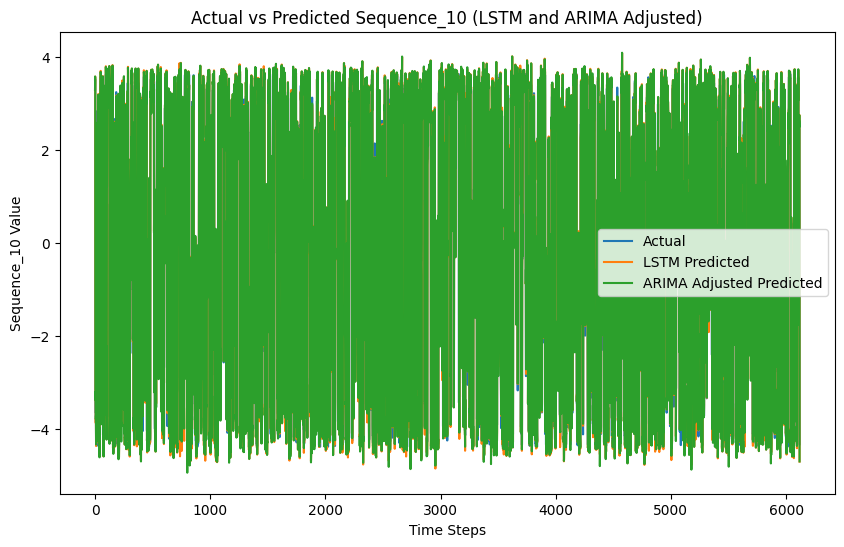

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-31-9edaf51771ae>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_sequence[-1, target_index] = lstm_pred  # Update 'Sequence_10'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


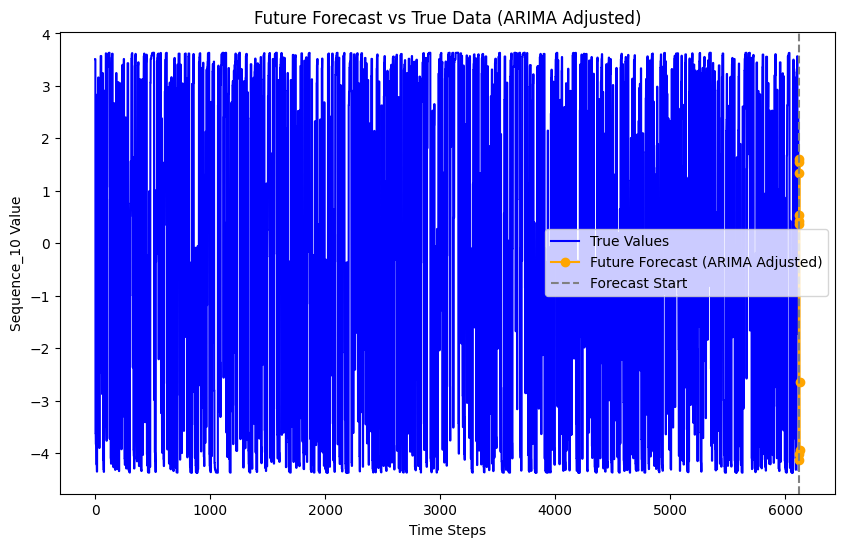

In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(sequence_10_scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual")
plt.plot(scaled_predictions, label="LSTM Predicted")
plt.plot(scaled_adjusted_predictions, label="ARIMA Adjusted Predicted")
plt.title('Actual vs Predicted Sequence_10 (LSTM and ARIMA Adjusted)')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.legend()
#plt.show()
plt.savefig('Future_Forecast_vs_True_Data_(ARIMA Adjusted)_fig12.pdf', format='pdf')
plt.close()

# Forecast the next 10 minutes with ARIMA-adjusted predictions
def forecast_future_arima_adjusted(data, model, window_size, future_steps, target_index, arima_result):
    future_forecast = []
    current_sequence = data[-window_size:]  # Start with the last available window

    for _ in range(future_steps):
        lstm_pred = model.predict(current_sequence[np.newaxis, :, :])

        # Get residual prediction from ARIMA
        arima_pred = arima_result.forecast(steps=1)[0]

        # Combine LSTM and ARIMA predictions
        combined_pred = lstm_pred[0, 0] + arima_pred
        future_forecast.append(combined_pred)  # Predict only 'Sequence_10'

        next_sequence = np.copy(current_sequence)
        next_sequence = np.roll(next_sequence, -1, axis=0)  # Shift the sequence by 1
        next_sequence[-1, target_index] = lstm_pred  # Update 'Sequence_10'

        current_sequence = next_sequence

    return np.array(future_forecast)

# Forecast future steps
future_steps = 10
future_forecast = forecast_future_arima_adjusted(scaled_data, best_model, window_size, future_steps, sequence_10_index, arima_result)
scaled_future_forecast = sequence_10_scaler.inverse_transform(future_forecast.reshape(-1, 1))

# Combine the last true values and the forecast for plotting
last_true_values = sequence_10_scaler.inverse_transform(y_test[-window_size:].reshape(-1, 1))
combined_forecast = np.concatenate((last_true_values, scaled_future_forecast))

# Plot true data and future forecast
plt.figure(figsize=(10, 6))
plt.plot(sequence_10_scaler.inverse_transform(y_test.reshape(-1, 1)), label='True Values', color='blue')
plt.plot(range(len(y_test), len(y_test) + future_steps), scaled_future_forecast, label='Future Forecast (ARIMA Adjusted)', color='orange', marker='o')
plt.axvline(x=len(y_test), color='gray', linestyle='--', label='Forecast Start')
plt.title('Future Forecast vs True Data (ARIMA Adjusted)')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.legend()
#plt.show()
plt.savefig('Future_Forecast_vs_True_Data_(ARIMA Adjusted)_fig13.pdf', format='pdf')
plt.close()

In [ ]:
# Forecast the next 10 minutes with ARIMA-adjusted predictions
def forecast_future_arima_adjusted(data, model, window_size, future_steps, target_index, arima_result):
    future_forecast = []
    current_sequence = data[-window_size:]  # Start with the last available window

    for _ in range(future_steps):
        lstm_pred = model.predict(current_sequence[np.newaxis, :, :])

        # Get residual prediction from ARIMA
        arima_pred = arima_result.forecast(steps=1)[0]

        # Combine LSTM and ARIMA predictions
        combined_pred = lstm_pred[0, 0] + arima_pred
        future_forecast.append(combined_pred)  # Predict only 'Sequence_10'

        next_sequence = np.copy(current_sequence)
        next_sequence = np.roll(next_sequence, -1, axis=0)  # Shift the sequence by 1
        next_sequence[-1, target_index] = lstm_pred  # Update 'Sequence_10'

        current_sequence = next_sequence

    return np.array(future_forecast)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<ipython-input-33-d09dfc35ac87>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_sequence[-1, target_index] = lstm_pred  # Update 'Sequence_10'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


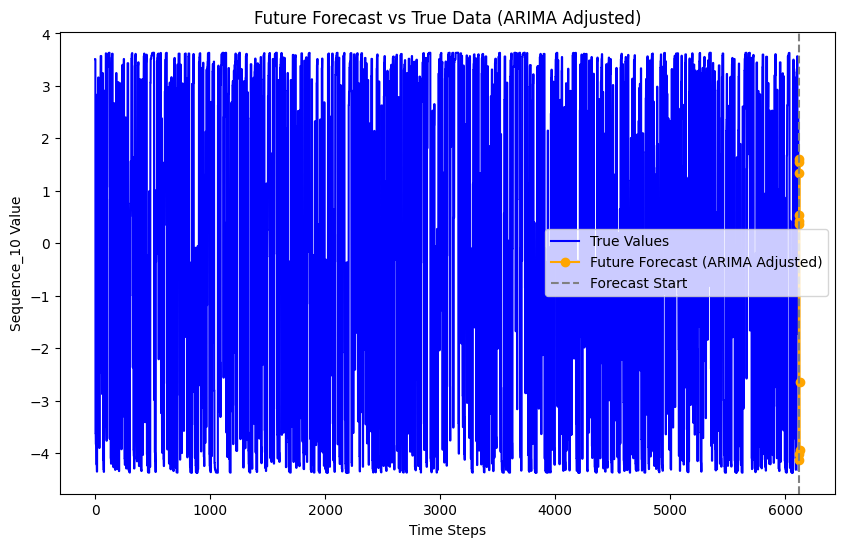

In [ ]:
# Forecast the next 10 minutes with ARIMA-adjusted predictions
def forecast_future_arima_adjusted(data, model, window_size, future_steps, target_index, arima_result):
    future_forecast = []
    current_sequence = data[-window_size:]  # Start with the last available window

    for _ in range(future_steps):
        lstm_pred = model.predict(current_sequence[np.newaxis, :, :])

        # Get residual prediction from ARIMA
        arima_pred = arima_result.forecast(steps=1)[0]

        # Combine LSTM and ARIMA predictions
        combined_pred = lstm_pred[0, 0] + arima_pred
        future_forecast.append(combined_pred)  # Predict only 'Sequence_10'

        next_sequence = np.copy(current_sequence)
        next_sequence = np.roll(next_sequence, -1, axis=0)  # Shift the sequence by 1
        next_sequence[-1, target_index] = lstm_pred  # Update 'Sequence_10'

        current_sequence = next_sequence

    return np.array(future_forecast)

# Forecast future steps
future_steps = 10
future_forecast = forecast_future_arima_adjusted(scaled_data, best_model, window_size, future_steps, sequence_10_index, arima_result)
scaled_future_forecast = sequence_10_scaler.inverse_transform(future_forecast.reshape(-1, 1))

# Combine the last true values and the forecast for plotting
last_true_values = sequence_10_scaler.inverse_transform(y_test[-window_size:].reshape(-1, 1))
combined_forecast = np.concatenate((last_true_values, scaled_future_forecast))

# Plot true data and future forecast
plt.figure(figsize=(10, 6))
plt.plot(sequence_10_scaler.inverse_transform(y_test.reshape(-1, 1)), label='True Values', color='blue')
plt.plot(range(len(y_test), len(y_test) + future_steps), scaled_future_forecast, label='Future Forecast (ARIMA Adjusted)', color='orange', marker='o')
plt.axvline(x=len(y_test), color='gray', linestyle='--', label='Forecast Start')
plt.title('Future Forecast vs True Data (ARIMA Adjusted)')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.legend()
#plt.show()
plt.savefig('Future_Forecast_vs_True_Data_(ARIMA Adjusted)_fig14.pdf', format='pdf')
plt.close()


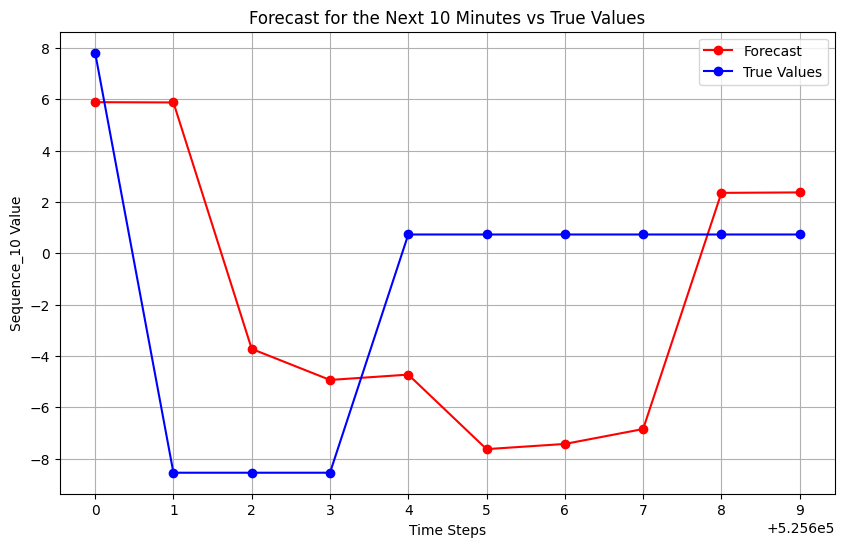

In [ ]:
# Get true future values from the dataset
true_future_values = sequence_10_scaler.inverse_transform(scaled_data[-(future_steps + window_size):-window_size, sequence_10_index].reshape(-1, 1))

# Prepare to plot the forecast and true future values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), scaled_future_forecast, marker='o', label='Forecast', color='red')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), true_future_values, marker='o', label='True Values', color='blue')
plt.title('Forecast for the Next 10 Minutes vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.xticks(np.arange(len(scaled_data), len(scaled_data) + future_steps))
plt.legend()
plt.grid()
#plt.show()
plt.savefig('Future_Forecast_vs_True_Data_(ARIMA Adjusted)_fig17.pdf', format='pdf')
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<ipython-input-33-d09dfc35ac87>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_sequence[-1, target_index] = lstm_pred  # Update 'Sequence_10'


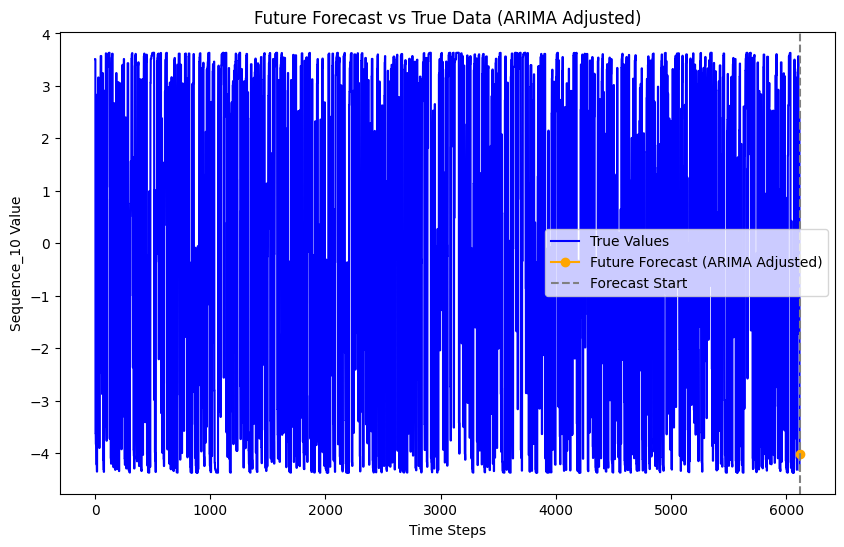

In [ ]:
# Forecast future steps
future_steps = 1
future_forecast = forecast_future_arima_adjusted(scaled_data, best_model, window_size, future_steps, sequence_10_index, arima_result)
scaled_future_forecast = sequence_10_scaler.inverse_transform(future_forecast.reshape(-1, 1))

# Combine the last true values and the forecast for plotting
last_true_values = sequence_10_scaler.inverse_transform(y_test[-window_size:].reshape(-1, 1))
combined_forecast = np.concatenate((last_true_values, scaled_future_forecast))

# Plot true data and future forecast
plt.figure(figsize=(10, 6))
plt.plot(sequence_10_scaler.inverse_transform(y_test.reshape(-1, 1)), label='True Values', color='blue')
plt.plot(range(len(y_test), len(y_test) + future_steps), scaled_future_forecast, label='Future Forecast (ARIMA Adjusted)', color='orange', marker='o')
plt.axvline(x=len(y_test), color='gray', linestyle='--', label='Forecast Start')
plt.title('Future Forecast vs True Data (ARIMA Adjusted)')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.legend()
#plt.show()
plt.savefig('Future_Forecast_vs_True_Data_(ARIMA Adjusted)_fig_21.pdf', format='pdf')
plt.close()

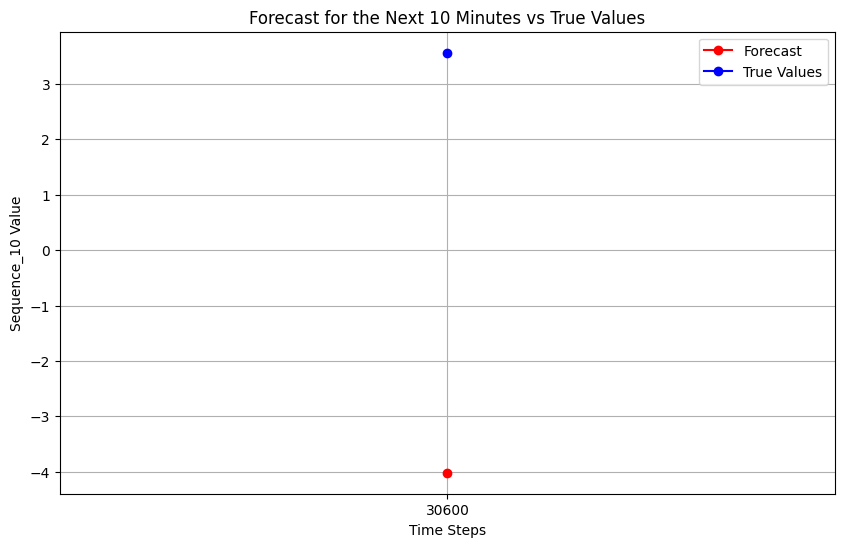

In [ ]:
# Get true future values from the dataset
true_future_values = sequence_10_scaler.inverse_transform(scaled_data[-(future_steps + window_size):-window_size, sequence_10_index].reshape(-1, 1))

# Prepare to plot the forecast and true future values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), scaled_future_forecast, marker='o', label='Forecast', color='red')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), true_future_values, marker='o', label='True Values', color='blue')
plt.title('Forecast for the Next 10 Minutes vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.xticks(np.arange(len(scaled_data), len(scaled_data) + future_steps))
plt.legend()
plt.grid()
plt.savefig('Future_Forecast_vs_True_Data_(ARIMA Adjusted)_fig25.pdf', format='pdf')
plt.close()

In [ ]:
# ARIMA settings
arima_order = (1, 0, 4)  # Based on the previous analysis

# Fit ARIMA to the residuals
def fit_arima(data, arima_order):
    arima_model = ARIMA(data, order=arima_order)
    arima_result = arima_model.fit()
    return arima_result

# Calculate residuals for Sequence_10 after fitting ARIMA
arima_result = fit_arima(data['Sequence_10'], arima_order)
residuals = arima_result.resid  # ARIMA residuals

# Normalize residuals
residuals_scaled = sequence_10_scaler.fit_transform(residuals.values.reshape(-1, 1))

# Use ARIMA residuals as features for the LSTM
def create_sequences_with_residuals(data, residuals, window_size, target_column):
    X, y = [], []
    for i in range(len(data) - window_size):
        sequence = np.hstack((data[i:i + window_size, :], residuals[i:i + window_size]))  # Add residuals
        X.append(sequence)
        y.append(data[i + window_size, target_column])
    return np.array(X), np.array(y)

# Create sequences with ARIMA residuals
X, y = create_sequences_with_residuals(scaled_data, residuals_scaled, window_size, sequence_10_index)

# Redefine build_model function to consider additional features (ARIMA residuals)
def build_model(hp):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(
        units=hp.Int('units_1', min_value=32, max_value=128, step=32),
        return_sequences=True,
        input_shape=(window_size, X.shape[2])))  # Updated input shape to include ARIMA residuals

    # Second LSTM layer
    model.add(LSTM(
        units=hp.Int('units_2', min_value=16, max_value=64, step=16),
        return_sequences=False))

    # Dense layers
    model.add(Dense(hp.Int('dense_units', min_value=16, max_value=64, step=16)))
    model.add(Dense(1))  # Output for 'Sequence_10'

    # Compile the model
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),
                  loss='mean_squared_error')

    return model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
data = df.drop(columns=['Time of Day', 'Index', 'Sequence_20', 'Sequence_30', 'Sequence_40', 'Sequence_60', 'p_20', 'hl_20', 'p_30', 'hl_30', 'p_40', 'hl_40', 'p_60', 'hl_60', 'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240', 'p_360', 'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare input sequences and labels for LSTM
sequence_10_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sequence_10 = sequence_10_scaler.fit_transform(data[['Sequence_10']])

def create_sequences(data, window_size, target_column):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :])
        y.append(data[i + window_size, target_column])
    return np.array(X), np.array(y)

sequence_10_index = df.columns.get_loc('Sequence_10')
window_size = 10  # 10 minutes window size
X, y = create_sequences(scaled_data, window_size, sequence_10_index)

ADF Statistic: -8.416480965317477
p-value: 2.037216047409324e-13


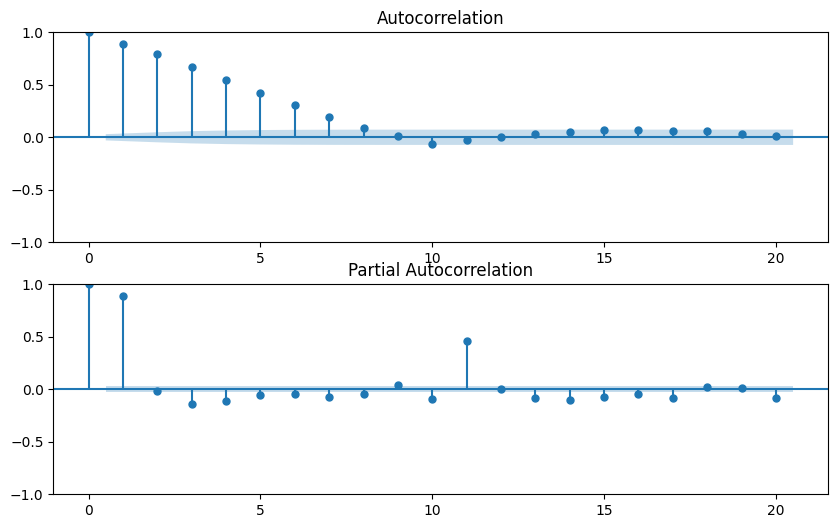

In [ ]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

result = adfuller(X_1d)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
#result = adfuller(X)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Plot ACF and PACF to identify p and q
plt.figure(figsize=(10, 6))
plt.subplot(211)
plot_acf(sequence_10, lags=20, ax=plt.gca())
plt.subplot(212)
plot_pacf(sequence_10, lags=20, ax=plt.gca())
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Extract 'Sequence_10' as a 1D array (unscaled or scaled as needed)
sequence_10 = df['Sequence_10'].values  # Use df['Sequence_10'] directly if it's not scaled

# If you're applying the test on scaled data, use this line instead:
# sequence_10 = scaled_sequence_10.flatten()

# Check stationarity with Augmented Dickey-Fuller test
result = adfuller(sequence_10)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -8.416480965317477
p-value: 2.037216047409324e-13
ADF Statistic: -8.416480965317477
p-value: 2.037216047409324e-13


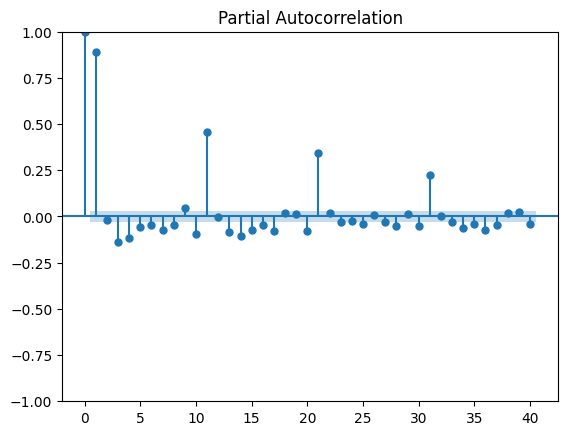

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Plot PACF to determine p
plot_pacf(sequence_10, lags=40)
plt.show()


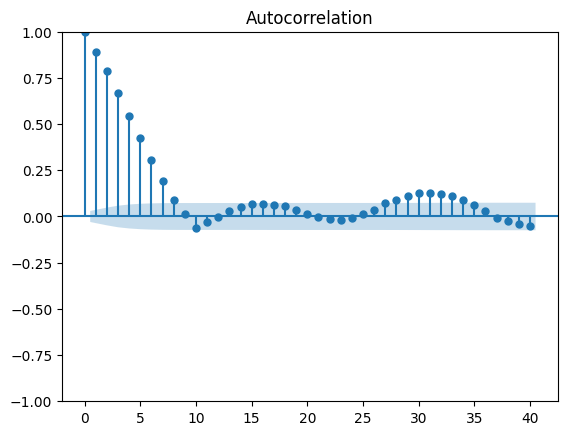

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF to determine q
plot_acf(sequence_10, lags=40)
plt.show()


ADF Statistic: -8.416480965317477
p-value: 2.037216047409324e-13
ADF Statistic: -8.416480965317477
p-value: 2.037216047409324e-13


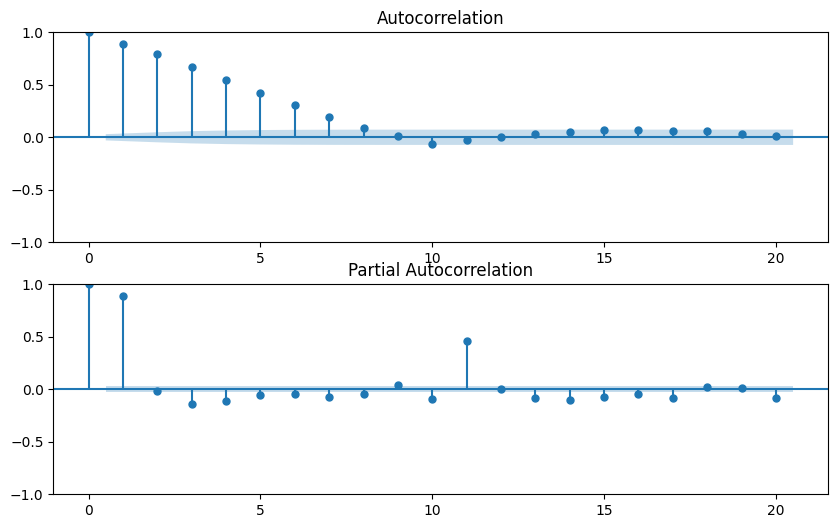

In [ ]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

result = adfuller(sequence_10)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
#result = adfuller(X)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Plot ACF and PACF to identify p and q
plt.figure(figsize=(10, 6))
plt.subplot(211)
plot_acf(sequence_10, lags=20, ax=plt.gca())
plt.subplot(212)
plot_pacf(sequence_10, lags=20, ax=plt.gca())
plt.show()


ADF Statistic: -8.416480965317477
p-value: 2.037216047409324e-13
ADF Statistic: -8.416480965317477
d-value: 30
q-value: 4289


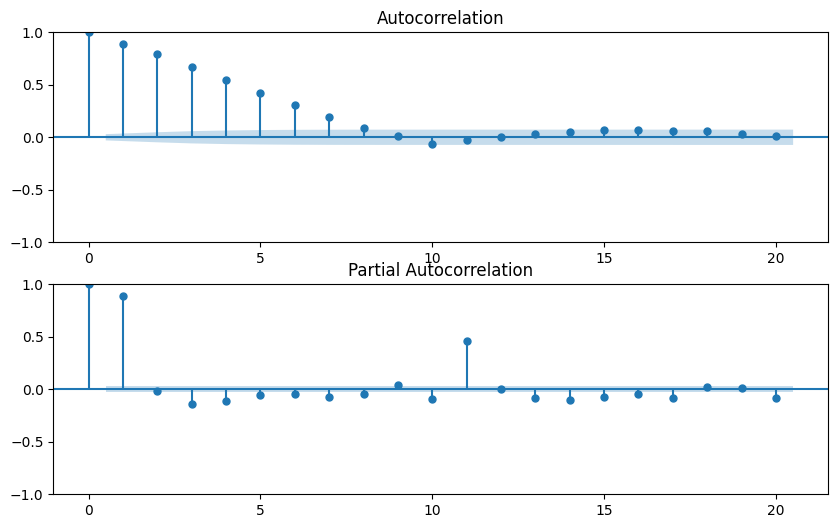

In [ ]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

result = adfuller(sequence_10)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
#result = adfuller(X)
print(f'ADF Statistic: {result[0]}')
print(f'd-value: {result[2]}')
print(f'q-value: {result[3]}')

# Plot ACF and PACF to identify p and q
plt.figure(figsize=(10, 6))
plt.subplot(211)
plot_acf(sequence_10, lags=20, ax=plt.gca())
plt.subplot(212)
plot_pacf(sequence_10, lags=20, ax=plt.gca())
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Select a specific time series column, e.g., 'Sequence_10'
sequence_10 = df['Sequence_10']

# Check stationarity with Augmented Dickey-Fuller test
result = adfuller(sequence_10)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -8.416480965317477
p-value: 2.037216047409324e-13
The time series is stationary.


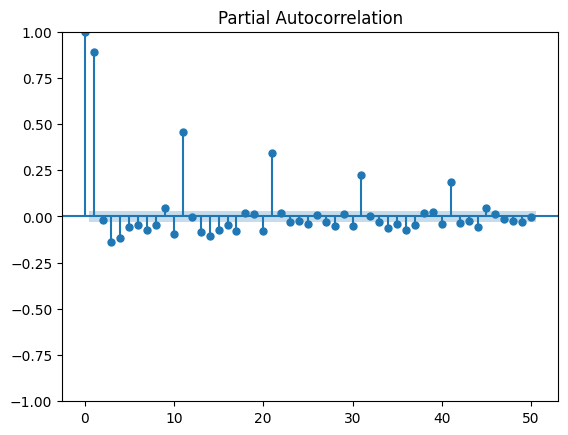

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# PACF plot to determine p
plot_pacf(sequence_10, lags=50)
plt.show()


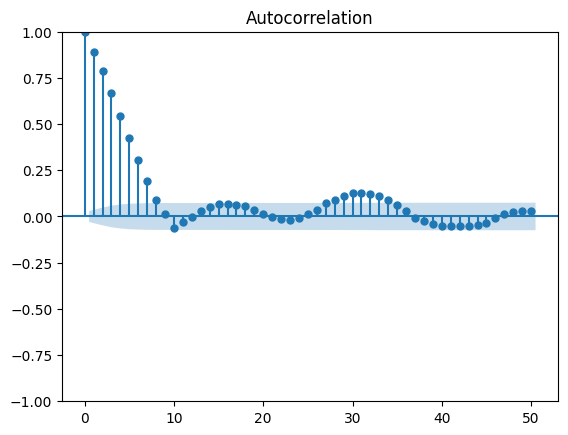

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# ACF plot to determine q
plot_acf(sequence_10, lags=50)
plt.show()



In [ ]:
# Data preparation with GPU context
with tf.device('/GPU:0'):
    # Drop unnecessary columns
    #data = df.drop(columns=['Time of Day', 'Index'])
    data = df.drop(columns=['Time of Day', 'Index', 'Sequence_1', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                            'Sequence_30', 'Sequence_40', 'Sequence_60', 'p_20', 'hl_20', 'p_30', 'hl_30', 'p_40', 'hl_40',
                            'p_60', 'hl_60', 'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240', 'p_360',
                            'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Prepare input sequences and labels for LSTM
    sequence_10_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_sequence_10 = sequence_10_scaler.fit_transform(data[['Sequence_10']])

    def create_sequences(data, window_size, target_column):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i + window_size, :])
            y.append(data[i + window_size, target_column])
        return np.array(X), np.array(y)

    sequence_10_index = df.columns.get_loc('Sequence_10')
    window_size = 10  # 10 minutes window size
    X, y = create_sequences(scaled_data, window_size, sequence_10_index)

    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.02))
    model.add(LSTM(16, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the LSTM model
    model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

    # LSTM predictions
    lstm_predictions = model.predict(X_test)

    # Inverse transform LSTM predictions
    scaled_lstm_predictions = sequence_10_scaler.inverse_transform(lstm_predictions)

    # Calculate residuals (actual - LSTM predictions)
    y_test_inverse = sequence_10_scaler.inverse_transform(y_test.reshape(-1, 1))
    residuals = y_test_inverse - scaled_lstm_predictions

# Step 3: Fit ARIMA on Residuals
arima_order = (1, 0, 4)  # Adjust ARIMA order for which is p = 1, d = 0 and q = 4 (5, 1, 0)
arima_model = ARIMA(residuals, order=arima_order)
arima_result = arima_model.fit()

# ARIMA residual predictions
arima_predictions = arima_result.forecast(steps=len(residuals))

# Step 4: Combine LSTM and ARIMA predictions
combined_forecast = scaled_lstm_predictions.flatten() + arima_predictions

# Evaluate the combined model performance
mse_combined = mean_squared_error(y_test_inverse, combined_forecast)
print(f"Combined Model Mean Squared Error: {mse_combined}")

# Forecast next 10 minutes using the hybrid model
def forecast_hybrid_lstm_arima(data, model, window_size, future_steps, target_index, arima_result):
    future_forecast = []
    current_sequence = data[-window_size:]  # Start with the last available window

    for _ in range(future_steps):
        # LSTM step
        lstm_prediction = model.predict(current_sequence[np.newaxis, :, :])

        # ARIMA residual step
        arima_forecast = arima_result.forecast(steps=1)[0]

        # Combined forecast
        combined_prediction = lstm_prediction[0, 0] + arima_forecast

        # Append the combined forecast
        future_forecast.append(combined_prediction)

        # Update the sequence with predicted value
        next_sequence = np.copy(current_sequence)
        next_sequence = np.roll(next_sequence, -1, axis=0)  # Shift by 1
        next_sequence[-1, target_index] = lstm_prediction  # Update only 'Sequence_10'

        current_sequence = next_sequence

    return np.array(future_forecast)

# Forecasting next 10 minutes using the hybrid model
future_steps = 10
future_forecast_hybrid = forecast_hybrid_lstm_arima(scaled_data, model, window_size, future_steps, sequence_10_index, arima_result)

# Inverse transform the hybrid future forecast
scaled_hybrid_future_forecast = sequence_10_scaler.inverse_transform(future_forecast_hybrid.reshape(-1, 1))

print("Hybrid Forecast for the next 10 minutes:", scaled_hybrid_future_forecast)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1153 - val_loss: 0.0687
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0580 - val_loss: 0.0620
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0516 - val_loss: 0.0569
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0504 - val_loss: 0.0522
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0499 - val_loss: 0.0510
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0449 - val_loss: 0.0472
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0426 - val_loss: 0.0456
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0431 - val_loss: 0.0445
Epoch 9/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0409 - val_loss: 0.0463
Epoch 10/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0406 - val_loss: 0.0442
Epoch 11/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0389 - val_loss: 0.0444
Epoch 12/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss:

<ipython-input-73-288757fd721e>:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_sequence[-1, target_index] = lstm_prediction  # Update only 'Sequence_10'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Hybrid Forecast for the next 10 minutes: [[ 2.17874349]
 [ 2.12904383]
 [-4.13691062]
 [-5.01907768]
 [-5.36036352]
 [-3.17254875]
 [-1.19438862]
 [-0.77057396]
 [ 0.36534068]
 [ 1.36203556]]


In [ ]:
# Data preparation with GPU context
with tf.device('/GPU:0'):
    # Drop unnecessary columns
    #data = df.drop(columns=['Time of Day', 'Index'])
    data = df.drop(columns=['Time of Day', 'Index', 'Sequence_1', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                            'Sequence_30', 'Sequence_40', 'Sequence_60', 'p_20', 'hl_20', 'p_30', 'hl_30', 'p_40', 'hl_40',
                            'p_60', 'hl_60', 'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240', 'p_360',
                            'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Prepare input sequences and labels for LSTM
    sequence_10_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_sequence_10 = sequence_10_scaler.fit_transform(data[['Sequence_10']])

    def create_sequences(data, window_size, target_column):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i + window_size, :])
            y.append(data[i + window_size, target_column])
        return np.array(X), np.array(y)

    sequence_10_index = df.columns.get_loc('Sequence_10')
    window_size = 10  # 10 minutes window size
    X, y = create_sequences(scaled_data, window_size, sequence_10_index)

    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.02))
    model.add(LSTM(16, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the LSTM model
    model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

    # LSTM predictions
    lstm_predictions = model.predict(X_test)

    # Inverse transform LSTM predictions
    scaled_lstm_predictions = sequence_10_scaler.inverse_transform(lstm_predictions)

    # Calculate residuals (actual - LSTM predictions)
    y_test_inverse = sequence_10_scaler.inverse_transform(y_test.reshape(-1, 1))
    residuals = y_test_inverse - scaled_lstm_predictions

# Step 3: Fit ARIMA on Residuals
arima_order = (1, 0, 4)
arima_model = ARIMA(residuals, order=arima_order)
arima_result = arima_model.fit()

# ARIMA residual predictions
arima_predictions = arima_result.forecast(steps=len(residuals))

# Step 4: Combine LSTM and ARIMA predictions
combined_forecast = scaled_lstm_predictions.flatten() + arima_predictions

# Evaluate the combined model performance
mse_combined = mean_squared_error(y_test_inverse, combined_forecast)
print(f"Combined Model Mean Squared Error: {mse_combined}")

# Forecast next 10 minutes using the hybrid model
def forecast_hybrid_lstm_arima(data, model, window_size, future_steps, target_index, arima_result):
    future_forecast = []
    current_sequence = data[-window_size:]  # Start with the last available window

    for _ in range(future_steps):
        # LSTM step
        lstm_prediction = model.predict(current_sequence[np.newaxis, :, :])

        # ARIMA residual step
        arima_forecast = arima_result.forecast(steps=1)[0]

        # Combined forecast
        combined_prediction = lstm_prediction[0, 0] + arima_forecast

        # Append the combined forecast
        future_forecast.append(combined_prediction)

        # Update the sequence with predicted value
        next_sequence = np.copy(current_sequence)
        next_sequence = np.roll(next_sequence, -1, axis=0)  # Shift by 1
        next_sequence[-1, target_index] = lstm_prediction  # Update only 'Sequence_10'

        current_sequence = next_sequence

    return np.array(future_forecast)

# Forecasting next 10 minutes using the hybrid model
future_steps = 10
future_forecast_hybrid = forecast_hybrid_lstm_arima(scaled_data, model, window_size, future_steps, sequence_10_index, arima_result)

# Inverse transform the hybrid future forecast
scaled_hybrid_future_forecast = sequence_10_scaler.inverse_transform(future_forecast_hybrid.reshape(-1, 1))

print("Hybrid Forecast for the next 10 minutes:", scaled_hybrid_future_forecast)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


<ipython-input-68-f210092acefc>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_sequence[-1, target_index] = next_step  # Update 'Sequence_10'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


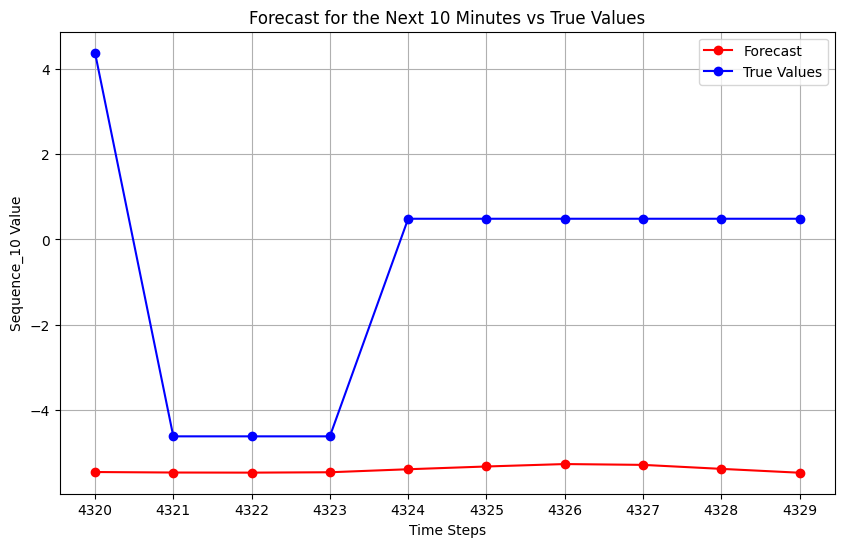

In [ ]:
# Forecast future steps
future_steps = 10
future_forecast = forecast_future(scaled_data, best_model, window_size, future_steps, sequence_10_index)
scaled_future_forecast = sequence_10_scaler.inverse_transform(future_forecast.reshape(-1, 1))

# Get true future values from the dataset
true_future_values = sequence_10_scaler.inverse_transform(scaled_data[-(future_steps + window_size):-window_size, sequence_10_index].reshape(-1, 1))

# Prepare to plot the forecast and true future values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), scaled_future_forecast, marker='o', label='Forecast', color='red')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), true_future_values, marker='o', label='True Values', color='blue')
plt.title('Forecast for the Next 10 Minutes vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.xticks(np.arange(len(scaled_data), len(scaled_data) + future_steps))
plt.legend()
plt.grid()
#plt.show()
plt.savefig('Future_Forecast_vs_True_Data_(ARIMA Adjusted)_10MIN_xrt.pdf', format='pdf')
plt.close()

In [ ]:
pip install tensorflow_addons

In [ ]:
!apt-get -qq install -y tensorflow_addons

E: Unable to locate package tensorflow_addons


In [ ]:
# Data preparation with GPU context
with tf.device('/GPU:0'):
    # Drop unnecessary columns like 'Time of Day' and 'Index'
    data = df.drop(columns=['Time of Day', 'Index', 'Sequence_1', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                            'Sequence_30', 'Sequence_40', 'Sequence_60', 'p_20', 'hl_20', 'p_30', 'hl_30', 'p_40', 'hl_40',
                            'p_60', 'hl_60', 'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240', 'p_360',
                            'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Scale only 'Sequence_10'
    sequence_10_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_sequence_10 = sequence_10_scaler.fit_transform(data[['Sequence_10']])


  # Prepare sequences for Transformer (adjust input shape as needed)
  def create_transformer_sequences(data, window_size, target_column):
    inputs, targets = [], []
    for i in range(len(data) - window_size):
      inputs.append(data[i:i + window_size, :])
      targets.append(data[i + window_size, target_column])
    return np.array(inputs), np.array(targets)

    # Create sequences
    sequence_10_index = df.columns.get_loc('Sequence_10')
    window_size = 10  # 10 minutes window size
    X, y = create_sequences(scaled_data, window_size, sequence_10_index)

    # Split into train and test sets
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]


    #============
    # ARIMA settings
    arima_order = (2, 0, 4)  # Based on the previous analysis

    # Fit ARIMA to the residuals
    def fit_arima(data, arima_order):
        arima_model = ARIMA(data, order=arima_order)
        arima_result = arima_model.fit()
        return arima_result

    # Calculate residuals for Sequence_10 after fitting ARIMA
    arima_result = fit_arima(data['Sequence_10'], arima_order)
    residuals = arima_result.resid  # ARIMA residuals

    # Normalize residuals
    residuals_scaled = sequence_10_scaler.fit_transform(residuals.values.reshape(-1, 1))

    # Use ARIMA residuals as features for the LSTM
    def create_sequences_with_residuals(data, residuals, window_size, target_column):
        X, y = [], []
        for i in range(len(data) - window_size):
            sequence = np.hstack((data[i:i + window_size, :], residuals[i:i + window_size]))  # Add residuals
            X.append(sequence)
            y.append(data[i + window_size, target_column])
        return np.array(X), np.array(y)

    # Create sequences with ARIMA residuals
    X, y = create_sequences_with_residuals(scaled_data, residuals_scaled, window_size, sequence_10_index)

    # Build a Transformer model (adjust architecture as needed)
    def build_transformer_model(hp):
      input_shape = (window_size, X_train.shape[-1])
      model = tf.keras.Sequential([
         tf.keras.layers.InputLayer(input_shape=input_shape),
         # Add Transformer layers here, e.g.,
         tf.keras.layers.Embedding(input_dim=input_shape[-1], output_dim=64),
         tf.keras.layers.PositionalEncoding(input_shape[-1]),
         tf.keras.layers.TransformerEncoder(num_layers=2, num_heads=4, d_model=64),
          tf.keras.layers.GlobalAveragePooling1D(),
          tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'),
          tf.keras.layers.Dense(1)  # Output layer for single value prediction
      ])
      model.compile(optimizer='adam', loss='mean_squared_error')
      return model


    # Forecast the next 10 minutes (adjust for Transformer's output shape)
    def forecast_future_transformer(data, model, window_size, future_steps, target_index):
      future_forecast = []
      current_sequence = data[-window_size:]  # Start with the last available window

      for _ in range(future_steps):
        next_step = model.predict(current_sequence[np.newaxis, :, :])
        future_forecast.append(next_step[0, 0])  # Extract the predicted value

        # Shift the sequence and update the last value with the prediction
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1, target_index] = next_step

      return np.array(future_forecast)


    #=============



    # Search for the best transformer model
    tuner = RandomSearch(
        build_transformer_model,  # Updated to transformer
        objective='val_loss',
       max_trials=5,
        executions_per_trial=3,
        directory='Transformer_tuning',
        project_name='Sequence_10_forecast')

      # Search for the best model
    tuner.search(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

    #===========================

    # Retrieve the best model
    best_model = tuner.get_best_models(num_models=1)[0]
    # Save the best model and results
    best_model.save('best_autoencoder_model.h5')
    np.save('scaler.npy', scaler)
    #===========================

    # Get the best model
    best_model = tuner.get_best_models(num_models=1)[0]

    # Save the best model
    best_model.save('best_lstm_model.h5')

    # Evaluate the best model
    mse = best_model.evaluate(X_test, y_test)
    print(f"Mean Squared Error: {mse}")





    # Visualize the predictions
    predictions = best_model.predict(X_test)
    scaled_predictions = sequence_10_scaler.inverse_transform(predictions)

    # Calculate residuals for ARIMA adjustment
    residuals = y_test - predictions.flatten()

    # Fit ARIMA model on the residuals
    arima_order = (1, 0, 4)
    arima_model = ARIMA(residuals, order=arima_order)
    arima_result = arima_model.fit()

    # Adjust predictions using ARIMA residuals
    adjusted_predictions = predictions.flatten() + arima_result.fittedvalues
    scaled_adjusted_predictions = sequence_10_scaler.inverse_transform(adjusted_predictions.reshape(-1, 1))

    # Report the results
    print("Best hyperparameters: ", tuner.get_best_hyperparameters()[0].values)
    print("Best model evaluation loss: ", loss)


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 19)

In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(sequence_10_scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual")
plt.plot(scaled_predictions, label="LSTM Predicted")
plt.plot(scaled_adjusted_predictions, label="ARIMA Adjusted Predicted")
plt.title('Actual vs Predicted Sequence_10 (LSTM and ARIMA Adjusted)')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.legend()
#plt.show()
plt.savefig('Future_Forecast_vs_True_Data_(ARIMA Adjusted)_fig34.pdf', format='pdf')
plt.close()


# Forecast the next 10 minutes with ARIMA-adjusted predictions
def forecast_future_arima_adjusted(data, model, window_size, future_steps, target_index, arima_result):
    future_forecast = []
    current_sequence = data[-window_size:]  # Start with the last available window

    for _ in range(future_steps):
        lstm_pred = model.predict(current_sequence[np.newaxis, :, :])

        # Get residual prediction from ARIMA
        arima_pred = arima_result.forecast(steps=1)[0]

        # Combine LSTM and ARIMA predictions
        combined_pred = lstm_pred[0, 0] + arima_pred
        future_forecast.append(combined_pred)  # Predict only 'Sequence_10'

        next_sequence = np.copy(current_sequence)
        next_sequence = np.roll(next_sequence, -1, axis=0)  # Shift the sequence by 1
        next_sequence[-1, target_index] = lstm_pred  # Update 'Sequence_10'

        current_sequence = next_sequence

    return np.array(future_forecast)

# Forecast future steps
future_steps = 10
future_forecast = forecast_future_arima_adjusted(scaled_data, best_model, window_size, future_steps, sequence_10_index, arima_result)
scaled_future_forecast = sequence_10_scaler.inverse_transform(future_forecast.reshape(-1, 1))

# Combine the last true values and the forecast for plotting
last_true_values = sequence_10_scaler.inverse_transform(y_test[-window_size:].reshape(-1, 1))
combined_forecast = np.concatenate((last_true_values, scaled_future_forecast))

# Plot true data and future forecast
plt.figure(figsize=(10, 6))
plt.plot(sequence_10_scaler.inverse_transform(y_test.reshape(-1, 1)), label='True Values', color='blue')
plt.plot(range(len(y_test), len(y_test) + future_steps), scaled_future_forecast, label='Future Forecast (ARIMA Adjusted)', color='orange', marker='o')
plt.axvline(x=len(y_test), color='gray', linestyle='--', label='Forecast Start')
plt.title('Future Forecast vs True Data (ARIMA Adjusted)')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.legend()
#plt.show()
plt.savefig('Future_Forecast_vs_True_Data_(ARIMA Adjusted)_fig44.pdf', format='pdf')
plt.close()

In [ ]:
# Suppress warnings for LSTMCell and optimizer mismatches
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

In [ ]:
# ARIMA settings
arima_order = (1, 0, 4)  # Based on the previous analysis

# Fit ARIMA to the residuals
def fit_arima(data, arima_order):
    arima_model = ARIMA(data, order=arima_order)
    arima_result = arima_model.fit()
    return arima_result

# Calculate residuals for Sequence_10 after fitting ARIMA
arima_result = fit_arima(data['Sequence_10'], arima_order)
residuals = arima_result.resid  # ARIMA residuals

# Normalize residuals
residuals_scaled = sequence_10_scaler.fit_transform(residuals.values.reshape(-1, 1))

# Use ARIMA residuals as features for the LSTM
def create_sequences_with_residuals(data, residuals, window_size, target_column):
    X, y = [], []
    for i in range(len(data) - window_size):
        sequence = np.hstack((data[i:i + window_size, :], residuals[i:i + window_size]))  # Add residuals
        X.append(sequence)
        y.append(data[i + window_size, target_column])
    return np.array(X), np.array(y)

# Create sequences with ARIMA residuals
X, y = create_sequences_with_residuals(scaled_data, residuals_scaled, window_size, sequence_10_index)

# Redefine build_model function to consider additional features (ARIMA residuals)
def build_model(hp):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(
        units=hp.Int('units_1', min_value=32, max_value=128, step=32),
        return_sequences=True,
        input_shape=(window_size, X.shape[2])))  # Updated input shape to include ARIMA residuals

    # Second LSTM layer
    model.add(LSTM(
        units=hp.Int('units_2', min_value=16, max_value=64, step=16),
        return_sequences=False))

    # Dense layers
    model.add(Dense(hp.Int('dense_units', min_value=16, max_value=64, step=16)))
    model.add(Dense(1))  # Output for 'Sequence_10'

    # Compile the model
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),
                  loss='mean_squared_error')

    return model


Reloading Tuner from LSTM_tuning/Sequence_10_forecast/tuner0.json


Error while loading the best model: A total of 1 objects could not be loaded. Example error message for object <LSTMCell name=lstm_cell, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(11, 512), Received: value.shape=(43, 512). Target variable: <KerasVariable shape=(11, 512), dtype=float32, path=sequential/lstm/lstm_cell/kernel>

List of objects that could not be loaded:
[<LSTMCell name=lstm_cell, built=True>]
Rebuilding the best model without optimizer state...
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4813 - mse: 0.4813
Mean Squared Error: [0.4819994568824768, 0.4819994568824768]
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


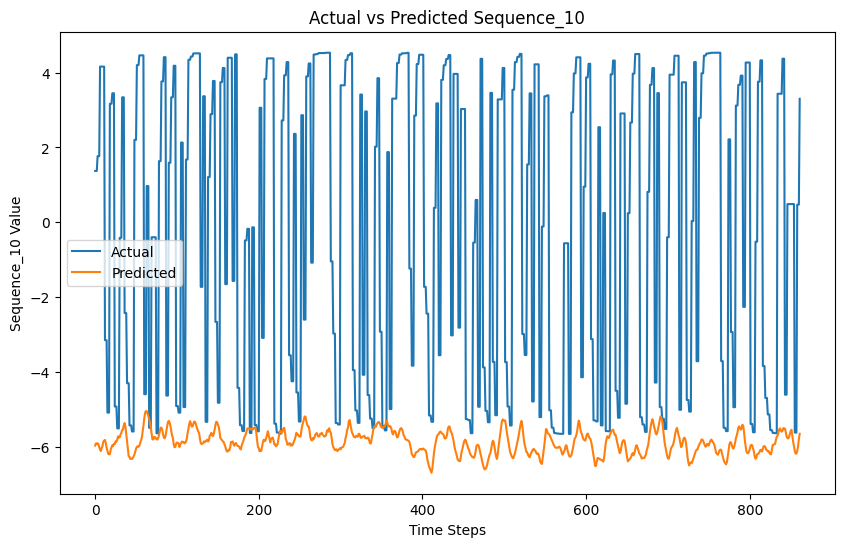

In [ ]:
# Data preparation with GPU context
with tf.device('/GPU:0'):
    # Drop unnecessary columns like 'Time of Day' and 'Index'
    data = df.drop(columns=['Time of Day', 'Index', 'Sequence_1', 'Sequence_2', 'Sequence_3', 'Sequence_5', 'Sequence_20',
                            'Sequence_30', 'Sequence_40', 'Sequence_60', 'p_20', 'hl_20', 'p_30', 'hl_30', 'p_40', 'hl_40',
                            'p_60', 'hl_60', 'p_90', 'hl_90', 'p_120', 'hl_120', 'p_180', 'hl_180', 'p_240', 'hl_240', 'p_360',
                            'hl_360', 'p_480', 'hl_480', 'p_720', 'hl_720', 'p_1440', 'hl_1440'])

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Scale only 'Sequence_10'
    sequence_10_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_sequence_10 = sequence_10_scaler.fit_transform(data[['Sequence_10']])

    # Prepare sequences
    def create_sequences(data, window_size, target_column):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i + window_size, :])
            y.append(data[i + window_size, target_column])
        return np.array(X), np.array(y)

    # Create sequences
    sequence_10_index = df.columns.get_loc('Sequence_10')
    window_size = 10  # 10 minutes window size
    X, y = create_sequences(scaled_data, window_size, sequence_10_index)

    # Split into train and test sets
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

# Search for the best model
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='LSTM_tuning',
    project_name='Sequence_10_forecast')

# Search for the best model
tuner.search(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

# ===========
# Suppress warnings for LSTMCell and optimizer mismatches
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

# Get the best model
try:
    # Attempt to load the best model from tuner
    best_model = tuner.get_best_models(num_models=1)[0]

    # Save the best model
    best_model.save('best_lstm_model.h5')

except ValueError as e:
    # Handle the case when there is a shape mismatch during model reloading
    print(f"Error while loading the best model: {e}")

    # Rebuild the model architecture without loading the optimizer state
    print("Rebuilding the best model without optimizer state...")

    # Get the best hyperparameters from tuner
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Rebuild the model manually using the best hyperparameters
    best_model = build_model(best_hps)

    # Compile the model (skip loading the optimizer state)
    best_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    # Save the rebuilt model
    best_model.save('best_lstm_model_rebuilt.h5')

# Evaluate the best model
mse = best_model.evaluate(X_test, y_test)
print(f"Mean Squared Error: {mse}")

# Visualize the predictions
predictions = best_model.predict(X_test)
scaled_predictions = sequence_10_scaler.inverse_transform(predictions)

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(sequence_10_scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual")
plt.plot(scaled_predictions, label="Predicted")
plt.title('Actual vs Predicted Sequence_10')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.legend()
#plt.show()
plt.savefig('Future_Forecast_vs_True_Data_(ARIMA Adjusted)_fig45.pdf', format='pdf')
plt.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


<ipython-input-68-f210092acefc>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_sequence[-1, target_index] = next_step  # Update 'Sequence_10'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


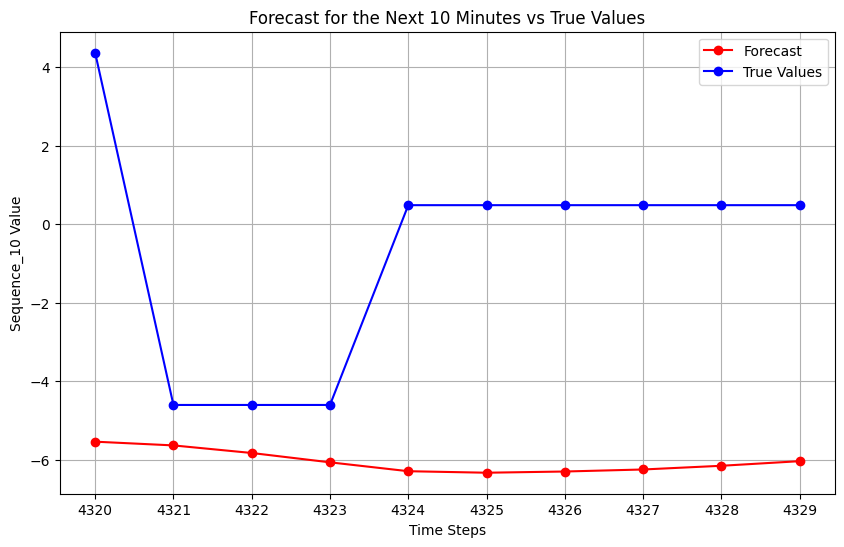

In [ ]:
# Forecast future steps
future_steps = 10
future_forecast = forecast_future(scaled_data, best_model, window_size, future_steps, sequence_10_index)
scaled_future_forecast = sequence_10_scaler.inverse_transform(future_forecast.reshape(-1, 1))

# Get true future values from the dataset
true_future_values = sequence_10_scaler.inverse_transform(scaled_data[-(future_steps + window_size):-window_size, sequence_10_index].reshape(-1, 1))

# Prepare to plot the forecast and true future values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), scaled_future_forecast, marker='o', label='Forecast', color='red')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), true_future_values, marker='o', label='True Values', color='blue')
plt.title('Forecast for the Next 10 Minutes vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.xticks(np.arange(len(scaled_data), len(scaled_data) + future_steps))
plt.legend()
plt.grid()
plt.savefig('Future_Forecast_vs_True_Data_(ARIMA Adjusted)10min.pdf', format='pdf')
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-68-f210092acefc>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_sequence[-1, target_index] = next_step  # Update 'Sequence_10'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


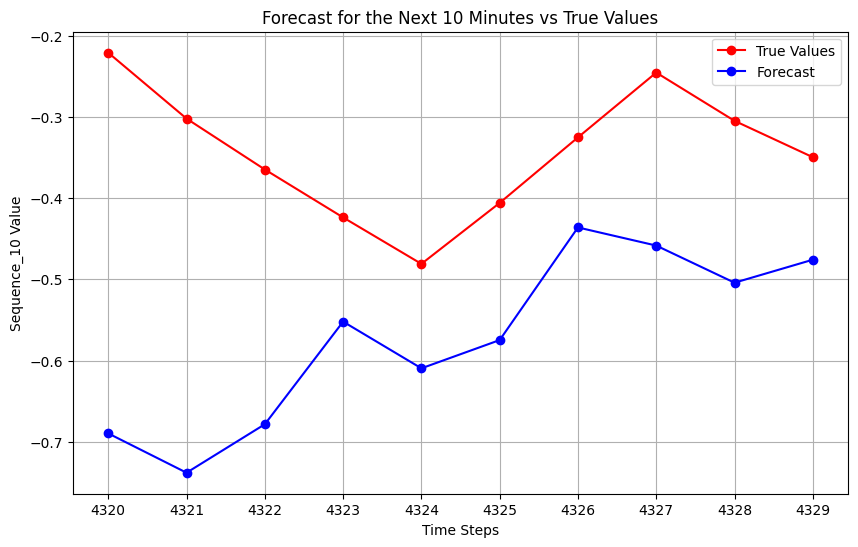

In [ ]:
# Forecast future steps
future_steps = 10
future_forecast = forecast_future(scaled_data, best_model, window_size, future_steps, sequence_10_index)
scaled_future_forecast = sequence_10_scaler.inverse_transform(future_forecast.reshape(-1, 1))

# Get true future values from the dataset
true_future_values = sequence_10_scaler.inverse_transform(scaled_data[-(future_steps + window_size):-window_size, sequence_10_index].reshape(-1, 1))

# Prepare to plot the forecast and true future values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), scaled_future_forecast, marker='o', label='True Values', color='red')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + future_steps), true_future_values, marker='o', label='Forecast', color='blue')
plt.title('Forecast for the Next 10 Minutes vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Sequence_10 Value')
plt.xticks(np.arange(len(scaled_data), len(scaled_data) + future_steps))
plt.legend()
plt.grid()
plt.savefig('Forecast _for_the_Next_10_Minutes_vs_True_Values_(ARIMA Adjusted)_100.pdf', format='pdf')
plt.close()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Transformer-based model for time series prediction
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, target_dim, num_heads, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
        super(TimeSeriesTransformer, self).__init__()
        self.input_dim = input_dim
        self.target_dim = target_dim
        self.embedding = nn.Linear(input_dim, dim_feedforward)
        self.pos_encoder = nn.Sequential(
            nn.Dropout(dropout)
        )
        self.transformer = nn.Transformer(
            d_model=dim_feedforward,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.decoder = nn.Linear(dim_feedforward, target_dim)

    def forward(self, src, tgt):
        # Embedding and Positional Encoding
        src = self.embedding(src)
        tgt = self.embedding(tgt)
        # Apply transformer and final linear layer to predict
        output = self.transformer(src, tgt)
        output = self.decoder(output)
        return output

# Define parameters
input_dim = X_train_tensor.shape[-1]  # Number of features
target_dim = y_train_tensor.shape[-1]  # Number of targets
num_heads = 4
num_encoder_layers = 2
num_decoder_layers = 2
dim_feedforward = 128
dropout = 0.1

# Initialize model, loss, and optimizer
model = TimeSeriesTransformer(input_dim, target_dim, num_heads, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# DataLoader setup
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Ensure that you set target_dim correctly to match your model's output
target_dim = 4  # Adjust this based on your specific problem

# Training loop
epochs = 20
model.train()
for epoch in range(epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:  # Assuming train_loader is defined
        optimizer.zero_grad()

        # Prepare target input for the Transformer
        batch_size = X_batch.size(0)
        seq_len = X_batch.size(1)  # This is the length of your input sequence

        # tgt_input should match the expected input dimensions for your transformer
        tgt_input = torch.zeros(batch_size, 1, target_dim).to(X_batch.device)  # Shape: (batch_size, 1, target_dim)

        # Permute to (seq_len, batch_size, feature_dim)
        X_batch_permuted = X_batch.permute(1, 0, 2)  # New shape: (seq_len, batch_size, feature_dim)

        # Check shape of permuted input
        print(f"Permuted X_batch shape: {X_batch_permuted.shape}, tgt_input shape: {tgt_input.shape}")

        # Forward pass
        try:
            output = model(X_batch_permuted, tgt_input)  # Pass the input to the model
        except RuntimeError as e:
            print(f"Error during forward pass: {e}")
            continue  # Skip to the next batch if there's an error

        # Reshape output to (batch_size, target_dim)
        output = output[-1, :, :]  # Use the last output of the sequence

        # Ensure y_batch is reshaped correctly
        y_batch = y_batch.view(-1, target_dim)  # Reshape labels to (batch_size, target_dim)

        # Check shapes before loss calculation
        print(f"Output shape: {output.shape}, y_batch shape: {y_batch.shape}")

        loss = criterion(output, y_batch)  # Calculate loss

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")


Permuted X_batch shape: torch.Size([18, 16, 60]), tgt_input shape: torch.Size([16, 1, 4])
Error during forward pass: mat1 and mat2 shapes cannot be multiplied (16x4 and 60x128)
Permuted X_batch shape: torch.Size([18, 16, 60]), tgt_input shape: torch.Size([16, 1, 4])
Error during forward pass: mat1 and mat2 shapes cannot be multiplied (16x4 and 60x128)
Permuted X_batch shape: torch.Size([18, 16, 60]), tgt_input shape: torch.Size([16, 1, 4])
Error during forward pass: mat1 and mat2 shapes cannot be multiplied (16x4 and 60x128)
Permuted X_batch shape: torch.Size([18, 16, 60]), tgt_input shape: torch.Size([16, 1, 4])
Error during forward pass: mat1 and mat2 shapes cannot be multiplied (16x4 and 60x128)
Permuted X_batch shape: torch.Size([18, 16, 60]), tgt_input shape: torch.Size([16, 1, 4])
Error during forward pass: mat1 and mat2 shapes cannot be multiplied (16x4 and 60x128)
Permuted X_batch shape: torch.Size([18, 16, 60]), tgt_input shape: torch.Size([16, 1, 4])
Error during forward pass